In [ ]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from PIL import Image
from tensorflow.keras import layers
import keras
from keras.optimizers import Adam
import time
from tqdm import tqdm
import tensorflow as tf
import cv2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
tf.config.run_functions_eagerly(True)
np.random.seed(10)  #for consistency of random numbers and our images

noise_dim = 100  # input dimension of random vector - the vector that goes into the generator

batch_size = 4   #How many images do we want to include in each batch
steps_per_epoch = 500  #How many steps do we want to take per iteration of our training set (number of batches)
epochs = 10     #How many iterations of our training set do we want to do.

#change the below values to the dimensions of your image. The channels number refers to the number of colors
img_rows, img_cols, channels = 128, 128, 3

#These are the recommended values for the optimizer
optimizer = Adam(0.0002, 0.5)

In [ ]:
#Importing data
data_path = "/content/drive/MyDrive/IMAGES_1"


In [ ]:
data = []
#data = np.ndarray(shape=(4117,128, 128, 3), dtype=np.float32)
for i in tqdm(os.listdir(data_path)):
    img = cv2.imread(data_path+i)
    if(img is not None):
        #cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (128,128))
        data.append(img)

100%|██████████| 570/570 [00:00<00:00, 5022.78it/s]


In [ ]:
data = np.array(data)
data = (data.astype(np.float32) - 127.5) / 127.5

# Define img_rows, img_cols, and channels
img_rows = 128  # Assuming your images are 128x128 based on previous code
img_cols = 128
channels = 3  # Assuming RGB images

data = data.reshape(-1, img_rows * img_cols * channels)

In [ ]:
from keras.initializers import RandomNormal
from keras.layers import Dense, Conv2D, Conv2DTranspose, Reshape, LeakyReLU # Import LeakyReLU directly from keras.layers
from keras.models import Sequential


def create_generator_cgan():
    generator = Sequential()

    d = 4
    generator.add(Dense(d*d*256, kernel_initializer=RandomNormal(0, 0.02), input_dim=noise_dim))
    generator.add(LeakyReLU(0.2))     #We are going to use the same leaky relu activation function as the FCGAN.

    generator.add(Reshape((d, d, 256)))

    generator.add(Conv2DTranspose(128, (4, 4), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
    generator.add(LeakyReLU(0.2))

    generator.add(Conv2DTranspose(128, (4, 4), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
    generator.add(LeakyReLU(0.2))
    generator.add(Conv2DTranspose(128, (4, 4), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
    generator.add(LeakyReLU(0.2))
    generator.add(Conv2DTranspose(128, (4, 4), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
    generator.add(LeakyReLU(0.2))
    generator.add(Conv2DTranspose(128, (4, 4), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
    generator.add(LeakyReLU(0.2))



    generator.add(Conv2D(channels, (3, 3), padding='same', activation='tanh', kernel_initializer=RandomNormal(0, 0.02)))  #Remember that the final activation has to be tanh, since pixel values go from -1 to 1

    generator.compile(loss='binary_crossentropy', optimizer=optimizer)    #The loss doesn't change when you use convolutional layers
    return generator

In [ ]:
from keras.initializers import RandomNormal
from keras.layers import Dense, Conv2D, Flatten, Reshape, Dropout
from keras.layers import LeakyReLU
from keras.models import Sequential

def create_discriminator_cgan():
    discriminator = Sequential()

    discriminator.add(Conv2D(64, (3, 3), padding='same', kernel_initializer=RandomNormal(0, 0.02), input_shape=(img_cols, img_rows, channels)))
    discriminator.add(LeakyReLU(0.2))

    discriminator.add(Conv2D(128, (3, 3), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
    discriminator.add(LeakyReLU(0.2))

    discriminator.add(Conv2D(128, (3, 3), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
    discriminator.add(LeakyReLU(0.2))

    discriminator.add(Conv2D(256, (3, 3), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
    discriminator.add(LeakyReLU(0.2))

    discriminator.add(Flatten())
    discriminator.add(Dropout(0.4))
    discriminator.add(Dense(1, activation='sigmoid', input_shape=(img_cols, img_rows, channels)))

    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)  #Again, the loss doesn't change when creating a DCGAN.
    return discriminator

In [ ]:
from keras.layers import Input
from keras.models import Model
from tensorflow.keras import optimizers
optimizer = optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

noise_dim=100
discriminator = create_discriminator_cgan()
generator = create_generator_cgan()

discriminator.trainable = False

gan_input = Input(shape=(noise_dim,))

fake_image = generator(gan_input)

gan_output = discriminator(fake_image)

gan = Model(gan_input, gan_output)
gan.compile(loss='binary_crossentropy', optimizer=optimizer)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
import os
import numpy as np
from PIL import Image

def load_data(data_path):
    """
    Loads image data from the specified directory and returns a NumPy array.

    Args:
        data_directory: The directory containing the image files.

    Returns:
        A NumPy array containing the image data.
    """
    images = []
    for filename in os.listdir(data_path):
        if filename.endswith(".jpg") or filename.endswith(".png"):  # Adjust file extensions as needed
            image_path = os.path.join(data_path, filename)
            image = Image.open(image_path)
            image = image.resize((img_rows, img_cols))  # Resize if necessary

            # Ensure all images are converted to RGB
            image = image.convert('RGB')

            image_array = np.array(image)
            images.append(image_array)

    return np.array(images)

# Assuming 'data_directory' is the path to your image data
data = load_data(data_path)

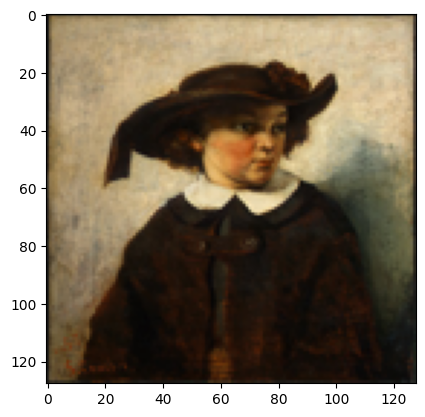

In [ ]:
image = data[29]
plt.imshow(image.reshape((img_rows, img_cols,channels)), cmap='gray')

In [ ]:
import matplotlib.pyplot as plt

def show_images(noise, size_fig):
    generated_images = generator.predict(noise)#Create the images from the GAN.
    #generated_images = (generated_images * 127.5) + 127.5
    plt.figure(figsize=size_fig)

    for i, image in enumerate(generated_images):
        plt.subplot(size_fig[0], size_fig[1], i+1)
        if channels == 1:
            plt.imshow(image.reshape((img_rows, img_cols)), cmap='gray')    #If the image is grayscale, as in our case, then we will reshape the output in the following way.
                                                                            #Also, we set the coloring to grayscale so that it doesn't look like it came out of an infrared camera :)
        else:
            plt.imshow(image.reshape((img_rows, img_cols, channels)))
        plt.axis('off')

    plt.tight_layout()   #Tight layout so that all of the generated images form a nice grid
    plt.show()

  0%|          | 0/500 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")
  0%|          | 1/500 [00:03<28:19,  3.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step


  0%|          | 2/500 [00:06<26:06,  3.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


  1%|          | 3/500 [00:09<25:15,  3.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step


  1%|          | 4/500 [00:13<28:29,  3.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step


  1%|          | 5/500 [00:17<29:03,  3.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step


  1%|          | 6/500 [00:20<27:30,  3.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


  1%|▏         | 7/500 [00:22<26:05,  3.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step


  2%|▏         | 8/500 [00:25<25:05,  3.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step


  2%|▏         | 9/500 [00:29<28:04,  3.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 659ms/step


  2%|▏         | 10/500 [00:33<29:04,  3.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step


  2%|▏         | 11/500 [00:36<27:57,  3.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


  2%|▏         | 12/500 [00:39<26:36,  3.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step


  3%|▎         | 13/500 [00:43<27:25,  3.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 724ms/step


  3%|▎         | 14/500 [00:47<30:04,  3.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 653ms/step


  3%|▎         | 15/500 [00:51<30:23,  3.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step


  3%|▎         | 16/500 [00:54<28:15,  3.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


  3%|▎         | 17/500 [00:58<28:08,  3.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step


  4%|▎         | 18/500 [01:02<30:53,  3.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


  4%|▍         | 19/500 [01:06<29:27,  3.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step


  4%|▍         | 20/500 [01:09<27:33,  3.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


  4%|▍         | 21/500 [01:12<26:45,  3.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step


  4%|▍         | 22/500 [01:15<27:18,  3.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 662ms/step


  5%|▍         | 23/500 [01:20<29:31,  3.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


  5%|▍         | 24/500 [01:23<27:28,  3.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step


  5%|▌         | 25/500 [01:25<26:01,  3.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step


  5%|▌         | 26/500 [01:28<25:12,  3.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


  5%|▌         | 27/500 [01:33<28:17,  3.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 734ms/step


  6%|▌         | 28/500 [01:37<28:46,  3.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step


  6%|▌         | 29/500 [01:40<27:08,  3.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step


  6%|▌         | 30/500 [01:42<25:19,  3.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step


  6%|▌         | 31/500 [01:45<25:00,  3.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 867ms/step


  6%|▋         | 32/500 [01:54<36:27,  4.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 785ms/step


  7%|▋         | 33/500 [01:59<37:17,  4.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step


  7%|▋         | 34/500 [02:02<33:08,  4.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step


  7%|▋         | 35/500 [02:05<31:55,  4.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 731ms/step


  7%|▋         | 36/500 [02:10<32:17,  4.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step


  7%|▋         | 37/500 [02:13<29:10,  3.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


  8%|▊         | 38/500 [02:16<27:44,  3.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step


  8%|▊         | 39/500 [02:19<26:08,  3.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step


  8%|▊         | 40/500 [02:23<26:55,  3.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 723ms/step


  8%|▊         | 41/500 [02:27<28:15,  3.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step


  8%|▊         | 42/500 [02:30<26:21,  3.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


  9%|▊         | 43/500 [02:32<24:55,  3.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step


  9%|▉         | 44/500 [02:35<23:44,  3.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 684ms/step


  9%|▉         | 45/500 [02:40<26:44,  3.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 719ms/step


  9%|▉         | 46/500 [02:44<27:25,  3.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


  9%|▉         | 47/500 [02:47<25:57,  3.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step


 10%|▉         | 48/500 [02:49<24:51,  3.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step


 10%|▉         | 49/500 [02:54<26:27,  3.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 725ms/step


 10%|█         | 50/500 [02:58<27:49,  3.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step


 10%|█         | 51/500 [03:01<26:33,  3.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step


 10%|█         | 52/500 [03:04<25:48,  3.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step


 11%|█         | 53/500 [03:07<25:21,  3.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 682ms/step


 11%|█         | 54/500 [03:12<28:45,  3.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 511ms/step


 11%|█         | 55/500 [03:15<27:01,  3.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


 11%|█         | 56/500 [03:18<24:54,  3.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step


 11%|█▏        | 57/500 [03:21<24:24,  3.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


 12%|█▏        | 58/500 [03:25<24:49,  3.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 672ms/step


 12%|█▏        | 59/500 [03:29<26:47,  3.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step


 12%|█▏        | 60/500 [03:32<25:03,  3.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step


 12%|█▏        | 61/500 [03:35<24:03,  3.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step


 12%|█▏        | 62/500 [03:38<23:05,  3.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step


 13%|█▎        | 63/500 [03:42<24:07,  3.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 744ms/step


 13%|█▎        | 64/500 [03:46<26:03,  3.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step


 13%|█▎        | 65/500 [03:49<25:02,  3.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step


 13%|█▎        | 66/500 [03:52<23:48,  3.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step


 13%|█▎        | 67/500 [03:55<23:08,  3.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 686ms/step


 14%|█▎        | 68/500 [04:00<27:36,  3.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 14%|█▍        | 69/500 [04:03<26:03,  3.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


 14%|█▍        | 70/500 [04:06<25:04,  3.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step


 14%|█▍        | 71/500 [04:09<23:48,  3.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step


 14%|█▍        | 72/500 [04:13<24:37,  3.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 676ms/step


 15%|█▍        | 73/500 [04:17<26:19,  3.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step


 15%|█▍        | 74/500 [04:20<24:52,  3.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step


 15%|█▌        | 75/500 [04:24<23:57,  3.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


 15%|█▌        | 76/500 [04:27<24:20,  3.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 726ms/step


 15%|█▌        | 77/500 [04:32<26:32,  3.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step


 16%|█▌        | 78/500 [04:35<24:46,  3.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step


 16%|█▌        | 79/500 [04:38<23:30,  3.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step


 16%|█▌        | 80/500 [04:41<22:55,  3.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step


 16%|█▌        | 81/500 [04:45<24:30,  3.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 664ms/step


 16%|█▋        | 82/500 [04:49<25:49,  3.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step


 17%|█▋        | 83/500 [04:52<23:52,  3.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step


 17%|█▋        | 84/500 [04:55<23:01,  3.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step


 17%|█▋        | 85/500 [04:59<23:54,  3.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 714ms/step


 17%|█▋        | 86/500 [05:04<27:46,  4.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 722ms/step


 17%|█▋        | 87/500 [05:09<29:20,  4.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step


 18%|█▊        | 88/500 [05:12<26:27,  3.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step


 18%|█▊        | 89/500 [05:15<26:13,  3.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 659ms/step


 18%|█▊        | 90/500 [05:20<28:14,  4.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step


 18%|█▊        | 91/500 [05:23<25:26,  3.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step


 18%|█▊        | 92/500 [05:26<23:41,  3.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step


 19%|█▊        | 93/500 [05:29<22:02,  3.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step


 19%|█▉        | 94/500 [05:33<24:41,  3.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 760ms/step


 19%|█▉        | 95/500 [05:37<25:01,  3.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step


 19%|█▉        | 96/500 [05:40<23:13,  3.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step


 19%|█▉        | 97/500 [05:43<22:37,  3.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 20%|█▉        | 98/500 [05:47<23:18,  3.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 725ms/step


 20%|█▉        | 99/500 [05:51<25:15,  3.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step


 20%|██        | 100/500 [05:54<23:18,  3.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step


 20%|██        | 101/500 [05:57<22:14,  3.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step


 20%|██        | 102/500 [06:00<21:55,  3.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step


 21%|██        | 103/500 [06:05<24:03,  3.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 712ms/step


 21%|██        | 104/500 [06:09<24:45,  3.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step


 21%|██        | 105/500 [06:12<22:57,  3.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step


 21%|██        | 106/500 [06:15<22:24,  3.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step


 21%|██▏       | 107/500 [06:18<22:46,  3.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 750ms/step


 22%|██▏       | 108/500 [06:23<25:02,  3.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


 22%|██▏       | 109/500 [06:26<23:42,  3.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step


 22%|██▏       | 110/500 [06:30<22:52,  3.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step


 22%|██▏       | 111/500 [06:33<22:42,  3.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 689ms/step


 22%|██▏       | 112/500 [06:38<25:29,  3.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step


 23%|██▎       | 113/500 [06:41<23:34,  3.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


 23%|██▎       | 114/500 [06:44<22:32,  3.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step


 23%|██▎       | 115/500 [06:47<21:32,  3.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step


 23%|██▎       | 116/500 [06:51<22:40,  3.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 680ms/step


 23%|██▎       | 117/500 [06:55<23:47,  3.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step


 24%|██▎       | 118/500 [06:58<22:42,  3.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


 24%|██▍       | 119/500 [07:02<21:42,  3.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step


 24%|██▍       | 120/500 [07:05<21:38,  3.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 745ms/step


 24%|██▍       | 121/500 [07:10<23:51,  3.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step


 24%|██▍       | 122/500 [07:13<22:38,  3.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


 25%|██▍       | 123/500 [07:16<21:41,  3.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step


 25%|██▍       | 124/500 [07:19<20:12,  3.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step


 25%|██▌       | 125/500 [07:23<21:45,  3.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 757ms/step


 25%|██▌       | 126/500 [07:26<22:22,  3.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 25%|██▌       | 127/500 [07:29<21:05,  3.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step


 26%|██▌       | 128/500 [07:32<20:25,  3.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step


 26%|██▌       | 129/500 [07:36<21:28,  3.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 677ms/step


 26%|██▌       | 130/500 [07:41<22:52,  3.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step


 26%|██▌       | 131/500 [07:44<21:38,  3.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step


 26%|██▋       | 132/500 [07:47<20:54,  3.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step


 27%|██▋       | 133/500 [07:50<20:07,  3.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step


 27%|██▋       | 134/500 [07:54<21:37,  3.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 767ms/step


 27%|██▋       | 135/500 [07:58<21:56,  3.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step


 27%|██▋       | 136/500 [08:01<20:46,  3.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step


 27%|██▋       | 137/500 [08:04<19:39,  3.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step


 28%|██▊       | 138/500 [08:07<19:24,  3.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 659ms/step


 28%|██▊       | 139/500 [08:12<22:13,  3.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step


 28%|██▊       | 140/500 [08:14<20:27,  3.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step


 28%|██▊       | 141/500 [08:17<19:59,  3.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step


 28%|██▊       | 142/500 [08:21<19:36,  3.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step


 29%|██▊       | 143/500 [08:25<21:09,  3.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 649ms/step


 29%|██▉       | 144/500 [08:29<21:29,  3.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step


 29%|██▉       | 145/500 [08:32<20:43,  3.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step


 29%|██▉       | 146/500 [08:35<20:02,  3.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step


 29%|██▉       | 147/500 [08:39<20:25,  3.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 668ms/step


 30%|██▉       | 148/500 [08:43<21:34,  3.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step


 30%|██▉       | 149/500 [08:46<20:27,  3.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step


 30%|███       | 150/500 [08:49<19:09,  3.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step


 30%|███       | 151/500 [08:52<19:03,  3.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 720ms/step


 30%|███       | 152/500 [08:57<22:08,  3.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 511ms/step


 31%|███       | 153/500 [09:00<20:30,  3.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step


 31%|███       | 154/500 [09:03<19:36,  3.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step


 31%|███       | 155/500 [09:06<19:13,  3.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step


 31%|███       | 156/500 [09:10<19:56,  3.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 687ms/step


 31%|███▏      | 157/500 [09:14<21:02,  3.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step


 32%|███▏      | 158/500 [09:17<19:38,  3.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


 32%|███▏      | 159/500 [09:20<18:28,  3.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


 32%|███▏      | 160/500 [09:23<18:27,  3.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 716ms/step


 32%|███▏      | 161/500 [09:28<21:11,  3.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step


 32%|███▏      | 162/500 [09:31<19:55,  3.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step


 33%|███▎      | 163/500 [09:34<18:47,  3.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step


 33%|███▎      | 164/500 [09:37<18:11,  3.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step


 33%|███▎      | 165/500 [09:41<18:58,  3.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 688ms/step


 33%|███▎      | 166/500 [09:45<20:21,  3.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


 33%|███▎      | 167/500 [09:48<18:39,  3.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


 34%|███▎      | 168/500 [09:50<17:40,  3.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step


 34%|███▍      | 169/500 [09:53<16:56,  3.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step


 34%|███▍      | 170/500 [09:58<18:55,  3.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 753ms/step


 34%|███▍      | 171/500 [10:01<19:16,  3.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


 34%|███▍      | 172/500 [10:04<18:08,  3.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step


 35%|███▍      | 173/500 [10:07<17:47,  3.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


 35%|███▍      | 174/500 [10:10<17:20,  3.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 680ms/step


 35%|███▌      | 175/500 [10:15<19:57,  3.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step


 35%|███▌      | 176/500 [10:18<18:30,  3.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


 35%|███▌      | 177/500 [10:21<17:30,  3.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step


 36%|███▌      | 178/500 [10:24<17:30,  3.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step


 36%|███▌      | 179/500 [10:28<18:59,  3.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 657ms/step


 36%|███▌      | 180/500 [10:32<19:11,  3.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step


 36%|███▌      | 181/500 [10:35<18:06,  3.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step


 36%|███▋      | 182/500 [10:38<17:16,  3.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


 37%|███▋      | 183/500 [10:41<17:04,  3.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 636ms/step


 37%|███▋      | 184/500 [10:45<18:57,  3.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


 37%|███▋      | 185/500 [10:49<18:14,  3.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step


 37%|███▋      | 186/500 [10:52<17:36,  3.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step


 37%|███▋      | 187/500 [10:54<16:29,  3.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step


 38%|███▊      | 188/500 [10:58<17:28,  3.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 740ms/step


 38%|███▊      | 189/500 [11:03<18:55,  3.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


 38%|███▊      | 190/500 [11:06<17:52,  3.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


 38%|███▊      | 191/500 [11:09<17:13,  3.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step


 38%|███▊      | 192/500 [11:12<16:51,  3.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 707ms/step


 39%|███▊      | 193/500 [11:17<19:48,  3.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step


 39%|███▉      | 194/500 [11:20<18:44,  3.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


 39%|███▉      | 195/500 [11:23<17:33,  3.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step


 39%|███▉      | 196/500 [11:26<16:36,  3.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


 39%|███▉      | 197/500 [11:30<16:55,  3.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 730ms/step


 40%|███▉      | 198/500 [11:34<18:43,  3.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


 40%|███▉      | 199/500 [11:37<17:07,  3.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step


 40%|████      | 200/500 [11:40<16:22,  3.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


 40%|████      | 201/500 [11:43<15:56,  3.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step


 40%|████      | 202/500 [11:47<17:42,  3.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 730ms/step


 41%|████      | 203/500 [11:51<17:27,  3.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


 41%|████      | 204/500 [11:54<16:51,  3.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


 41%|████      | 205/500 [11:57<15:45,  3.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step


 41%|████      | 206/500 [12:02<19:19,  3.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 41%|████▏     | 207/500 [12:10<25:24,  5.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step


 42%|████▏     | 208/500 [12:14<22:21,  4.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step


 42%|████▏     | 209/500 [12:16<19:25,  4.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step


 42%|████▏     | 210/500 [12:19<18:02,  3.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


 42%|████▏     | 211/500 [12:24<18:43,  3.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 665ms/step


 42%|████▏     | 212/500 [12:29<20:18,  4.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 680ms/step


 43%|████▎     | 213/500 [12:32<19:43,  4.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step


 43%|████▎     | 214/500 [12:36<18:13,  3.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 692ms/step


 43%|████▎     | 215/500 [12:41<19:55,  4.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 43%|████▎     | 216/500 [12:43<17:43,  3.74s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step


 43%|████▎     | 217/500 [12:46<16:39,  3.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


 44%|████▎     | 218/500 [12:49<15:59,  3.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step


 44%|████▍     | 219/500 [12:54<16:49,  3.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 673ms/step


 44%|████▍     | 220/500 [12:57<17:08,  3.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step


 44%|████▍     | 221/500 [13:01<16:30,  3.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step


 44%|████▍     | 222/500 [13:04<15:55,  3.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 45%|████▍     | 223/500 [13:07<15:54,  3.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 701ms/step


 45%|████▍     | 224/500 [13:12<17:27,  3.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


 45%|████▌     | 225/500 [13:15<16:19,  3.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


 45%|████▌     | 226/500 [13:18<15:13,  3.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step


 45%|████▌     | 227/500 [13:20<14:17,  3.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step


 46%|████▌     | 228/500 [13:24<15:07,  3.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 689ms/step


 46%|████▌     | 229/500 [13:29<16:40,  3.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step


 46%|████▌     | 230/500 [13:32<15:56,  3.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step


 46%|████▌     | 231/500 [13:35<15:07,  3.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step


 46%|████▋     | 232/500 [13:38<14:41,  3.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 706ms/step


 47%|████▋     | 233/500 [13:43<16:50,  3.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step


 47%|████▋     | 234/500 [13:46<15:41,  3.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


 47%|████▋     | 235/500 [13:49<15:02,  3.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 47%|████▋     | 236/500 [13:52<14:01,  3.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step


 47%|████▋     | 237/500 [13:56<14:58,  3.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 680ms/step


 48%|████▊     | 238/500 [14:00<15:45,  3.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step


 48%|████▊     | 239/500 [14:03<14:56,  3.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step


 48%|████▊     | 240/500 [14:06<14:32,  3.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step


 48%|████▊     | 241/500 [14:09<14:02,  3.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 48%|████▊     | 242/500 [14:13<15:20,  3.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 771ms/step


 49%|████▊     | 243/500 [14:17<15:47,  3.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step


 49%|████▉     | 244/500 [14:20<14:56,  3.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step


 49%|████▉     | 245/500 [14:23<14:13,  3.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step


 49%|████▉     | 246/500 [14:27<14:13,  3.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 662ms/step


 49%|████▉     | 247/500 [14:31<15:31,  3.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step


 50%|████▉     | 248/500 [14:34<14:37,  3.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step


 50%|████▉     | 249/500 [14:37<14:04,  3.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step


 50%|█████     | 250/500 [14:40<13:26,  3.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step


 50%|█████     | 251/500 [14:44<14:30,  3.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 709ms/step


 50%|█████     | 252/500 [14:48<14:52,  3.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step


 51%|█████     | 253/500 [14:51<14:14,  3.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


 51%|█████     | 254/500 [14:54<13:10,  3.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


 51%|█████     | 255/500 [14:57<12:40,  3.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 740ms/step


 51%|█████     | 256/500 [15:02<14:59,  3.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 51%|█████▏    | 257/500 [15:05<13:56,  3.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step


 52%|█████▏    | 258/500 [15:08<13:26,  3.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


 52%|█████▏    | 259/500 [15:10<12:33,  3.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step


 52%|█████▏    | 260/500 [15:14<12:49,  3.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 677ms/step


 52%|█████▏    | 261/500 [15:18<14:23,  3.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step


 52%|█████▏    | 262/500 [15:21<13:40,  3.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


 53%|█████▎    | 263/500 [15:24<12:47,  3.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step


 53%|█████▎    | 264/500 [15:27<12:42,  3.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step


 53%|█████▎    | 265/500 [15:31<13:49,  3.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 727ms/step


 53%|█████▎    | 266/500 [15:35<14:09,  3.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step


 53%|█████▎    | 267/500 [15:38<13:06,  3.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step


 54%|█████▎    | 268/500 [15:41<12:40,  3.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


 54%|█████▍    | 269/500 [15:45<12:57,  3.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 741ms/step


 54%|█████▍    | 270/500 [15:49<14:05,  3.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step


 54%|█████▍    | 271/500 [15:52<13:20,  3.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step


 54%|█████▍    | 272/500 [15:55<12:53,  3.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step


 55%|█████▍    | 273/500 [15:59<13:01,  3.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 722ms/step


 55%|█████▍    | 274/500 [16:04<14:31,  3.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


 55%|█████▌    | 275/500 [16:07<13:43,  3.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step


 55%|█████▌    | 276/500 [16:10<12:36,  3.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step


 55%|█████▌    | 277/500 [16:13<12:24,  3.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


 56%|█████▌    | 278/500 [16:17<13:04,  3.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 651ms/step


 56%|█████▌    | 279/500 [16:21<13:11,  3.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


 56%|█████▌    | 280/500 [16:24<12:26,  3.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


 56%|█████▌    | 281/500 [16:27<11:58,  3.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


 56%|█████▋    | 282/500 [16:30<11:35,  3.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 681ms/step


 57%|█████▋    | 283/500 [16:35<13:28,  3.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step


 57%|█████▋    | 284/500 [16:38<12:49,  3.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step


 57%|█████▋    | 285/500 [16:41<12:00,  3.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step


 57%|█████▋    | 286/500 [16:44<11:38,  3.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step


 57%|█████▋    | 287/500 [16:48<12:49,  3.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 663ms/step


 58%|█████▊    | 288/500 [16:52<12:53,  3.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step


 58%|█████▊    | 289/500 [16:55<12:02,  3.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step


 58%|█████▊    | 290/500 [16:57<11:16,  3.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step


 58%|█████▊    | 291/500 [17:00<10:51,  3.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 639ms/step


 58%|█████▊    | 292/500 [17:05<12:18,  3.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 800ms/step


 59%|█████▊    | 293/500 [17:08<12:13,  3.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 59%|█████▉    | 294/500 [17:11<11:26,  3.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


 59%|█████▉    | 295/500 [17:14<10:57,  3.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step


 59%|█████▉    | 296/500 [17:18<11:24,  3.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 722ms/step


 59%|█████▉    | 297/500 [17:23<12:50,  3.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


 60%|█████▉    | 298/500 [17:26<11:48,  3.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step


 60%|█████▉    | 299/500 [17:29<11:16,  3.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


 60%|██████    | 300/500 [17:31<10:42,  3.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step


 60%|██████    | 301/500 [17:36<11:50,  3.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 707ms/step


 60%|██████    | 302/500 [17:40<11:58,  3.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step


 61%|██████    | 303/500 [17:43<11:15,  3.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step


 61%|██████    | 304/500 [17:46<10:51,  3.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step


 61%|██████    | 305/500 [17:50<11:26,  3.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 753ms/step


 61%|██████    | 306/500 [17:54<11:47,  3.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step


 61%|██████▏   | 307/500 [17:56<10:52,  3.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step


 62%|██████▏   | 308/500 [17:59<10:27,  3.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


 62%|██████▏   | 309/500 [18:02<10:17,  3.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 692ms/step


 62%|██████▏   | 310/500 [18:07<11:31,  3.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 745ms/step


 62%|██████▏   | 311/500 [18:10<11:17,  3.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step


 62%|██████▏   | 312/500 [18:14<10:44,  3.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step


 63%|██████▎   | 313/500 [18:16<10:08,  3.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step


 63%|██████▎   | 314/500 [18:20<10:04,  3.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 643ms/step


 63%|██████▎   | 315/500 [18:24<11:04,  3.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step


 63%|██████▎   | 316/500 [18:27<10:22,  3.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step


 63%|██████▎   | 317/500 [18:30<10:00,  3.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step


 64%|██████▎   | 318/500 [18:33<09:30,  3.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step


 64%|██████▍   | 319/500 [18:36<09:59,  3.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 737ms/step


 64%|██████▍   | 320/500 [18:41<10:47,  3.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step


 64%|██████▍   | 321/500 [18:44<10:08,  3.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step


 64%|██████▍   | 322/500 [18:47<09:44,  3.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step


 65%|██████▍   | 323/500 [18:50<09:30,  3.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 660ms/step


 65%|██████▍   | 324/500 [18:55<10:58,  3.74s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step


 65%|██████▌   | 325/500 [18:58<10:11,  3.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step


 65%|██████▌   | 326/500 [19:01<09:34,  3.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step


 65%|██████▌   | 327/500 [19:04<09:18,  3.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step


 66%|██████▌   | 328/500 [19:08<10:04,  3.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 715ms/step


 66%|██████▌   | 329/500 [19:12<10:13,  3.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step


 66%|██████▌   | 330/500 [19:14<09:38,  3.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


 66%|██████▌   | 331/500 [19:18<09:18,  3.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step


 66%|██████▋   | 332/500 [19:20<08:57,  3.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 648ms/step


 67%|██████▋   | 333/500 [19:25<10:15,  3.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


 67%|██████▋   | 334/500 [19:28<09:39,  3.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step


 67%|██████▋   | 335/500 [19:31<09:13,  3.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step


 67%|██████▋   | 336/500 [19:34<08:53,  3.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step


 67%|██████▋   | 337/500 [19:39<09:34,  3.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 642ms/step


 68%|██████▊   | 338/500 [19:42<09:24,  3.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step


 68%|██████▊   | 339/500 [19:45<08:53,  3.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step


 68%|██████▊   | 340/500 [19:48<09:02,  3.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 760ms/step


 68%|██████▊   | 341/500 [19:54<10:21,  3.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 745ms/step


 68%|██████▊   | 342/500 [19:58<10:31,  4.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step


 69%|██████▊   | 343/500 [20:01<09:33,  3.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step


 69%|██████▉   | 344/500 [20:03<08:44,  3.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


 69%|██████▉   | 345/500 [20:06<08:25,  3.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step


 69%|██████▉   | 346/500 [20:10<08:40,  3.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 659ms/step


 69%|██████▉   | 347/500 [20:14<09:07,  3.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step


 70%|██████▉   | 348/500 [20:17<08:42,  3.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


 70%|██████▉   | 349/500 [20:20<08:29,  3.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 70%|███████   | 350/500 [20:24<08:40,  3.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 733ms/step


 70%|███████   | 351/500 [20:28<09:13,  3.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step


 70%|███████   | 352/500 [20:31<08:36,  3.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step


 71%|███████   | 353/500 [20:35<08:22,  3.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step


 71%|███████   | 354/500 [20:38<08:10,  3.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step


 71%|███████   | 355/500 [20:42<08:51,  3.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 738ms/step


 71%|███████   | 356/500 [20:46<08:51,  3.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step


 71%|███████▏  | 357/500 [20:49<08:18,  3.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


 72%|███████▏  | 358/500 [20:52<07:50,  3.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step


 72%|███████▏  | 359/500 [20:56<08:11,  3.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 762ms/step


 72%|███████▏  | 360/500 [21:00<08:46,  3.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step


 72%|███████▏  | 361/500 [21:03<08:13,  3.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step


 72%|███████▏  | 362/500 [21:06<07:49,  3.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step


 73%|███████▎  | 363/500 [21:10<08:04,  3.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 693ms/step


 73%|███████▎  | 364/500 [21:14<08:31,  3.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step


 73%|███████▎  | 365/500 [21:17<07:49,  3.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step


 73%|███████▎  | 366/500 [21:21<07:39,  3.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step


 73%|███████▎  | 367/500 [21:23<07:05,  3.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


 74%|███████▎  | 368/500 [21:28<07:53,  3.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 712ms/step


 74%|███████▍  | 369/500 [21:32<07:59,  3.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step


 74%|███████▍  | 370/500 [21:35<07:34,  3.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step


 74%|███████▍  | 371/500 [21:38<07:14,  3.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step


 74%|███████▍  | 372/500 [21:41<07:13,  3.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 725ms/step


 75%|███████▍  | 373/500 [21:45<07:34,  3.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step


 75%|███████▍  | 374/500 [21:48<07:06,  3.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


 75%|███████▌  | 375/500 [21:51<06:46,  3.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step


 75%|███████▌  | 376/500 [21:54<06:37,  3.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 508ms/step


 75%|███████▌  | 377/500 [21:59<07:24,  3.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 765ms/step


 76%|███████▌  | 378/500 [22:03<07:30,  3.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step


 76%|███████▌  | 379/500 [22:06<06:59,  3.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


 76%|███████▌  | 380/500 [22:08<06:32,  3.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step


 76%|███████▌  | 381/500 [22:14<07:38,  3.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 894ms/step


 76%|███████▋  | 382/500 [22:20<09:21,  4.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 884ms/step


 77%|███████▋  | 383/500 [22:24<08:51,  4.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step


 77%|███████▋  | 384/500 [22:28<07:58,  4.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step


 77%|███████▋  | 385/500 [22:31<07:34,  3.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 709ms/step


 77%|███████▋  | 386/500 [22:36<07:55,  4.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step


 77%|███████▋  | 387/500 [22:39<07:20,  3.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step


 78%|███████▊  | 388/500 [22:42<06:48,  3.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step


 78%|███████▊  | 389/500 [22:46<06:36,  3.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 653ms/step


 78%|███████▊  | 390/500 [22:50<07:10,  3.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step


 78%|███████▊  | 391/500 [22:53<06:34,  3.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


 78%|███████▊  | 392/500 [22:56<06:12,  3.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step


 79%|███████▊  | 393/500 [22:59<05:58,  3.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step


 79%|███████▉  | 394/500 [23:04<06:34,  3.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 720ms/step


 79%|███████▉  | 395/500 [23:08<06:30,  3.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


 79%|███████▉  | 396/500 [23:11<06:03,  3.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step


 79%|███████▉  | 397/500 [23:14<05:47,  3.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


 80%|███████▉  | 398/500 [23:17<05:53,  3.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 709ms/step


 80%|███████▉  | 399/500 [23:22<06:18,  3.74s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


 80%|████████  | 400/500 [23:25<05:53,  3.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step


 80%|████████  | 401/500 [23:28<05:35,  3.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


 80%|████████  | 402/500 [23:31<05:24,  3.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 733ms/step


 81%|████████  | 403/500 [23:36<06:12,  3.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step


 81%|████████  | 404/500 [23:39<05:36,  3.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


 81%|████████  | 405/500 [23:41<05:08,  3.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step


 81%|████████  | 406/500 [23:44<04:56,  3.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


 81%|████████▏ | 407/500 [23:48<05:12,  3.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step


 82%|████████▏ | 408/500 [23:52<05:31,  3.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step


 82%|████████▏ | 409/500 [23:56<05:13,  3.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step


 82%|████████▏ | 410/500 [23:59<04:58,  3.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 82%|████████▏ | 411/500 [24:02<05:02,  3.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 734ms/step


 82%|████████▏ | 412/500 [24:07<05:29,  3.74s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step


 83%|████████▎ | 413/500 [24:10<05:04,  3.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step


 83%|████████▎ | 414/500 [24:12<04:45,  3.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step


 83%|████████▎ | 415/500 [24:15<04:33,  3.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step


 83%|████████▎ | 416/500 [24:20<04:55,  3.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 694ms/step


 83%|████████▎ | 417/500 [24:23<04:58,  3.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step


 84%|████████▎ | 418/500 [24:27<04:44,  3.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step


 84%|████████▍ | 419/500 [24:30<04:26,  3.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step


 84%|████████▍ | 420/500 [24:34<04:45,  3.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 727ms/step


 84%|████████▍ | 421/500 [24:38<04:50,  3.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step


 84%|████████▍ | 422/500 [24:41<04:28,  3.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step


 85%|████████▍ | 423/500 [24:44<04:14,  3.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step


 85%|████████▍ | 424/500 [24:47<04:19,  3.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 696ms/step


 85%|████████▌ | 425/500 [24:52<04:45,  3.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


 85%|████████▌ | 426/500 [24:55<04:21,  3.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


 85%|████████▌ | 427/500 [24:57<03:58,  3.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step


 86%|████████▌ | 428/500 [25:00<03:41,  3.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step


 86%|████████▌ | 429/500 [25:04<03:58,  3.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 733ms/step


 86%|████████▌ | 430/500 [25:08<04:02,  3.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step


 86%|████████▌ | 431/500 [25:11<03:44,  3.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step


 86%|████████▋ | 432/500 [25:14<03:38,  3.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step


 87%|████████▋ | 433/500 [25:17<03:39,  3.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/step


 87%|████████▋ | 434/500 [25:22<04:03,  3.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


 87%|████████▋ | 435/500 [25:25<03:50,  3.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step


 87%|████████▋ | 436/500 [25:28<03:34,  3.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


 87%|████████▋ | 437/500 [25:31<03:24,  3.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 710ms/step


 88%|████████▊ | 438/500 [25:36<03:55,  3.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step


 88%|████████▊ | 439/500 [25:39<03:30,  3.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


 88%|████████▊ | 440/500 [25:41<03:13,  3.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


 88%|████████▊ | 441/500 [25:44<03:04,  3.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step


 88%|████████▊ | 442/500 [25:48<03:11,  3.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 749ms/step


 89%|████████▊ | 443/500 [25:52<03:27,  3.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step


 89%|████████▉ | 444/500 [25:56<03:17,  3.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step


 89%|████████▉ | 445/500 [25:59<03:05,  3.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step


 89%|████████▉ | 446/500 [26:02<03:06,  3.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 676ms/step


 89%|████████▉ | 447/500 [26:07<03:24,  3.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step


 90%|████████▉ | 448/500 [26:10<03:07,  3.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step


 90%|████████▉ | 449/500 [26:13<02:54,  3.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step


 90%|█████████ | 450/500 [26:16<02:45,  3.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 695ms/step


 90%|█████████ | 451/500 [26:21<03:05,  3.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


 90%|█████████ | 452/500 [26:24<02:52,  3.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step


 91%|█████████ | 453/500 [26:27<02:36,  3.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


 91%|█████████ | 454/500 [26:30<02:28,  3.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step


 91%|█████████ | 455/500 [26:34<02:35,  3.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 737ms/step


 91%|█████████ | 456/500 [26:38<02:42,  3.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


 91%|█████████▏| 457/500 [26:41<02:32,  3.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step


 92%|█████████▏| 458/500 [26:44<02:19,  3.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step


 92%|█████████▏| 459/500 [26:47<02:14,  3.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 710ms/step


 92%|█████████▏| 460/500 [26:52<02:24,  3.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 741ms/step


 92%|█████████▏| 461/500 [26:55<02:22,  3.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step


 92%|█████████▏| 462/500 [26:58<02:11,  3.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step


 93%|█████████▎| 463/500 [27:01<02:02,  3.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step


 93%|█████████▎| 464/500 [27:05<02:02,  3.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step


 93%|█████████▎| 465/500 [27:09<02:03,  3.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


 93%|█████████▎| 466/500 [27:12<01:58,  3.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 763ms/step


 93%|█████████▎| 467/500 [27:17<02:04,  3.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step


 94%|█████████▎| 468/500 [27:21<02:01,  3.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 754ms/step


 94%|█████████▍| 469/500 [27:25<01:59,  3.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step


 94%|█████████▍| 470/500 [27:28<01:48,  3.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step


 94%|█████████▍| 471/500 [27:31<01:39,  3.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step


 94%|█████████▍| 472/500 [27:34<01:32,  3.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step


 95%|█████████▍| 473/500 [27:38<01:38,  3.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 705ms/step


 95%|█████████▍| 474/500 [27:41<01:32,  3.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step


 95%|█████████▌| 475/500 [27:44<01:24,  3.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


 95%|█████████▌| 476/500 [27:47<01:18,  3.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step


 95%|█████████▌| 477/500 [27:50<01:12,  3.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 731ms/step


 96%|█████████▌| 478/500 [27:55<01:20,  3.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step


 96%|█████████▌| 479/500 [27:58<01:14,  3.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


 96%|█████████▌| 480/500 [28:01<01:08,  3.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step


 96%|█████████▌| 481/500 [28:05<01:02,  3.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step


 96%|█████████▋| 482/500 [28:09<01:03,  3.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 656ms/step


 97%|█████████▋| 483/500 [28:12<01:00,  3.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


 97%|█████████▋| 484/500 [28:15<00:54,  3.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 97%|█████████▋| 485/500 [28:18<00:47,  3.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step


 97%|█████████▋| 486/500 [28:21<00:44,  3.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 754ms/step


 97%|█████████▋| 487/500 [28:26<00:49,  3.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


 98%|█████████▊| 488/500 [28:29<00:43,  3.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step


 98%|█████████▊| 489/500 [28:32<00:37,  3.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step


 98%|█████████▊| 490/500 [28:35<00:32,  3.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


 98%|█████████▊| 491/500 [28:39<00:31,  3.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 657ms/step


 98%|█████████▊| 492/500 [28:43<00:28,  3.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step


 99%|█████████▊| 493/500 [28:46<00:23,  3.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step


 99%|█████████▉| 494/500 [28:49<00:19,  3.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


 99%|█████████▉| 495/500 [28:52<00:16,  3.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 718ms/step


 99%|█████████▉| 496/500 [28:57<00:14,  3.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 516ms/step


 99%|█████████▉| 497/500 [29:00<00:10,  3.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


100%|█████████▉| 498/500 [29:03<00:06,  3.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


100%|█████████▉| 499/500 [29:06<00:03,  3.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step


100%|██████████| 500/500 [29:10<00:00,  3.50s/it]


Epoch: 1 	 Discriminator Loss: 0.6343844532966614 		 Generator Loss: [array(0.63438445), array(0.63438445), array(0.63438445)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


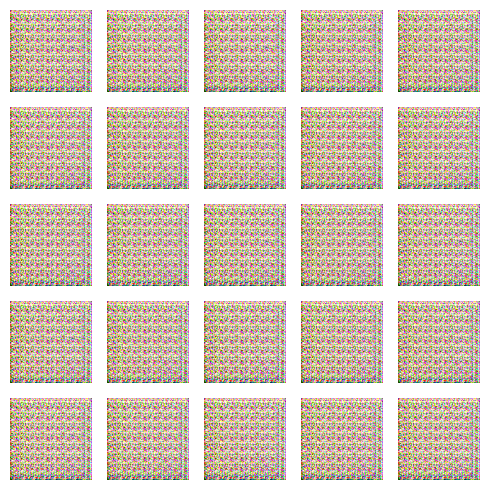

  0%|          | 0/500 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


  0%|          | 1/500 [00:02<23:20,  2.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


  0%|          | 2/500 [00:06<25:45,  3.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 721ms/step


  1%|          | 3/500 [00:10<31:41,  3.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step


  1%|          | 4/500 [00:13<29:01,  3.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step


  1%|          | 5/500 [00:17<28:13,  3.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step


  1%|          | 6/500 [00:20<27:42,  3.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step


  1%|▏         | 7/500 [00:25<32:05,  3.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step


  2%|▏         | 8/500 [00:28<30:06,  3.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step


  2%|▏         | 9/500 [00:31<28:11,  3.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step


  2%|▏         | 10/500 [00:34<26:22,  3.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


  2%|▏         | 11/500 [00:38<27:56,  3.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 628ms/step


  2%|▏         | 12/500 [00:41<28:46,  3.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step


  3%|▎         | 13/500 [00:45<27:41,  3.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step


  3%|▎         | 14/500 [00:47<26:21,  3.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step


  3%|▎         | 15/500 [00:50<25:21,  3.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step


  3%|▎         | 16/500 [00:54<27:43,  3.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 776ms/step


  3%|▎         | 17/500 [00:58<28:00,  3.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step


  4%|▎         | 18/500 [01:01<27:05,  3.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


  4%|▍         | 19/500 [01:04<25:33,  3.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step


  4%|▍         | 20/500 [01:08<26:58,  3.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 678ms/step


  4%|▍         | 21/500 [01:12<29:49,  3.74s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step


  4%|▍         | 22/500 [01:15<28:14,  3.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


  5%|▍         | 23/500 [01:18<27:10,  3.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step


  5%|▍         | 24/500 [01:22<26:51,  3.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 637ms/step


  5%|▌         | 25/500 [01:26<29:00,  3.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step


  5%|▌         | 26/500 [01:29<27:27,  3.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step


  5%|▌         | 27/500 [01:32<26:10,  3.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step


  6%|▌         | 28/500 [01:35<25:01,  3.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step


  6%|▌         | 29/500 [01:39<26:45,  3.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 709ms/step


  6%|▌         | 30/500 [01:43<28:30,  3.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


  6%|▌         | 31/500 [01:46<27:29,  3.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step


  6%|▋         | 32/500 [01:50<26:47,  3.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step


  7%|▋         | 33/500 [01:53<26:18,  3.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/step


  7%|▋         | 34/500 [01:57<28:36,  3.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 780ms/step


  7%|▋         | 35/500 [02:01<27:45,  3.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


  7%|▋         | 36/500 [02:03<25:38,  3.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


  7%|▋         | 37/500 [02:06<24:58,  3.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step


  8%|▊         | 38/500 [02:10<25:13,  3.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 672ms/step


  8%|▊         | 39/500 [02:14<27:24,  3.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step


  8%|▊         | 40/500 [02:17<26:05,  3.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step


  8%|▊         | 41/500 [02:20<25:31,  3.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step


  8%|▊         | 42/500 [02:23<25:03,  3.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step


  9%|▊         | 43/500 [02:28<28:01,  3.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 732ms/step


  9%|▉         | 44/500 [02:32<28:04,  3.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


  9%|▉         | 45/500 [02:35<26:32,  3.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


  9%|▉         | 46/500 [02:38<25:34,  3.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step


  9%|▉         | 47/500 [02:42<26:50,  3.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 721ms/step


 10%|▉         | 48/500 [02:46<27:57,  3.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


 10%|▉         | 49/500 [02:49<26:42,  3.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


 10%|█         | 50/500 [02:52<25:29,  3.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


 10%|█         | 51/500 [02:55<24:53,  3.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 735ms/step


 10%|█         | 52/500 [03:00<28:30,  3.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step


 11%|█         | 53/500 [03:03<26:25,  3.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step


 11%|█         | 54/500 [03:06<25:21,  3.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step


 11%|█         | 55/500 [03:09<24:55,  3.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step


 11%|█         | 56/500 [03:14<27:13,  3.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 768ms/step


 11%|█▏        | 57/500 [03:18<27:26,  3.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


 12%|█▏        | 58/500 [03:20<25:33,  3.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


 12%|█▏        | 59/500 [03:24<24:51,  3.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step


 12%|█▏        | 60/500 [03:28<26:19,  3.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 744ms/step


 12%|█▏        | 61/500 [03:32<27:16,  3.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step


 12%|█▏        | 62/500 [03:35<25:36,  3.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


 13%|█▎        | 63/500 [03:38<23:58,  3.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step


 13%|█▎        | 64/500 [03:41<23:14,  3.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 666ms/step


 13%|█▎        | 65/500 [03:45<25:46,  3.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 795ms/step


 13%|█▎        | 66/500 [03:49<25:53,  3.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step


 13%|█▎        | 67/500 [03:52<24:32,  3.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step


 14%|█▎        | 68/500 [03:55<23:49,  3.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step


 14%|█▍        | 69/500 [03:58<24:22,  3.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 723ms/step


 14%|█▍        | 70/500 [04:03<26:28,  3.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


 14%|█▍        | 71/500 [04:06<24:56,  3.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step


 14%|█▍        | 72/500 [04:09<24:01,  3.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step


 15%|█▍        | 73/500 [04:12<23:31,  3.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 705ms/step


 15%|█▍        | 74/500 [04:17<26:55,  3.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


 15%|█▌        | 75/500 [04:20<24:45,  3.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


 15%|█▌        | 76/500 [04:22<22:55,  3.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step


 15%|█▌        | 77/500 [04:25<21:59,  3.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step


 16%|█▌        | 78/500 [04:29<24:01,  3.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 660ms/step


 16%|█▌        | 79/500 [04:33<24:48,  3.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step


 16%|█▌        | 80/500 [04:36<23:54,  3.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step


 16%|█▌        | 81/500 [04:39<23:36,  3.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step


 16%|█▋        | 82/500 [04:43<23:10,  3.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 709ms/step


 17%|█▋        | 83/500 [04:48<26:19,  3.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step


 17%|█▋        | 84/500 [04:50<24:03,  3.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step


 17%|█▋        | 85/500 [04:53<23:12,  3.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


 17%|█▋        | 86/500 [04:56<22:12,  3.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


 17%|█▋        | 87/500 [05:00<23:39,  3.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 737ms/step


 18%|█▊        | 88/500 [05:04<24:23,  3.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 18%|█▊        | 89/500 [05:07<22:57,  3.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step


 18%|█▊        | 90/500 [05:10<21:59,  3.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step


 18%|█▊        | 91/500 [05:14<23:14,  3.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 811ms/step


 18%|█▊        | 92/500 [05:19<27:47,  4.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 733ms/step


 19%|█▊        | 93/500 [05:23<26:53,  3.96s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step


 19%|█▉        | 94/500 [05:26<25:11,  3.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


 19%|█▉        | 95/500 [05:29<24:04,  3.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step


 19%|█▉        | 96/500 [05:33<24:54,  3.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 680ms/step


 19%|█▉        | 97/500 [05:37<24:58,  3.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step


 20%|█▉        | 98/500 [05:40<23:12,  3.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


 20%|█▉        | 99/500 [05:43<22:12,  3.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


 20%|██        | 100/500 [05:47<22:35,  3.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 731ms/step


 20%|██        | 101/500 [05:51<24:47,  3.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step


 20%|██        | 102/500 [05:54<23:14,  3.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step


 21%|██        | 103/500 [05:57<22:01,  3.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


 21%|██        | 104/500 [06:00<20:43,  3.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step


 21%|██        | 105/500 [06:04<22:52,  3.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 729ms/step


 21%|██        | 106/500 [06:07<22:57,  3.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step


 21%|██▏       | 107/500 [06:10<21:52,  3.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step


 22%|██▏       | 108/500 [06:13<21:09,  3.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step


 22%|██▏       | 109/500 [06:17<22:25,  3.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 688ms/step


 22%|██▏       | 110/500 [06:21<23:32,  3.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


 22%|██▏       | 111/500 [06:24<22:09,  3.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


 22%|██▏       | 112/500 [06:28<21:35,  3.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 23%|██▎       | 113/500 [06:30<20:38,  3.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


 23%|██▎       | 114/500 [06:35<22:36,  3.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 758ms/step


 23%|██▎       | 115/500 [06:38<22:46,  3.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step


 23%|██▎       | 116/500 [06:41<21:35,  3.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step


 23%|██▎       | 117/500 [06:44<21:02,  3.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step


 24%|██▎       | 118/500 [06:48<21:55,  3.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 696ms/step


 24%|██▍       | 119/500 [06:53<24:15,  3.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step


 24%|██▍       | 120/500 [06:56<22:31,  3.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


 24%|██▍       | 121/500 [06:59<21:12,  3.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step


 24%|██▍       | 122/500 [07:02<20:51,  3.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 667ms/step


 25%|██▍       | 123/500 [07:06<22:31,  3.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


 25%|██▍       | 124/500 [07:09<21:22,  3.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


 25%|██▌       | 125/500 [07:12<20:20,  3.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


 25%|██▌       | 126/500 [07:15<19:51,  3.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step


 25%|██▌       | 127/500 [07:19<20:52,  3.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 709ms/step


 26%|██▌       | 128/500 [07:23<22:32,  3.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step


 26%|██▌       | 129/500 [07:26<21:05,  3.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step


 26%|██▌       | 130/500 [07:29<20:37,  3.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step


 26%|██▌       | 131/500 [07:32<19:54,  3.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 612ms/step


 26%|██▋       | 132/500 [07:37<22:16,  3.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 767ms/step


 27%|██▋       | 133/500 [07:41<22:41,  3.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step


 27%|██▋       | 134/500 [07:44<21:48,  3.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step


 27%|██▋       | 135/500 [07:47<21:09,  3.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step


 27%|██▋       | 136/500 [07:51<22:46,  3.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 748ms/step


 27%|██▋       | 137/500 [07:55<22:53,  3.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


 28%|██▊       | 138/500 [07:58<21:05,  3.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


 28%|██▊       | 139/500 [08:01<19:51,  3.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step


 28%|██▊       | 140/500 [08:04<20:08,  3.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 691ms/step


 28%|██▊       | 141/500 [08:09<22:05,  3.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step


 28%|██▊       | 142/500 [08:12<20:49,  3.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


 29%|██▊       | 143/500 [08:15<20:01,  3.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step


 29%|██▉       | 144/500 [08:18<19:09,  3.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step


 29%|██▉       | 145/500 [08:22<20:56,  3.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 720ms/step


 29%|██▉       | 146/500 [08:26<21:15,  3.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step


 29%|██▉       | 147/500 [08:29<19:47,  3.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


 30%|██▉       | 148/500 [08:32<18:41,  3.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step


 30%|██▉       | 149/500 [08:35<19:46,  3.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 775ms/step


 30%|███       | 150/500 [08:40<21:22,  3.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step


 30%|███       | 151/500 [08:43<20:18,  3.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step


 30%|███       | 152/500 [08:46<19:29,  3.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


 31%|███       | 153/500 [08:49<19:02,  3.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 662ms/step


 31%|███       | 154/500 [08:54<22:20,  3.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step


 31%|███       | 155/500 [08:57<20:59,  3.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step


 31%|███       | 156/500 [09:00<19:55,  3.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step


 31%|███▏      | 157/500 [09:03<19:07,  3.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


 32%|███▏      | 158/500 [09:08<20:41,  3.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 640ms/step


 32%|███▏      | 159/500 [09:12<20:55,  3.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step


 32%|███▏      | 160/500 [09:15<20:06,  3.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step


 32%|███▏      | 161/500 [09:17<18:35,  3.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 32%|███▏      | 162/500 [09:20<18:01,  3.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 682ms/step


 33%|███▎      | 163/500 [09:25<19:51,  3.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 715ms/step


 33%|███▎      | 164/500 [09:29<20:20,  3.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step


 33%|███▎      | 165/500 [09:32<19:19,  3.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step


 33%|███▎      | 166/500 [09:35<18:23,  3.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step


 33%|███▎      | 167/500 [09:39<19:58,  3.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 747ms/step


 34%|███▎      | 168/500 [09:43<20:28,  3.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step


 34%|███▍      | 169/500 [09:46<19:25,  3.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step


 34%|███▍      | 170/500 [09:49<18:33,  3.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step


 34%|███▍      | 171/500 [09:53<18:51,  3.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 663ms/step


 34%|███▍      | 172/500 [09:57<20:21,  3.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step


 35%|███▍      | 173/500 [10:00<19:11,  3.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step


 35%|███▍      | 174/500 [10:03<17:58,  3.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step


 35%|███▌      | 175/500 [10:06<17:14,  3.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 716ms/step


 35%|███▌      | 176/500 [10:11<20:22,  3.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step


 35%|███▌      | 177/500 [10:14<19:21,  3.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step


 36%|███▌      | 178/500 [10:17<18:02,  3.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


 36%|███▌      | 179/500 [10:20<16:53,  3.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


 36%|███▌      | 180/500 [10:23<17:52,  3.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 763ms/step


 36%|███▌      | 181/500 [10:27<18:47,  3.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step


 36%|███▋      | 182/500 [10:30<17:57,  3.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step


 37%|███▋      | 183/500 [10:33<17:17,  3.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step


 37%|███▋      | 184/500 [10:37<17:43,  3.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 687ms/step


 37%|███▋      | 185/500 [10:42<19:46,  3.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step


 37%|███▋      | 186/500 [10:45<18:40,  3.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step


 37%|███▋      | 187/500 [10:48<17:57,  3.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step


 38%|███▊      | 188/500 [10:51<17:29,  3.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 677ms/step


 38%|███▊      | 189/500 [10:56<19:58,  3.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step


 38%|███▊      | 190/500 [10:59<18:59,  3.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


 38%|███▊      | 191/500 [11:02<17:44,  3.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step


 38%|███▊      | 192/500 [11:05<16:55,  3.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step


 39%|███▊      | 193/500 [11:10<18:27,  3.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 724ms/step


 39%|███▉      | 194/500 [11:13<18:38,  3.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step


 39%|███▉      | 195/500 [11:16<17:50,  3.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step


 39%|███▉      | 196/500 [11:20<17:21,  3.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step


 39%|███▉      | 197/500 [11:24<18:42,  3.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 712ms/step


 40%|███▉      | 198/500 [11:28<18:50,  3.74s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


 40%|███▉      | 199/500 [11:31<17:31,  3.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step


 40%|████      | 200/500 [11:34<16:50,  3.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step


 40%|████      | 201/500 [11:38<17:09,  3.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 765ms/step


 40%|████      | 202/500 [11:42<18:44,  3.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 41%|████      | 203/500 [11:45<17:34,  3.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step


 41%|████      | 204/500 [11:48<16:39,  3.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step


 41%|████      | 205/500 [11:51<16:23,  3.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 653ms/step


 41%|████      | 206/500 [11:56<17:46,  3.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step


 41%|████▏     | 207/500 [11:59<16:46,  3.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


 42%|████▏     | 208/500 [12:01<15:46,  3.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step


 42%|████▏     | 209/500 [12:04<15:15,  3.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step


 42%|████▏     | 210/500 [12:08<15:49,  3.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 735ms/step


 42%|████▏     | 211/500 [12:12<17:34,  3.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step


 42%|████▏     | 212/500 [12:15<16:40,  3.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step


 43%|████▎     | 213/500 [12:19<16:14,  3.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step


 43%|████▎     | 214/500 [12:22<15:54,  3.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step


 43%|████▎     | 215/500 [12:26<17:19,  3.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 779ms/step


 43%|████▎     | 216/500 [12:30<17:06,  3.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step


 43%|████▎     | 217/500 [12:33<15:57,  3.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step


 44%|████▎     | 218/500 [12:36<16:15,  3.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 700ms/step


 44%|████▍     | 219/500 [12:42<19:17,  4.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 703ms/step


 44%|████▍     | 220/500 [12:46<19:07,  4.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step


 44%|████▍     | 221/500 [12:49<17:50,  3.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step


 44%|████▍     | 222/500 [12:52<16:49,  3.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step


 45%|████▍     | 223/500 [12:56<16:17,  3.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 664ms/step


 45%|████▍     | 224/500 [13:00<17:35,  3.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step


 45%|████▌     | 225/500 [13:03<16:16,  3.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step


 45%|████▌     | 226/500 [13:06<15:25,  3.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step


 45%|████▌     | 227/500 [13:09<14:52,  3.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step


 46%|████▌     | 228/500 [13:13<15:36,  3.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 734ms/step


 46%|████▌     | 229/500 [13:17<16:41,  3.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step


 46%|████▌     | 230/500 [13:20<15:45,  3.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step


 46%|████▌     | 231/500 [13:23<14:50,  3.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step


 46%|████▋     | 232/500 [13:26<14:48,  3.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step


 47%|████▋     | 233/500 [13:31<16:15,  3.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step


 47%|████▋     | 234/500 [13:34<15:12,  3.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step


 47%|████▋     | 235/500 [13:37<14:29,  3.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step


 47%|████▋     | 236/500 [13:40<14:04,  3.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step


 47%|████▋     | 237/500 [13:43<14:27,  3.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 743ms/step


 48%|████▊     | 238/500 [13:48<15:42,  3.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


 48%|████▊     | 239/500 [13:51<14:47,  3.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step


 48%|████▊     | 240/500 [13:53<14:11,  3.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step


 48%|████▊     | 241/500 [13:57<14:02,  3.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 708ms/step


 48%|████▊     | 242/500 [14:02<16:08,  3.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step


 49%|████▊     | 243/500 [14:05<15:16,  3.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 49%|████▉     | 244/500 [14:08<14:30,  3.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step


 49%|████▉     | 245/500 [14:11<14:03,  3.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 49%|████▉     | 246/500 [14:15<14:50,  3.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 680ms/step


 49%|████▉     | 247/500 [14:19<15:13,  3.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step


 50%|████▉     | 248/500 [14:22<14:25,  3.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step


 50%|████▉     | 249/500 [14:25<13:45,  3.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step


 50%|█████     | 250/500 [14:28<14:21,  3.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/step


 50%|█████     | 251/500 [14:33<15:13,  3.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


 50%|█████     | 252/500 [14:36<14:22,  3.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step


 51%|█████     | 253/500 [14:39<13:36,  3.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step


 51%|█████     | 254/500 [14:42<13:14,  3.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 668ms/step


 51%|█████     | 255/500 [14:47<15:28,  3.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step


 51%|█████     | 256/500 [14:50<14:33,  3.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


 51%|█████▏    | 257/500 [14:53<13:25,  3.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


 52%|█████▏    | 258/500 [14:55<12:49,  3.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step


 52%|█████▏    | 259/500 [14:59<13:45,  3.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 653ms/step


 52%|█████▏    | 260/500 [15:03<14:24,  3.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


 52%|█████▏    | 261/500 [15:06<13:28,  3.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


 52%|█████▏    | 262/500 [15:09<12:52,  3.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


 53%|█████▎    | 263/500 [15:12<12:53,  3.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 762ms/step


 53%|█████▎    | 264/500 [15:17<14:24,  3.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


 53%|█████▎    | 265/500 [15:20<13:38,  3.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step


 53%|█████▎    | 266/500 [15:23<13:08,  3.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


 53%|█████▎    | 267/500 [15:26<12:41,  3.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


 54%|█████▎    | 268/500 [15:30<13:35,  3.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 692ms/step


 54%|█████▍    | 269/500 [15:34<13:51,  3.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step


 54%|█████▍    | 270/500 [15:37<12:56,  3.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step


 54%|█████▍    | 271/500 [15:40<12:13,  3.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


 54%|█████▍    | 272/500 [15:43<12:39,  3.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 721ms/step


 55%|█████▍    | 273/500 [15:48<13:59,  3.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step


 55%|█████▍    | 274/500 [15:51<13:18,  3.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step


 55%|█████▌    | 275/500 [15:54<12:40,  3.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step


 55%|█████▌    | 276/500 [15:57<12:21,  3.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 714ms/step


 55%|█████▌    | 277/500 [16:02<13:43,  3.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step


 56%|█████▌    | 278/500 [16:05<12:54,  3.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


 56%|█████▌    | 279/500 [16:08<11:56,  3.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


 56%|█████▌    | 280/500 [16:10<11:31,  3.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


 56%|█████▌    | 281/500 [16:14<11:48,  3.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 661ms/step


 56%|█████▋    | 282/500 [16:18<13:02,  3.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step


 57%|█████▋    | 283/500 [16:21<12:25,  3.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step


 57%|█████▋    | 284/500 [16:24<11:57,  3.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step


 57%|█████▋    | 285/500 [16:28<12:02,  3.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 698ms/step


 57%|█████▋    | 286/500 [16:33<13:27,  3.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


 57%|█████▋    | 287/500 [16:36<12:32,  3.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


 58%|█████▊    | 288/500 [16:39<11:56,  3.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step


 58%|█████▊    | 289/500 [16:42<11:35,  3.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


 58%|█████▊    | 290/500 [16:46<12:53,  3.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 776ms/step


 58%|█████▊    | 291/500 [16:50<13:08,  3.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step


 58%|█████▊    | 292/500 [16:53<12:01,  3.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step


 59%|█████▊    | 293/500 [16:56<11:06,  3.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step


 59%|█████▉    | 294/500 [16:59<11:23,  3.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 699ms/step


 59%|█████▉    | 295/500 [17:04<12:14,  3.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step


 59%|█████▉    | 296/500 [17:06<11:29,  3.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step


 59%|█████▉    | 297/500 [17:10<11:11,  3.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step


 60%|█████▉    | 298/500 [17:13<10:54,  3.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step


 60%|█████▉    | 299/500 [17:17<12:08,  3.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 799ms/step


 60%|██████    | 300/500 [17:21<12:16,  3.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step


 60%|██████    | 301/500 [17:24<11:32,  3.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step


 60%|██████    | 302/500 [17:27<11:02,  3.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step


 61%|██████    | 303/500 [17:31<11:47,  3.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 695ms/step


 61%|██████    | 304/500 [17:35<12:01,  3.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step


 61%|██████    | 305/500 [17:38<11:24,  3.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step


 61%|██████    | 306/500 [17:41<10:49,  3.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step


 61%|██████▏   | 307/500 [17:45<11:17,  3.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 745ms/step


 62%|██████▏   | 308/500 [17:50<12:26,  3.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step


 62%|██████▏   | 309/500 [17:53<11:34,  3.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step


 62%|██████▏   | 310/500 [17:56<10:47,  3.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step


 62%|██████▏   | 311/500 [17:59<10:37,  3.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 745ms/step


 62%|██████▏   | 312/500 [18:04<12:06,  3.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step


 63%|██████▎   | 313/500 [18:07<11:13,  3.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step


 63%|██████▎   | 314/500 [18:10<10:24,  3.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step


 63%|██████▎   | 315/500 [18:13<10:05,  3.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


 63%|██████▎   | 316/500 [18:17<11:04,  3.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 714ms/step


 63%|██████▎   | 317/500 [18:21<10:57,  3.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


 64%|██████▎   | 318/500 [18:24<10:12,  3.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step


 64%|██████▍   | 319/500 [18:26<09:37,  3.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step


 64%|██████▍   | 320/500 [18:30<10:00,  3.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step


 64%|██████▍   | 321/500 [18:34<10:49,  3.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step


 64%|██████▍   | 322/500 [18:37<10:09,  3.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


 65%|██████▍   | 323/500 [18:41<09:51,  3.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step


 65%|██████▍   | 324/500 [18:44<09:32,  3.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step


 65%|██████▌   | 325/500 [18:48<10:30,  3.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 730ms/step


 65%|██████▌   | 326/500 [18:52<10:27,  3.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step


 65%|██████▌   | 327/500 [18:55<09:46,  3.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step


 66%|██████▌   | 328/500 [18:58<09:28,  3.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step


 66%|██████▌   | 329/500 [19:01<09:40,  3.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step


 66%|██████▌   | 330/500 [19:05<10:20,  3.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 503ms/step


 66%|██████▌   | 331/500 [19:09<09:48,  3.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step


 66%|██████▋   | 332/500 [19:12<09:36,  3.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


 67%|██████▋   | 333/500 [19:15<09:10,  3.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step


 67%|██████▋   | 334/500 [19:19<09:55,  3.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step


 67%|██████▋   | 335/500 [19:23<10:01,  3.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step


 67%|██████▋   | 336/500 [19:26<09:26,  3.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step


 67%|██████▋   | 337/500 [19:29<09:05,  3.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step


 68%|██████▊   | 338/500 [19:32<08:57,  3.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 679ms/step


 68%|██████▊   | 339/500 [19:37<10:12,  3.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step


 68%|██████▊   | 340/500 [19:40<09:34,  3.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step


 68%|██████▊   | 341/500 [19:44<09:14,  3.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step


 68%|██████▊   | 342/500 [19:47<08:58,  3.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 665ms/step


 69%|██████▊   | 343/500 [19:52<10:13,  3.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step


 69%|██████▉   | 344/500 [19:55<09:33,  3.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


 69%|██████▉   | 345/500 [19:59<09:33,  3.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 733ms/step


 69%|██████▉   | 346/500 [20:03<10:06,  3.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 684ms/step


 69%|██████▉   | 347/500 [20:08<10:43,  4.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step


 70%|██████▉   | 348/500 [20:11<09:48,  3.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step


 70%|██████▉   | 349/500 [20:14<09:15,  3.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step


 70%|███████   | 350/500 [20:18<08:50,  3.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 738ms/step


 70%|███████   | 351/500 [20:23<09:52,  3.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step


 70%|███████   | 352/500 [20:26<09:03,  3.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step


 71%|███████   | 353/500 [20:29<08:37,  3.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step


 71%|███████   | 354/500 [20:32<08:16,  3.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step


 71%|███████   | 355/500 [20:36<08:45,  3.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 696ms/step


 71%|███████   | 356/500 [20:40<08:44,  3.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step


 71%|███████▏  | 357/500 [20:43<08:25,  3.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step


 72%|███████▏  | 358/500 [20:46<08:09,  3.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step


 72%|███████▏  | 359/500 [20:50<08:38,  3.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 670ms/step


 72%|███████▏  | 360/500 [20:54<08:41,  3.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step


 72%|███████▏  | 361/500 [20:57<08:11,  3.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step


 72%|███████▏  | 362/500 [21:00<07:36,  3.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


 73%|███████▎  | 363/500 [21:03<07:34,  3.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 665ms/step


 73%|███████▎  | 364/500 [21:08<08:39,  3.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step


 73%|███████▎  | 365/500 [21:11<07:58,  3.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step


 73%|███████▎  | 366/500 [21:15<07:46,  3.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step


 73%|███████▎  | 367/500 [21:18<07:29,  3.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 663ms/step


 74%|███████▎  | 368/500 [21:23<08:31,  3.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step


 74%|███████▍  | 369/500 [21:26<08:03,  3.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step


 74%|███████▍  | 370/500 [21:29<07:35,  3.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step


 74%|███████▍  | 371/500 [21:32<07:15,  3.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


 74%|███████▍  | 372/500 [21:36<07:36,  3.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 691ms/step


 75%|███████▍  | 373/500 [21:40<07:50,  3.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step


 75%|███████▍  | 374/500 [21:43<07:23,  3.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step


 75%|███████▌  | 375/500 [21:46<06:53,  3.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step


 75%|███████▌  | 376/500 [21:50<06:53,  3.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 710ms/step


 75%|███████▌  | 377/500 [21:54<07:29,  3.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step


 76%|███████▌  | 378/500 [21:57<07:01,  3.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


 76%|███████▌  | 379/500 [22:00<06:42,  3.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


 76%|███████▌  | 380/500 [22:03<06:24,  3.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step


 76%|███████▌  | 381/500 [22:07<06:50,  3.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 720ms/step


 76%|███████▋  | 382/500 [22:11<07:04,  3.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step


 77%|███████▋  | 383/500 [22:14<06:37,  3.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step


 77%|███████▋  | 384/500 [22:17<06:23,  3.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step


 77%|███████▋  | 385/500 [22:20<06:13,  3.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 702ms/step


 77%|███████▋  | 386/500 [22:24<06:48,  3.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 723ms/step


 77%|███████▋  | 387/500 [22:28<06:52,  3.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


 78%|███████▊  | 388/500 [22:31<06:23,  3.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step


 78%|███████▊  | 389/500 [22:34<06:05,  3.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


 78%|███████▊  | 390/500 [22:38<06:28,  3.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 656ms/step


 78%|███████▊  | 391/500 [22:42<06:41,  3.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step


 78%|███████▊  | 392/500 [22:45<06:23,  3.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step


 79%|███████▊  | 393/500 [22:49<06:08,  3.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step


 79%|███████▉  | 394/500 [22:53<06:21,  3.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 679ms/step


 79%|███████▉  | 395/500 [22:56<06:25,  3.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step


 79%|███████▉  | 396/500 [22:59<06:02,  3.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


 79%|███████▉  | 397/500 [23:02<05:34,  3.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step


 80%|███████▉  | 398/500 [23:05<05:26,  3.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 741ms/step


 80%|███████▉  | 399/500 [23:10<06:10,  3.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step


 80%|████████  | 400/500 [23:13<05:50,  3.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step


 80%|████████  | 401/500 [23:16<05:35,  3.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step


 80%|████████  | 402/500 [23:19<05:17,  3.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


 81%|████████  | 403/500 [23:23<05:38,  3.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 668ms/step


 81%|████████  | 404/500 [23:27<05:36,  3.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step


 81%|████████  | 405/500 [23:30<05:14,  3.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step


 81%|████████  | 406/500 [23:33<04:59,  3.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


 81%|████████▏ | 407/500 [23:36<05:04,  3.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 662ms/step


 82%|████████▏ | 408/500 [23:41<05:41,  3.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


 82%|████████▏ | 409/500 [23:44<05:19,  3.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step


 82%|████████▏ | 410/500 [23:47<05:07,  3.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step


 82%|████████▏ | 411/500 [23:50<04:56,  3.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 728ms/step


 82%|████████▏ | 412/500 [23:55<05:32,  3.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step


 83%|████████▎ | 413/500 [23:58<05:14,  3.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step


 83%|████████▎ | 414/500 [24:01<04:47,  3.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 83%|████████▎ | 415/500 [24:04<04:37,  3.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step


 83%|████████▎ | 416/500 [24:07<04:37,  3.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 706ms/step


 83%|████████▎ | 417/500 [24:12<05:03,  3.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step


 84%|████████▎ | 418/500 [24:15<04:47,  3.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step


 84%|████████▍ | 419/500 [24:18<04:33,  3.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step


 84%|████████▍ | 420/500 [24:21<04:29,  3.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 652ms/step


 84%|████████▍ | 421/500 [24:26<04:57,  3.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step


 84%|████████▍ | 422/500 [24:29<04:38,  3.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 85%|████████▍ | 423/500 [24:32<04:19,  3.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step


 85%|████████▍ | 424/500 [24:35<04:09,  3.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 85%|████████▌ | 425/500 [24:39<04:28,  3.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 746ms/step


 85%|████████▌ | 426/500 [24:43<04:26,  3.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step


 85%|████████▌ | 427/500 [24:46<04:12,  3.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step


 86%|████████▌ | 428/500 [24:49<03:56,  3.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step


 86%|████████▌ | 429/500 [24:53<04:01,  3.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 691ms/step


 86%|████████▌ | 430/500 [24:57<04:15,  3.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step


 86%|████████▌ | 431/500 [25:00<03:59,  3.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step


 86%|████████▋ | 432/500 [25:03<03:45,  3.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step


 87%|████████▋ | 433/500 [25:06<03:37,  3.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 672ms/step


 87%|████████▋ | 434/500 [25:11<04:03,  3.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step


 87%|████████▋ | 435/500 [25:14<03:51,  3.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step


 87%|████████▋ | 436/500 [25:17<03:38,  3.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step


 87%|████████▋ | 437/500 [25:20<03:30,  3.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step


 88%|████████▊ | 438/500 [25:25<03:43,  3.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 725ms/step


 88%|████████▊ | 439/500 [25:28<03:41,  3.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


 88%|████████▊ | 440/500 [25:31<03:24,  3.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step


 88%|████████▊ | 441/500 [25:34<03:13,  3.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step


 88%|████████▊ | 442/500 [25:37<03:05,  3.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 743ms/step


 89%|████████▊ | 443/500 [25:42<03:36,  3.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step


 89%|████████▉ | 444/500 [25:45<03:18,  3.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step


 89%|████████▉ | 445/500 [25:48<03:07,  3.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step


 89%|████████▉ | 446/500 [25:51<02:56,  3.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step


 89%|████████▉ | 447/500 [25:56<03:10,  3.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 739ms/step


 90%|████████▉ | 448/500 [26:00<03:12,  3.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step


 90%|████████▉ | 449/500 [26:02<02:53,  3.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


 90%|█████████ | 450/500 [26:05<02:45,  3.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step


 90%|█████████ | 451/500 [26:09<02:50,  3.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 711ms/step


 90%|█████████ | 452/500 [26:13<02:54,  3.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step


 91%|█████████ | 453/500 [26:16<02:44,  3.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


 91%|█████████ | 454/500 [26:20<02:36,  3.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step


 91%|█████████ | 455/500 [26:23<02:27,  3.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 688ms/step


 91%|█████████ | 456/500 [26:28<02:47,  3.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


 91%|█████████▏| 457/500 [26:31<02:35,  3.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step


 92%|█████████▏| 458/500 [26:34<02:25,  3.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step


 92%|█████████▏| 459/500 [26:37<02:19,  3.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


 92%|█████████▏| 460/500 [26:42<02:27,  3.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 717ms/step


 92%|█████████▏| 461/500 [26:46<02:27,  3.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step


 92%|█████████▏| 462/500 [26:49<02:14,  3.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step


 93%|█████████▎| 463/500 [26:51<02:03,  3.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step


 93%|█████████▎| 464/500 [26:55<02:03,  3.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 713ms/step


 93%|█████████▎| 465/500 [26:59<02:09,  3.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


 93%|█████████▎| 466/500 [27:03<01:59,  3.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 93%|█████████▎| 467/500 [27:05<01:50,  3.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


 94%|█████████▎| 468/500 [27:09<01:49,  3.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 652ms/step


 94%|█████████▍| 469/500 [27:14<01:56,  3.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step


 94%|█████████▍| 470/500 [27:17<01:47,  3.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 695ms/step


 94%|█████████▍| 471/500 [27:21<01:51,  3.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 771ms/step


 94%|█████████▍| 472/500 [27:26<01:55,  4.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 751ms/step


 95%|█████████▍| 473/500 [27:30<01:53,  4.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step


 95%|█████████▍| 474/500 [27:34<01:41,  3.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step


 95%|█████████▌| 475/500 [27:37<01:30,  3.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step


 95%|█████████▌| 476/500 [27:40<01:27,  3.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 693ms/step


 95%|█████████▌| 477/500 [27:45<01:31,  4.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step


 96%|█████████▌| 478/500 [27:48<01:21,  3.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step


 96%|█████████▌| 479/500 [27:51<01:12,  3.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step


 96%|█████████▌| 480/500 [27:54<01:07,  3.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 723ms/step


 96%|█████████▌| 481/500 [27:59<01:13,  3.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


 96%|█████████▋| 482/500 [28:02<01:04,  3.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step


 97%|█████████▋| 483/500 [28:05<00:57,  3.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


 97%|█████████▋| 484/500 [28:08<00:53,  3.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step


 97%|█████████▋| 485/500 [28:12<00:52,  3.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 703ms/step


 97%|█████████▋| 486/500 [28:16<00:51,  3.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step


 97%|█████████▋| 487/500 [28:19<00:45,  3.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


 98%|█████████▊| 488/500 [28:22<00:38,  3.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


 98%|█████████▊| 489/500 [28:25<00:35,  3.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 648ms/step


 98%|█████████▊| 490/500 [28:29<00:35,  3.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 631ms/step


 98%|█████████▊| 491/500 [28:32<00:30,  3.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step


 98%|█████████▊| 492/500 [28:35<00:25,  3.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step


 99%|█████████▊| 493/500 [28:38<00:22,  3.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step


 99%|█████████▉| 494/500 [28:42<00:20,  3.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 727ms/step


 99%|█████████▉| 495/500 [28:47<00:18,  3.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step


 99%|█████████▉| 496/500 [28:50<00:14,  3.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


 99%|█████████▉| 497/500 [28:53<00:10,  3.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


100%|█████████▉| 498/500 [28:56<00:06,  3.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 708ms/step


100%|█████████▉| 499/500 [29:01<00:03,  3.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step


100%|██████████| 500/500 [29:04<00:00,  3.49s/it]


Epoch: 2 	 Discriminator Loss: 0.6475975513458252 		 Generator Loss: [array(0.64759755), array(0.64759755), array(0.64759755)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


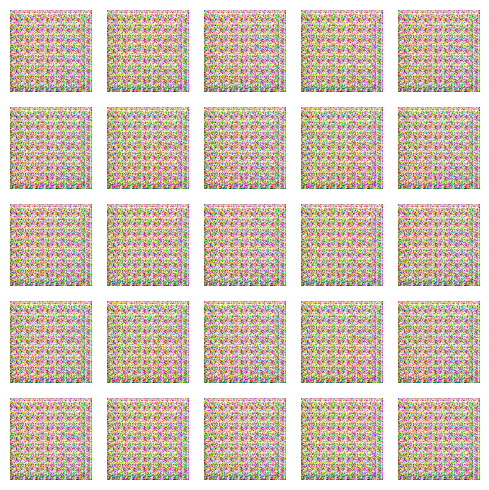

  0%|          | 0/500 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step


  0%|          | 1/500 [00:03<27:57,  3.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 708ms/step


  0%|          | 2/500 [00:07<34:07,  4.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 517ms/step


  1%|          | 3/500 [00:11<30:11,  3.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step


  1%|          | 4/500 [00:14<28:20,  3.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


  1%|          | 5/500 [00:17<26:56,  3.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step


  1%|          | 6/500 [00:21<28:45,  3.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 737ms/step


  1%|▏         | 7/500 [00:25<30:53,  3.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step


  2%|▏         | 8/500 [00:28<29:03,  3.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


  2%|▏         | 9/500 [00:31<27:31,  3.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step


  2%|▏         | 10/500 [00:35<28:06,  3.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 741ms/step


  2%|▏         | 11/500 [00:39<31:21,  3.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


  2%|▏         | 12/500 [00:42<28:53,  3.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step


  3%|▎         | 13/500 [00:45<27:10,  3.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


  3%|▎         | 14/500 [00:48<25:44,  3.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


  3%|▎         | 15/500 [00:52<26:59,  3.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 688ms/step


  3%|▎         | 16/500 [00:55<27:52,  3.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step


  3%|▎         | 17/500 [00:58<26:08,  3.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step


  4%|▎         | 18/500 [01:01<25:44,  3.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step


  4%|▍         | 19/500 [01:05<26:24,  3.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 760ms/step


  4%|▍         | 20/500 [01:09<29:56,  3.74s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step


  4%|▍         | 21/500 [01:12<27:56,  3.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


  4%|▍         | 22/500 [01:15<26:25,  3.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


  5%|▍         | 23/500 [01:18<24:43,  3.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step


  5%|▍         | 24/500 [01:22<26:48,  3.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 696ms/step


  5%|▌         | 25/500 [01:26<28:07,  3.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step


  5%|▌         | 26/500 [01:29<26:42,  3.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


  5%|▌         | 27/500 [01:32<25:59,  3.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step


  6%|▌         | 28/500 [01:35<25:36,  3.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 688ms/step


  6%|▌         | 29/500 [01:40<29:47,  3.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


  6%|▌         | 30/500 [01:43<27:34,  3.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step


  6%|▌         | 31/500 [01:46<26:03,  3.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


  6%|▋         | 32/500 [01:49<24:51,  3.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step


  7%|▋         | 33/500 [01:53<26:50,  3.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 698ms/step


  7%|▋         | 34/500 [01:57<27:27,  3.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step


  7%|▋         | 35/500 [02:00<25:59,  3.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step


  7%|▋         | 36/500 [02:03<25:29,  3.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step


  7%|▋         | 37/500 [02:06<25:29,  3.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 743ms/step


  8%|▊         | 38/500 [02:11<28:31,  3.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step


  8%|▊         | 39/500 [02:14<27:19,  3.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step


  8%|▊         | 40/500 [02:17<25:45,  3.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


  8%|▊         | 41/500 [02:20<25:17,  3.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


  8%|▊         | 42/500 [02:24<26:57,  3.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 733ms/step


  9%|▊         | 43/500 [02:28<28:00,  3.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step


  9%|▉         | 44/500 [02:31<26:32,  3.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step


  9%|▉         | 45/500 [02:34<25:23,  3.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step


  9%|▉         | 46/500 [02:38<25:29,  3.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 681ms/step


  9%|▉         | 47/500 [02:42<28:28,  3.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step


 10%|▉         | 48/500 [02:45<27:03,  3.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step


 10%|▉         | 49/500 [02:48<25:30,  3.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step


 10%|█         | 50/500 [02:51<24:30,  3.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 10%|█         | 51/500 [02:55<26:32,  3.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 727ms/step


 10%|█         | 52/500 [02:59<26:29,  3.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step


 11%|█         | 53/500 [03:02<24:24,  3.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step


 11%|█         | 54/500 [03:05<23:59,  3.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step


 11%|█         | 55/500 [03:08<24:52,  3.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 716ms/step


 11%|█         | 56/500 [03:13<26:43,  3.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step


 11%|█▏        | 57/500 [03:16<25:23,  3.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step


 12%|█▏        | 58/500 [03:19<24:51,  3.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step


 12%|█▏        | 59/500 [03:22<24:25,  3.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step


 12%|█▏        | 60/500 [03:26<26:36,  3.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 773ms/step


 12%|█▏        | 61/500 [03:30<26:31,  3.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step


 12%|█▏        | 62/500 [03:33<25:09,  3.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step


 13%|█▎        | 63/500 [03:36<24:16,  3.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step


 13%|█▎        | 64/500 [03:40<24:58,  3.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 755ms/step


 13%|█▎        | 65/500 [03:44<26:57,  3.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 13%|█▎        | 66/500 [03:47<25:10,  3.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step


 13%|█▎        | 67/500 [03:50<24:15,  3.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


 14%|█▎        | 68/500 [03:53<23:14,  3.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 697ms/step


 14%|█▍        | 69/500 [03:58<26:00,  3.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 689ms/step


 14%|█▍        | 70/500 [04:01<25:05,  3.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step


 14%|█▍        | 71/500 [04:04<24:30,  3.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step


 14%|█▍        | 72/500 [04:07<23:43,  3.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step


 15%|█▍        | 73/500 [04:12<25:41,  3.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step


 15%|█▍        | 74/500 [04:15<26:01,  3.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step


 15%|█▌        | 75/500 [04:18<24:40,  3.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step


 15%|█▌        | 76/500 [04:21<23:34,  3.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


 15%|█▌        | 77/500 [04:24<22:46,  3.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 711ms/step


 16%|█▌        | 78/500 [04:30<26:44,  3.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step


 16%|█▌        | 79/500 [04:33<25:04,  3.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 16%|█▌        | 80/500 [04:35<23:41,  3.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step


 16%|█▌        | 81/500 [04:38<22:44,  3.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step


 16%|█▋        | 82/500 [04:43<25:11,  3.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 706ms/step


 17%|█▋        | 83/500 [04:46<24:47,  3.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step


 17%|█▋        | 84/500 [04:49<23:23,  3.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step


 17%|█▋        | 85/500 [04:52<22:23,  3.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step


 17%|█▋        | 86/500 [04:55<22:01,  3.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 744ms/step


 17%|█▋        | 87/500 [05:00<25:26,  3.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step


 18%|█▊        | 88/500 [05:03<24:26,  3.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step


 18%|█▊        | 89/500 [05:07<23:26,  3.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step


 18%|█▊        | 90/500 [05:10<22:42,  3.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step


 18%|█▊        | 91/500 [05:14<24:02,  3.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 719ms/step


 18%|█▊        | 92/500 [05:17<24:36,  3.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


 19%|█▊        | 93/500 [05:21<23:28,  3.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step


 19%|█▉        | 94/500 [05:24<22:50,  3.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


 19%|█▉        | 95/500 [05:27<23:36,  3.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 849ms/step


 19%|█▉        | 96/500 [05:33<27:32,  4.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 825ms/step


 19%|█▉        | 97/500 [05:37<27:18,  4.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step


 20%|█▉        | 98/500 [05:40<25:27,  3.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step


 20%|█▉        | 99/500 [05:43<23:33,  3.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step


 20%|██        | 100/500 [05:47<24:00,  3.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 720ms/step


 20%|██        | 101/500 [05:51<24:57,  3.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step


 20%|██        | 102/500 [05:54<23:21,  3.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step


 21%|██        | 103/500 [05:57<22:06,  3.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


 21%|██        | 104/500 [06:00<20:52,  3.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step


 21%|██        | 105/500 [06:04<22:44,  3.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 722ms/step


 21%|██        | 106/500 [06:08<23:50,  3.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step


 21%|██▏       | 107/500 [06:11<22:53,  3.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 22%|██▏       | 108/500 [06:14<22:05,  3.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step


 22%|██▏       | 109/500 [06:17<22:04,  3.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step


 22%|██▏       | 110/500 [06:22<24:28,  3.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step


 22%|██▏       | 111/500 [06:25<22:43,  3.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step


 22%|██▏       | 112/500 [06:28<21:26,  3.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step


 23%|██▎       | 113/500 [06:31<20:33,  3.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step


 23%|██▎       | 114/500 [06:35<22:24,  3.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 743ms/step


 23%|██▎       | 115/500 [06:39<23:30,  3.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step


 23%|██▎       | 116/500 [06:42<21:47,  3.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step


 23%|██▎       | 117/500 [06:45<20:58,  3.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


 24%|██▎       | 118/500 [06:48<21:38,  3.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 762ms/step


 24%|██▍       | 119/500 [06:53<23:18,  3.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


 24%|██▍       | 120/500 [06:56<21:27,  3.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step


 24%|██▍       | 121/500 [06:58<20:31,  3.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step


 24%|██▍       | 122/500 [07:02<20:25,  3.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step


 25%|██▍       | 123/500 [07:06<22:27,  3.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 741ms/step


 25%|██▍       | 124/500 [07:10<22:50,  3.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step


 25%|██▌       | 125/500 [07:13<21:55,  3.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


 25%|██▌       | 126/500 [07:16<20:19,  3.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


 25%|██▌       | 127/500 [07:19<20:58,  3.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 694ms/step


 26%|██▌       | 128/500 [07:24<22:56,  3.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


 26%|██▌       | 129/500 [07:27<21:41,  3.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step


 26%|██▌       | 130/500 [07:30<20:35,  3.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


 26%|██▌       | 131/500 [07:33<20:13,  3.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 686ms/step


 26%|██▋       | 132/500 [07:38<23:37,  3.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step


 27%|██▋       | 133/500 [07:41<22:28,  3.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


 27%|██▋       | 134/500 [07:44<21:02,  3.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


 27%|██▋       | 135/500 [07:47<20:06,  3.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step


 27%|██▋       | 136/500 [07:52<22:07,  3.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 689ms/step


 27%|██▋       | 137/500 [07:56<22:27,  3.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


 28%|██▊       | 138/500 [07:59<21:10,  3.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step


 28%|██▊       | 139/500 [08:02<20:20,  3.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


 28%|██▊       | 140/500 [08:05<21:00,  3.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 718ms/step


 28%|██▊       | 141/500 [08:10<22:04,  3.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step


 28%|██▊       | 142/500 [08:13<20:42,  3.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step


 29%|██▊       | 143/500 [08:16<19:39,  3.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step


 29%|██▉       | 144/500 [08:19<19:50,  3.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 719ms/step


 29%|██▉       | 145/500 [08:24<22:21,  3.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step


 29%|██▉       | 146/500 [08:27<20:46,  3.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step


 29%|██▉       | 147/500 [08:30<20:02,  3.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step


 30%|██▉       | 148/500 [08:33<19:18,  3.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step


 30%|██▉       | 149/500 [08:37<21:08,  3.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 687ms/step


 30%|███       | 150/500 [08:41<21:20,  3.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step


 30%|███       | 151/500 [08:44<20:16,  3.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step


 30%|███       | 152/500 [08:47<19:13,  3.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


 31%|███       | 153/500 [08:50<19:20,  3.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 696ms/step


 31%|███       | 154/500 [08:55<21:15,  3.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step


 31%|███       | 155/500 [08:58<19:55,  3.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step


 31%|███       | 156/500 [09:01<19:08,  3.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step


 31%|███▏      | 157/500 [09:04<18:46,  3.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 766ms/step


 32%|███▏      | 158/500 [09:09<22:04,  3.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step


 32%|███▏      | 159/500 [09:12<20:35,  3.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


 32%|███▏      | 160/500 [09:15<19:24,  3.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step


 32%|███▏      | 161/500 [09:18<18:46,  3.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step


 32%|███▏      | 162/500 [09:23<20:21,  3.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 648ms/step


 33%|███▎      | 163/500 [09:27<20:48,  3.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step


 33%|███▎      | 164/500 [09:29<19:22,  3.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step


 33%|███▎      | 165/500 [09:32<18:37,  3.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step


 33%|███▎      | 166/500 [09:35<17:40,  3.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 732ms/step


 33%|███▎      | 167/500 [09:41<21:09,  3.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step


 34%|███▎      | 168/500 [09:44<19:45,  3.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step


 34%|███▍      | 169/500 [09:47<18:37,  3.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step


 34%|███▍      | 170/500 [09:49<17:39,  3.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step


 34%|███▍      | 171/500 [09:53<19:02,  3.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 664ms/step


 34%|███▍      | 172/500 [09:57<19:16,  3.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 35%|███▍      | 173/500 [10:00<18:14,  3.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step


 35%|███▍      | 174/500 [10:03<17:46,  3.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step


 35%|███▌      | 175/500 [10:07<18:05,  3.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 729ms/step


 35%|███▌      | 176/500 [10:11<20:09,  3.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step


 35%|███▌      | 177/500 [10:14<19:04,  3.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step


 36%|███▌      | 178/500 [10:17<18:01,  3.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step


 36%|███▌      | 179/500 [10:20<17:33,  3.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step


 36%|███▌      | 180/500 [10:25<19:15,  3.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 743ms/step


 36%|███▌      | 181/500 [10:28<19:18,  3.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step


 36%|███▋      | 182/500 [10:31<18:11,  3.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step


 37%|███▋      | 183/500 [10:34<17:35,  3.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step


 37%|███▋      | 184/500 [10:38<18:19,  3.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 757ms/step


 37%|███▋      | 185/500 [10:43<19:36,  3.74s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 37%|███▋      | 186/500 [10:46<18:32,  3.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step


 37%|███▋      | 187/500 [10:49<17:43,  3.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


 38%|███▊      | 188/500 [10:52<17:23,  3.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 685ms/step


 38%|███▊      | 189/500 [10:57<19:51,  3.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step


 38%|███▊      | 190/500 [11:00<18:17,  3.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step


 38%|███▊      | 191/500 [11:03<17:27,  3.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


 38%|███▊      | 192/500 [11:06<16:33,  3.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step


 39%|███▊      | 193/500 [11:10<18:03,  3.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 684ms/step


 39%|███▉      | 194/500 [11:14<18:17,  3.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step


 39%|███▉      | 195/500 [11:16<16:59,  3.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step


 39%|███▉      | 196/500 [11:19<16:14,  3.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step


 39%|███▉      | 197/500 [11:22<15:34,  3.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step


 40%|███▉      | 198/500 [11:26<17:11,  3.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 730ms/step


 40%|███▉      | 199/500 [11:30<17:23,  3.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


 40%|████      | 200/500 [11:33<16:35,  3.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


 40%|████      | 201/500 [11:36<16:16,  3.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step


 40%|████      | 202/500 [11:40<17:15,  3.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 725ms/step


 41%|████      | 203/500 [11:44<18:27,  3.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step


 41%|████      | 204/500 [11:47<17:24,  3.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step


 41%|████      | 205/500 [11:50<16:25,  3.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step


 41%|████      | 206/500 [11:53<16:06,  3.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 740ms/step


 41%|████▏     | 207/500 [11:58<18:30,  3.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step


 42%|████▏     | 208/500 [12:01<17:13,  3.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 42%|████▏     | 209/500 [12:04<16:13,  3.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step


 42%|████▏     | 210/500 [12:07<16:00,  3.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step


 42%|████▏     | 211/500 [12:12<17:33,  3.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 722ms/step


 42%|████▏     | 212/500 [12:15<17:16,  3.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


 43%|████▎     | 213/500 [12:18<16:13,  3.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step


 43%|████▎     | 214/500 [12:22<15:53,  3.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


 43%|████▎     | 215/500 [12:25<15:45,  3.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 715ms/step


 43%|████▎     | 216/500 [12:30<17:52,  3.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step


 43%|████▎     | 217/500 [12:33<16:42,  3.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step


 44%|████▎     | 218/500 [12:36<16:13,  3.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step


 44%|████▍     | 219/500 [12:39<15:56,  3.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 759ms/step


 44%|████▍     | 220/500 [12:44<18:20,  3.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 776ms/step


 44%|████▍     | 221/500 [12:49<19:07,  4.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 762ms/step


 44%|████▍     | 222/500 [12:53<18:25,  3.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


 45%|████▍     | 223/500 [12:56<17:15,  3.74s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step


 45%|████▍     | 224/500 [13:00<18:07,  3.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step


 45%|████▌     | 225/500 [13:03<17:00,  3.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step


 45%|████▌     | 226/500 [13:06<16:11,  3.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step


 45%|████▌     | 227/500 [13:10<15:40,  3.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 513ms/step


 46%|████▌     | 228/500 [13:14<17:07,  3.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 677ms/step


 46%|████▌     | 229/500 [13:18<16:31,  3.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step


 46%|████▌     | 230/500 [13:21<15:42,  3.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


 46%|████▌     | 231/500 [13:24<14:57,  3.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step


 46%|████▋     | 232/500 [13:27<15:12,  3.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 723ms/step


 47%|████▋     | 233/500 [13:32<16:33,  3.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step


 47%|████▋     | 234/500 [13:35<15:52,  3.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step


 47%|████▋     | 235/500 [13:38<15:08,  3.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step


 47%|████▋     | 236/500 [13:41<14:47,  3.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 743ms/step


 47%|████▋     | 237/500 [13:47<17:20,  3.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step


 48%|████▊     | 238/500 [13:50<16:08,  3.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step


 48%|████▊     | 239/500 [13:53<15:11,  3.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step


 48%|████▊     | 240/500 [13:56<14:31,  3.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step


 48%|████▊     | 241/500 [14:00<15:55,  3.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 757ms/step


 48%|████▊     | 242/500 [14:04<16:06,  3.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step


 49%|████▊     | 243/500 [14:07<15:13,  3.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step


 49%|████▉     | 244/500 [14:10<14:26,  3.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step


 49%|████▉     | 245/500 [14:14<15:16,  3.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 700ms/step


 49%|████▉     | 246/500 [14:18<15:38,  3.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step


 49%|████▉     | 247/500 [14:21<15:01,  3.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step


 50%|████▉     | 248/500 [14:25<14:32,  3.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step


 50%|████▉     | 249/500 [14:28<14:23,  3.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 706ms/step


 50%|█████     | 250/500 [14:33<16:14,  3.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


 50%|█████     | 251/500 [14:36<15:16,  3.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


 50%|█████     | 252/500 [14:39<14:23,  3.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


 51%|█████     | 253/500 [14:42<13:46,  3.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 525ms/step


 51%|█████     | 254/500 [14:47<15:21,  3.74s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 762ms/step


 51%|█████     | 255/500 [14:50<15:06,  3.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step


 51%|█████     | 256/500 [14:53<14:07,  3.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step


 51%|█████▏    | 257/500 [14:56<13:27,  3.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step


 52%|█████▏    | 258/500 [15:00<13:48,  3.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 730ms/step


 52%|█████▏    | 259/500 [15:04<14:58,  3.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step


 52%|█████▏    | 260/500 [15:08<14:06,  3.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step


 52%|█████▏    | 261/500 [15:10<13:20,  3.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


 52%|█████▏    | 262/500 [15:14<12:55,  3.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step


 53%|█████▎    | 263/500 [15:18<14:06,  3.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 735ms/step


 53%|█████▎    | 264/500 [15:21<14:03,  3.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


 53%|█████▎    | 265/500 [15:24<13:13,  3.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step


 53%|█████▎    | 266/500 [15:27<12:47,  3.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step


 53%|█████▎    | 267/500 [15:31<13:15,  3.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step


 54%|█████▎    | 268/500 [15:35<14:14,  3.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step


 54%|█████▍    | 269/500 [15:38<13:10,  3.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step


 54%|█████▍    | 270/500 [15:41<12:40,  3.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step


 54%|█████▍    | 271/500 [15:45<12:31,  3.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 668ms/step


 54%|█████▍    | 272/500 [15:50<14:29,  3.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step


 55%|█████▍    | 273/500 [15:52<13:21,  3.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step


 55%|█████▍    | 274/500 [15:56<12:57,  3.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step


 55%|█████▌    | 275/500 [15:59<12:22,  3.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step


 55%|█████▌    | 276/500 [16:03<13:30,  3.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 727ms/step


 55%|█████▌    | 277/500 [16:07<13:47,  3.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step


 56%|█████▌    | 278/500 [16:10<13:10,  3.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step


 56%|█████▌    | 279/500 [16:13<12:27,  3.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step


 56%|█████▌    | 280/500 [16:17<12:48,  3.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/step


 56%|█████▌    | 281/500 [16:21<13:07,  3.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step


 56%|█████▋    | 282/500 [16:23<12:08,  3.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


 57%|█████▋    | 283/500 [16:26<11:38,  3.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step


 57%|█████▋    | 284/500 [16:29<11:15,  3.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step


 57%|█████▋    | 285/500 [16:34<12:23,  3.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 771ms/step


 57%|█████▋    | 286/500 [16:37<12:40,  3.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step


 57%|█████▋    | 287/500 [16:40<12:05,  3.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 58%|█████▊    | 288/500 [16:43<11:37,  3.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step


 58%|█████▊    | 289/500 [16:47<12:05,  3.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 697ms/step


 58%|█████▊    | 290/500 [16:51<12:43,  3.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step


 58%|█████▊    | 291/500 [16:54<11:47,  3.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 58%|█████▊    | 292/500 [16:57<11:22,  3.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


 59%|█████▊    | 293/500 [17:00<11:03,  3.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step


 59%|█████▉    | 294/500 [17:05<12:19,  3.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 761ms/step


 59%|█████▉    | 295/500 [17:08<12:20,  3.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step


 59%|█████▉    | 296/500 [17:11<11:43,  3.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step


 59%|█████▉    | 297/500 [17:14<11:07,  3.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


 60%|█████▉    | 298/500 [17:18<11:30,  3.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 750ms/step


 60%|█████▉    | 299/500 [17:23<12:41,  3.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


 60%|██████    | 300/500 [17:26<11:52,  3.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step


 60%|██████    | 301/500 [17:29<11:20,  3.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step


 60%|██████    | 302/500 [17:32<11:09,  3.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 701ms/step


 61%|██████    | 303/500 [17:37<12:45,  3.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step


 61%|██████    | 304/500 [17:40<11:57,  3.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step


 61%|██████    | 305/500 [17:43<11:19,  3.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step


 61%|██████    | 306/500 [17:46<10:52,  3.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step


 61%|██████▏   | 307/500 [17:51<11:55,  3.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 676ms/step


 62%|██████▏   | 308/500 [17:54<11:41,  3.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


 62%|██████▏   | 309/500 [17:57<10:52,  3.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


 62%|██████▏   | 310/500 [18:00<10:09,  3.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


 62%|██████▏   | 311/500 [18:03<10:08,  3.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 695ms/step


 62%|██████▏   | 312/500 [18:08<11:33,  3.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step


 63%|██████▎   | 313/500 [18:11<10:36,  3.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step


 63%|██████▎   | 314/500 [18:14<10:16,  3.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


 63%|██████▎   | 315/500 [18:17<09:58,  3.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step


 63%|██████▎   | 316/500 [18:21<11:07,  3.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 696ms/step


 63%|██████▎   | 317/500 [18:26<12:01,  3.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step


 64%|██████▎   | 318/500 [18:29<11:11,  3.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step


 64%|██████▍   | 319/500 [18:32<10:38,  3.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step


 64%|██████▍   | 320/500 [18:37<11:09,  3.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 723ms/step


 64%|██████▍   | 321/500 [18:40<11:00,  3.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step


 64%|██████▍   | 322/500 [18:43<10:20,  3.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


 65%|██████▍   | 323/500 [18:46<10:02,  3.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step


 65%|██████▍   | 324/500 [18:50<10:07,  3.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 700ms/step


 65%|██████▌   | 325/500 [18:54<10:57,  3.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step


 65%|██████▌   | 326/500 [18:58<10:18,  3.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step


 65%|██████▌   | 327/500 [19:00<09:40,  3.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step


 66%|██████▌   | 328/500 [19:03<09:17,  3.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 736ms/step


 66%|██████▌   | 329/500 [19:08<10:48,  3.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step


 66%|██████▌   | 330/500 [19:11<10:02,  3.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step


 66%|██████▌   | 331/500 [19:14<09:31,  3.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step


 66%|██████▋   | 332/500 [19:17<09:06,  3.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step


 67%|██████▋   | 333/500 [19:21<09:44,  3.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 668ms/step


 67%|██████▋   | 334/500 [19:25<09:50,  3.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step


 67%|██████▋   | 335/500 [19:28<09:13,  3.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step


 67%|██████▋   | 336/500 [19:31<08:57,  3.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step


 67%|██████▋   | 337/500 [19:35<09:27,  3.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 751ms/step


 68%|██████▊   | 338/500 [19:39<10:04,  3.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step


 68%|██████▊   | 339/500 [19:42<09:22,  3.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


 68%|██████▊   | 340/500 [19:45<08:48,  3.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


 68%|██████▊   | 341/500 [19:48<08:33,  3.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step


 68%|██████▊   | 342/500 [19:53<09:20,  3.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 722ms/step


 69%|██████▊   | 343/500 [19:56<09:19,  3.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 69%|██████▉   | 344/500 [19:59<08:35,  3.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step


 69%|██████▉   | 345/500 [20:03<09:01,  3.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 720ms/step


 69%|██████▉   | 346/500 [20:08<10:00,  3.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step


 69%|██████▉   | 347/500 [20:12<10:27,  4.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step


 70%|██████▉   | 348/500 [20:15<09:25,  3.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


 70%|██████▉   | 349/500 [20:18<08:57,  3.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step


 70%|███████   | 350/500 [20:22<08:55,  3.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step


 70%|███████   | 351/500 [20:27<09:44,  3.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step


 70%|███████   | 352/500 [20:30<09:07,  3.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


 71%|███████   | 353/500 [20:33<08:38,  3.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step


 71%|███████   | 354/500 [20:36<08:29,  3.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 732ms/step


 71%|███████   | 355/500 [20:41<09:34,  3.96s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step


 71%|███████   | 356/500 [20:45<08:56,  3.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step


 71%|███████▏  | 357/500 [20:48<08:25,  3.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step


 72%|███████▏  | 358/500 [20:51<08:00,  3.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 72%|███████▏  | 359/500 [20:55<08:44,  3.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 772ms/step


 72%|███████▏  | 360/500 [20:59<08:33,  3.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step


 72%|███████▏  | 361/500 [21:01<07:49,  3.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step


 72%|███████▏  | 362/500 [21:04<07:23,  3.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


 73%|███████▎  | 363/500 [21:08<07:40,  3.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 686ms/step


 73%|███████▎  | 364/500 [21:13<08:33,  3.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step


 73%|███████▎  | 365/500 [21:16<07:54,  3.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step


 73%|███████▎  | 366/500 [21:19<07:30,  3.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step


 73%|███████▎  | 367/500 [21:22<07:20,  3.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 671ms/step


 74%|███████▎  | 368/500 [21:27<08:23,  3.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step


 74%|███████▍  | 369/500 [21:30<07:47,  3.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step


 74%|███████▍  | 370/500 [21:33<07:22,  3.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step


 74%|███████▍  | 371/500 [21:36<07:07,  3.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step


 74%|███████▍  | 372/500 [21:40<07:46,  3.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 726ms/step


 75%|███████▍  | 373/500 [21:44<07:49,  3.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step


 75%|███████▍  | 374/500 [21:47<07:20,  3.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step


 75%|███████▌  | 375/500 [21:50<07:06,  3.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step


 75%|███████▌  | 376/500 [21:54<07:10,  3.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 709ms/step


 75%|███████▌  | 377/500 [21:58<07:44,  3.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step


 76%|███████▌  | 378/500 [22:01<07:00,  3.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step


 76%|███████▌  | 379/500 [22:04<06:38,  3.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step


 76%|███████▌  | 380/500 [22:07<06:28,  3.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 707ms/step


 76%|███████▌  | 381/500 [22:12<07:34,  3.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


 76%|███████▋  | 382/500 [22:15<07:03,  3.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


 77%|███████▋  | 383/500 [22:18<06:38,  3.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


 77%|███████▋  | 384/500 [22:22<06:25,  3.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


 77%|███████▋  | 385/500 [22:26<06:53,  3.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 752ms/step


 77%|███████▋  | 386/500 [22:30<06:57,  3.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


 77%|███████▋  | 387/500 [22:33<06:31,  3.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step


 78%|███████▊  | 388/500 [22:36<06:11,  3.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step


 78%|███████▊  | 389/500 [22:39<06:09,  3.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 681ms/step


 78%|███████▊  | 390/500 [22:44<06:53,  3.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step


 78%|███████▊  | 391/500 [22:47<06:36,  3.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step


 78%|███████▊  | 392/500 [22:50<06:17,  3.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


 79%|███████▊  | 393/500 [22:53<06:06,  3.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 661ms/step


 79%|███████▉  | 394/500 [22:58<06:50,  3.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step


 79%|███████▉  | 395/500 [23:01<06:11,  3.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step


 79%|███████▉  | 396/500 [23:04<05:55,  3.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


 79%|███████▉  | 397/500 [23:07<05:30,  3.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step


 80%|███████▉  | 398/500 [23:11<05:48,  3.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 725ms/step


 80%|███████▉  | 399/500 [23:15<06:00,  3.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


 80%|████████  | 400/500 [23:18<05:32,  3.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step


 80%|████████  | 401/500 [23:20<05:16,  3.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step


 80%|████████  | 402/500 [23:23<05:07,  3.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


 81%|████████  | 403/500 [23:28<05:42,  3.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 685ms/step


 81%|████████  | 404/500 [23:31<05:40,  3.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


 81%|████████  | 405/500 [23:34<05:17,  3.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step


 81%|████████  | 406/500 [23:37<05:06,  3.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step


 81%|████████▏ | 407/500 [23:41<05:19,  3.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 697ms/step


 82%|████████▏ | 408/500 [23:46<05:45,  3.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


 82%|████████▏ | 409/500 [23:49<05:25,  3.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step


 82%|████████▏ | 410/500 [23:52<05:05,  3.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step


 82%|████████▏ | 411/500 [23:55<05:02,  3.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 687ms/step


 82%|████████▏ | 412/500 [24:00<05:38,  3.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 83%|████████▎ | 413/500 [24:03<05:16,  3.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step


 83%|████████▎ | 414/500 [24:06<04:56,  3.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step


 83%|████████▎ | 415/500 [24:10<04:48,  3.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 698ms/step


 83%|████████▎ | 416/500 [24:15<05:25,  3.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


 83%|████████▎ | 417/500 [24:18<05:05,  3.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step


 84%|████████▎ | 418/500 [24:21<04:47,  3.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step


 84%|████████▍ | 419/500 [24:24<04:34,  3.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step


 84%|████████▍ | 420/500 [24:28<04:55,  3.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 686ms/step


 84%|████████▍ | 421/500 [24:32<04:51,  3.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step


 84%|████████▍ | 422/500 [24:35<04:36,  3.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step


 85%|████████▍ | 423/500 [24:38<04:20,  3.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step


 85%|████████▍ | 424/500 [24:42<04:18,  3.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 670ms/step


 85%|████████▌ | 425/500 [24:46<04:40,  3.74s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step


 85%|████████▌ | 426/500 [24:49<04:22,  3.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step


 85%|████████▌ | 427/500 [24:52<04:07,  3.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


 86%|████████▌ | 428/500 [24:55<03:50,  3.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


 86%|████████▌ | 429/500 [24:59<04:07,  3.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step


 86%|████████▌ | 430/500 [25:03<04:09,  3.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step


 86%|████████▌ | 431/500 [25:06<03:56,  3.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step


 86%|████████▋ | 432/500 [25:09<03:45,  3.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step


 87%|████████▋ | 433/500 [25:13<03:55,  3.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 759ms/step


 87%|████████▋ | 434/500 [25:17<04:05,  3.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step


 87%|████████▋ | 435/500 [25:20<03:47,  3.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step


 87%|████████▋ | 436/500 [25:24<03:37,  3.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


 87%|████████▋ | 437/500 [25:27<03:29,  3.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 697ms/step


 88%|████████▊ | 438/500 [25:31<03:49,  3.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 88%|████████▊ | 439/500 [25:34<03:32,  3.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step


 88%|████████▊ | 440/500 [25:37<03:21,  3.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step


 88%|████████▊ | 441/500 [25:41<03:15,  3.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step


 88%|████████▊ | 442/500 [25:44<03:20,  3.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 696ms/step


 89%|████████▊ | 443/500 [25:49<03:30,  3.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 89%|████████▉ | 444/500 [25:52<03:14,  3.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


 89%|████████▉ | 445/500 [25:54<03:02,  3.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step


 89%|████████▉ | 446/500 [25:58<02:56,  3.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 703ms/step


 89%|████████▉ | 447/500 [26:02<03:15,  3.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step


 90%|████████▉ | 448/500 [26:05<03:02,  3.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step


 90%|████████▉ | 449/500 [26:09<02:54,  3.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step


 90%|█████████ | 450/500 [26:12<02:44,  3.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step


 90%|█████████ | 451/500 [26:16<02:55,  3.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 733ms/step


 90%|█████████ | 452/500 [26:19<02:51,  3.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step


 91%|█████████ | 453/500 [26:23<02:41,  3.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step


 91%|█████████ | 454/500 [26:26<02:32,  3.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step


 91%|█████████ | 455/500 [26:29<02:33,  3.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 654ms/step


 91%|█████████ | 456/500 [26:34<02:42,  3.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step


 91%|█████████▏| 457/500 [26:37<02:32,  3.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step


 92%|█████████▏| 458/500 [26:40<02:22,  3.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step


 92%|█████████▏| 459/500 [26:43<02:22,  3.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 706ms/step


 92%|█████████▏| 460/500 [26:48<02:35,  3.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step


 92%|█████████▏| 461/500 [26:51<02:20,  3.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step


 92%|█████████▏| 462/500 [26:54<02:12,  3.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step


 93%|█████████▎| 463/500 [26:57<02:03,  3.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 742ms/step


 93%|█████████▎| 464/500 [27:02<02:17,  3.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step


 93%|█████████▎| 465/500 [27:06<02:07,  3.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step


 93%|█████████▎| 466/500 [27:09<01:57,  3.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step


 93%|█████████▎| 467/500 [27:12<01:51,  3.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


 94%|█████████▎| 468/500 [27:16<01:55,  3.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 797ms/step


 94%|█████████▍| 469/500 [27:21<02:05,  4.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step


 94%|█████████▍| 470/500 [27:25<02:01,  4.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step


 94%|█████████▍| 471/500 [27:28<01:46,  3.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


 94%|█████████▍| 472/500 [27:31<01:39,  3.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 728ms/step


 95%|█████████▍| 473/500 [27:36<01:48,  4.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step


 95%|█████████▍| 474/500 [27:39<01:38,  3.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step


 95%|█████████▌| 475/500 [27:42<01:27,  3.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step


 95%|█████████▌| 476/500 [27:45<01:21,  3.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


 95%|█████████▌| 477/500 [27:50<01:24,  3.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 779ms/step


 96%|█████████▌| 478/500 [27:53<01:19,  3.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


 96%|█████████▌| 479/500 [27:56<01:11,  3.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step


 96%|█████████▌| 480/500 [27:59<01:05,  3.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step


 96%|█████████▌| 481/500 [28:02<01:01,  3.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 670ms/step


 96%|█████████▋| 482/500 [28:07<01:06,  3.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


 97%|█████████▋| 483/500 [28:10<00:59,  3.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step


 97%|█████████▋| 484/500 [28:13<00:54,  3.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step


 97%|█████████▋| 485/500 [28:16<00:48,  3.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step


 97%|█████████▋| 486/500 [28:21<00:50,  3.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 700ms/step


 97%|█████████▋| 487/500 [28:24<00:46,  3.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step


 98%|█████████▊| 488/500 [28:28<00:41,  3.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step


 98%|█████████▊| 489/500 [28:31<00:37,  3.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step


 98%|█████████▊| 490/500 [28:35<00:35,  3.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 729ms/step


 98%|█████████▊| 491/500 [28:39<00:33,  3.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step


 98%|█████████▊| 492/500 [28:42<00:28,  3.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


 99%|█████████▊| 493/500 [28:45<00:23,  3.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step


 99%|█████████▉| 494/500 [28:49<00:20,  3.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 715ms/step


 99%|█████████▉| 495/500 [28:53<00:18,  3.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step


 99%|█████████▉| 496/500 [28:56<00:14,  3.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 99%|█████████▉| 497/500 [28:59<00:10,  3.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step


100%|█████████▉| 498/500 [29:02<00:06,  3.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 718ms/step


100%|█████████▉| 499/500 [29:07<00:03,  3.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 677ms/step


100%|██████████| 500/500 [29:10<00:00,  3.50s/it]


Epoch: 3 	 Discriminator Loss: 0.6534917950630188 		 Generator Loss: [array(0.6534918), array(0.6534918), array(0.6534918)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


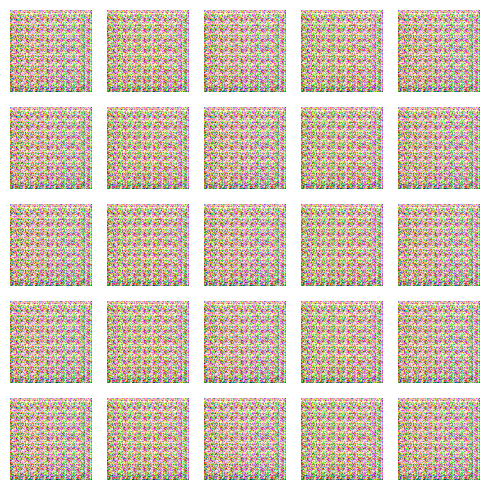

  0%|          | 0/500 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step


  0%|          | 1/500 [00:02<23:37,  2.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step


  0%|          | 2/500 [00:07<30:35,  3.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 727ms/step


  1%|          | 3/500 [00:10<30:42,  3.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step


  1%|          | 4/500 [00:13<28:23,  3.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step


  1%|          | 5/500 [00:16<26:55,  3.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step


  1%|          | 6/500 [00:20<29:01,  3.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 767ms/step


  1%|▏         | 7/500 [00:25<31:43,  3.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step


  2%|▏         | 8/500 [00:28<29:27,  3.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


  2%|▏         | 9/500 [00:31<28:30,  3.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step


  2%|▏         | 10/500 [00:35<29:24,  3.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 716ms/step


  2%|▏         | 11/500 [00:39<31:27,  3.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step


  2%|▏         | 12/500 [00:43<29:39,  3.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step


  3%|▎         | 13/500 [00:46<28:06,  3.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


  3%|▎         | 14/500 [00:49<27:04,  3.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step


  3%|▎         | 15/500 [00:53<29:30,  3.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 716ms/step


  3%|▎         | 16/500 [00:57<29:16,  3.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step


  3%|▎         | 17/500 [01:00<27:23,  3.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step


  4%|▎         | 18/500 [01:03<26:44,  3.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step


  4%|▍         | 19/500 [01:07<28:10,  3.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 757ms/step


  4%|▍         | 20/500 [01:11<29:40,  3.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


  4%|▍         | 21/500 [01:14<28:04,  3.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step


  4%|▍         | 22/500 [01:17<26:56,  3.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step


  5%|▍         | 23/500 [01:20<25:31,  3.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 618ms/step


  5%|▍         | 24/500 [01:24<28:39,  3.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 789ms/step


  5%|▌         | 25/500 [01:28<28:48,  3.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


  5%|▌         | 26/500 [01:31<26:29,  3.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step


  5%|▌         | 27/500 [01:34<25:29,  3.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step


  6%|▌         | 28/500 [01:37<26:34,  3.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 687ms/step


  6%|▌         | 29/500 [01:42<28:58,  3.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step


  6%|▌         | 30/500 [01:45<27:39,  3.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


  6%|▌         | 31/500 [01:48<25:44,  3.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step


  6%|▋         | 32/500 [01:51<24:39,  3.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 641ms/step


  7%|▋         | 33/500 [01:56<29:06,  3.74s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


  7%|▋         | 34/500 [01:59<27:57,  3.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step


  7%|▋         | 35/500 [02:02<26:36,  3.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step


  7%|▋         | 36/500 [02:05<25:47,  3.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step


  7%|▋         | 37/500 [02:09<27:48,  3.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 695ms/step


  8%|▊         | 38/500 [02:13<28:09,  3.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step


  8%|▊         | 39/500 [02:16<26:58,  3.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step


  8%|▊         | 40/500 [02:19<25:12,  3.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step


  8%|▊         | 41/500 [02:23<27:04,  3.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 741ms/step


  8%|▊         | 42/500 [02:27<28:26,  3.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step


  9%|▊         | 43/500 [02:30<26:29,  3.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step


  9%|▉         | 44/500 [02:33<25:57,  3.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step


  9%|▉         | 45/500 [02:36<24:30,  3.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 666ms/step


  9%|▉         | 46/500 [02:41<28:20,  3.74s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step


  9%|▉         | 47/500 [02:44<26:13,  3.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step


 10%|▉         | 48/500 [02:47<25:22,  3.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step


 10%|▉         | 49/500 [02:50<24:34,  3.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step


 10%|█         | 50/500 [02:54<25:32,  3.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 691ms/step


 10%|█         | 51/500 [02:58<26:52,  3.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


 10%|█         | 52/500 [03:01<25:34,  3.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step


 11%|█         | 53/500 [03:04<24:41,  3.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step


 11%|█         | 54/500 [03:07<23:46,  3.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step


 11%|█         | 55/500 [03:12<26:51,  3.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 778ms/step


 11%|█         | 56/500 [03:15<26:53,  3.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step


 11%|█▏        | 57/500 [03:18<25:33,  3.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step


 12%|█▏        | 58/500 [03:22<24:58,  3.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step


 12%|█▏        | 59/500 [03:25<26:03,  3.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 690ms/step


 12%|█▏        | 60/500 [03:30<27:42,  3.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step


 12%|█▏        | 61/500 [03:33<25:48,  3.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step


 12%|█▏        | 62/500 [03:36<24:28,  3.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step


 13%|█▎        | 63/500 [03:39<24:20,  3.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/step


 13%|█▎        | 64/500 [03:44<27:37,  3.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step


 13%|█▎        | 65/500 [03:47<26:11,  3.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step


 13%|█▎        | 66/500 [03:50<24:37,  3.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step


 13%|█▎        | 67/500 [03:53<23:54,  3.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step


 14%|█▎        | 68/500 [03:58<26:18,  3.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 709ms/step


 14%|█▍        | 69/500 [04:01<26:32,  3.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step


 14%|█▍        | 70/500 [04:05<25:27,  3.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 504ms/step


 14%|█▍        | 71/500 [04:08<24:27,  3.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step


 14%|█▍        | 72/500 [04:12<26:01,  3.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 735ms/step


 15%|█▍        | 73/500 [04:16<26:17,  3.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step


 15%|█▍        | 74/500 [04:18<24:23,  3.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step


 15%|█▌        | 75/500 [04:21<23:10,  3.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step


 15%|█▌        | 76/500 [04:25<23:49,  3.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 744ms/step


 15%|█▌        | 77/500 [04:29<26:05,  3.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step


 16%|█▌        | 78/500 [04:33<25:08,  3.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step


 16%|█▌        | 79/500 [04:36<24:06,  3.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step


 16%|█▌        | 80/500 [04:39<23:00,  3.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step


 16%|█▌        | 81/500 [04:43<25:20,  3.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 756ms/step


 16%|█▋        | 82/500 [04:47<25:55,  3.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step


 17%|█▋        | 83/500 [04:50<24:32,  3.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step


 17%|█▋        | 84/500 [04:53<23:36,  3.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step


 17%|█▋        | 85/500 [04:58<25:36,  3.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 724ms/step


 17%|█▋        | 86/500 [05:01<25:24,  3.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step


 17%|█▋        | 87/500 [05:05<24:21,  3.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step


 18%|█▊        | 88/500 [05:08<23:29,  3.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step


 18%|█▊        | 89/500 [05:12<24:34,  3.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 668ms/step


 18%|█▊        | 90/500 [05:17<28:11,  4.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 746ms/step


 18%|█▊        | 91/500 [05:21<28:15,  4.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step


 18%|█▊        | 92/500 [05:24<26:06,  3.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 695ms/step


 19%|█▊        | 93/500 [05:29<28:33,  4.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step


 19%|█▉        | 94/500 [05:32<25:52,  3.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step


 19%|█▉        | 95/500 [05:35<24:11,  3.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step


 19%|█▉        | 96/500 [05:38<22:31,  3.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step


 19%|█▉        | 97/500 [05:42<23:25,  3.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 737ms/step


 20%|█▉        | 98/500 [05:46<25:16,  3.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step


 20%|█▉        | 99/500 [05:50<24:11,  3.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step


 20%|██        | 100/500 [05:53<23:05,  3.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step


 20%|██        | 101/500 [05:57<23:48,  3.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 754ms/step


 20%|██        | 102/500 [06:01<26:12,  3.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step


 21%|██        | 103/500 [06:05<24:30,  3.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step


 21%|██        | 104/500 [06:08<23:41,  3.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step


 21%|██        | 105/500 [06:11<23:11,  3.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 664ms/step


 21%|██        | 106/500 [06:16<25:31,  3.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step


 21%|██▏       | 107/500 [06:19<23:28,  3.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step


 22%|██▏       | 108/500 [06:22<22:40,  3.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


 22%|██▏       | 109/500 [06:25<21:51,  3.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step


 22%|██▏       | 110/500 [06:29<23:31,  3.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 729ms/step


 22%|██▏       | 111/500 [06:33<24:06,  3.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step


 22%|██▏       | 112/500 [06:36<22:27,  3.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


 23%|██▎       | 113/500 [06:39<20:59,  3.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step


 23%|██▎       | 114/500 [06:43<21:47,  3.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 684ms/step


 23%|██▎       | 115/500 [06:47<23:18,  3.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step


 23%|██▎       | 116/500 [06:50<22:36,  3.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step


 23%|██▎       | 117/500 [06:53<21:50,  3.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step


 24%|██▎       | 118/500 [06:57<21:15,  3.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 673ms/step


 24%|██▍       | 119/500 [07:02<24:23,  3.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step


 24%|██▍       | 120/500 [07:04<22:34,  3.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step


 24%|██▍       | 121/500 [07:07<21:14,  3.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 24%|██▍       | 122/500 [07:10<20:21,  3.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step


 25%|██▍       | 123/500 [07:14<21:20,  3.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 692ms/step


 25%|██▍       | 124/500 [07:18<22:42,  3.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step


 25%|██▌       | 125/500 [07:21<21:33,  3.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step


 25%|██▌       | 126/500 [07:24<20:50,  3.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step


 25%|██▌       | 127/500 [07:28<20:54,  3.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 651ms/step


 26%|██▌       | 128/500 [07:32<23:10,  3.74s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step


 26%|██▌       | 129/500 [07:36<22:14,  3.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


 26%|██▌       | 130/500 [07:39<21:05,  3.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step


 26%|██▌       | 131/500 [07:41<19:53,  3.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


 26%|██▋       | 132/500 [07:45<20:54,  3.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 736ms/step


 27%|██▋       | 133/500 [07:50<22:36,  3.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step


 27%|██▋       | 134/500 [07:53<21:23,  3.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step


 27%|██▋       | 135/500 [07:56<20:16,  3.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step


 27%|██▋       | 136/500 [07:59<21:01,  3.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 677ms/step


 27%|██▋       | 137/500 [08:04<22:49,  3.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


 28%|██▊       | 138/500 [08:07<21:22,  3.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step


 28%|██▊       | 139/500 [08:10<20:36,  3.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step


 28%|██▊       | 140/500 [08:13<20:05,  3.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 760ms/step


 28%|██▊       | 141/500 [08:18<23:17,  3.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step


 28%|██▊       | 142/500 [08:22<21:56,  3.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step


 29%|██▊       | 143/500 [08:25<20:39,  3.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step


 29%|██▉       | 144/500 [08:27<19:40,  3.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


 29%|██▉       | 145/500 [08:32<21:13,  3.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step


 29%|██▉       | 146/500 [08:35<21:31,  3.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


 29%|██▉       | 147/500 [08:38<20:07,  3.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step


 30%|██▉       | 148/500 [08:41<19:11,  3.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step


 30%|██▉       | 149/500 [08:44<18:43,  3.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 711ms/step


 30%|███       | 150/500 [08:50<22:11,  3.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step


 30%|███       | 151/500 [08:53<20:41,  3.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step


 30%|███       | 152/500 [08:56<20:04,  3.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


 31%|███       | 153/500 [08:59<18:54,  3.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step


 31%|███       | 154/500 [09:03<20:42,  3.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 661ms/step


 31%|███       | 155/500 [09:07<20:57,  3.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step


 31%|███       | 156/500 [09:10<19:54,  3.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


 31%|███▏      | 157/500 [09:13<19:18,  3.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


 32%|███▏      | 158/500 [09:17<20:09,  3.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 668ms/step


 32%|███▏      | 159/500 [09:21<20:44,  3.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step


 32%|███▏      | 160/500 [09:24<19:42,  3.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step


 32%|███▏      | 161/500 [09:27<18:48,  3.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step


 32%|███▏      | 162/500 [09:31<19:31,  3.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 717ms/step


 33%|███▎      | 163/500 [09:35<21:10,  3.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step


 33%|███▎      | 164/500 [09:38<19:40,  3.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step


 33%|███▎      | 165/500 [09:41<18:37,  3.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step


 33%|███▎      | 166/500 [09:44<17:34,  3.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 33%|███▎      | 167/500 [09:48<19:26,  3.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 702ms/step


 34%|███▎      | 168/500 [09:52<20:03,  3.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step


 34%|███▍      | 169/500 [09:55<19:16,  3.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step


 34%|███▍      | 170/500 [09:58<18:12,  3.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step


 34%|███▍      | 171/500 [10:01<18:08,  3.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 700ms/step


 34%|███▍      | 172/500 [10:06<19:57,  3.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step


 35%|███▍      | 173/500 [10:09<18:51,  3.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step


 35%|███▍      | 174/500 [10:12<18:17,  3.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


 35%|███▌      | 175/500 [10:15<17:55,  3.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


 35%|███▌      | 176/500 [10:19<19:29,  3.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 783ms/step


 35%|███▌      | 177/500 [10:23<19:57,  3.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step


 36%|███▌      | 178/500 [10:26<18:52,  3.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step


 36%|███▌      | 179/500 [10:29<17:23,  3.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 36%|███▌      | 180/500 [10:33<18:26,  3.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 757ms/step


 36%|███▌      | 181/500 [10:37<19:39,  3.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step


 36%|███▋      | 182/500 [10:40<18:44,  3.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step


 37%|███▋      | 183/500 [10:43<17:35,  3.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step


 37%|███▋      | 184/500 [10:46<17:16,  3.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 654ms/step


 37%|███▋      | 185/500 [10:52<20:29,  3.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step


 37%|███▋      | 186/500 [10:55<19:25,  3.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step


 37%|███▋      | 187/500 [10:58<18:27,  3.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


 38%|███▊      | 188/500 [11:01<17:16,  3.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step


 38%|███▊      | 189/500 [11:05<19:06,  3.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 649ms/step


 38%|███▊      | 190/500 [11:09<18:59,  3.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step


 38%|███▊      | 191/500 [11:12<18:14,  3.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step


 38%|███▊      | 192/500 [11:16<17:41,  3.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step


 39%|███▊      | 193/500 [11:19<17:55,  3.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 788ms/step


 39%|███▉      | 194/500 [11:24<19:13,  3.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step


 39%|███▉      | 195/500 [11:27<18:07,  3.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


 39%|███▉      | 196/500 [11:30<17:08,  3.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step


 39%|███▉      | 197/500 [11:33<16:52,  3.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step


 40%|███▉      | 198/500 [11:37<18:36,  3.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 708ms/step


 40%|███▉      | 199/500 [11:41<17:48,  3.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


 40%|████      | 200/500 [11:44<16:49,  3.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step


 40%|████      | 201/500 [11:47<16:31,  3.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step


 40%|████      | 202/500 [11:51<17:11,  3.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 747ms/step


 41%|████      | 203/500 [11:55<18:41,  3.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step


 41%|████      | 204/500 [11:58<17:16,  3.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


 41%|████      | 205/500 [12:01<16:27,  3.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


 41%|████      | 206/500 [12:04<16:06,  3.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 506ms/step


 41%|████▏     | 207/500 [12:08<17:12,  3.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 664ms/step


 42%|████▏     | 208/500 [12:12<17:22,  3.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step


 42%|████▏     | 209/500 [12:15<16:15,  3.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step


 42%|████▏     | 210/500 [12:18<16:01,  3.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step


 42%|████▏     | 211/500 [12:22<16:39,  3.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 752ms/step


 42%|████▏     | 212/500 [12:27<19:31,  4.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 737ms/step


 43%|████▎     | 213/500 [12:31<19:31,  4.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step


 43%|████▎     | 214/500 [12:35<18:16,  3.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


 43%|████▎     | 215/500 [12:38<17:15,  3.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 651ms/step


 43%|████▎     | 216/500 [12:42<18:14,  3.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 525ms/step


 43%|████▎     | 217/500 [12:45<17:14,  3.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step


 44%|████▎     | 218/500 [12:49<16:40,  3.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step


 44%|████▍     | 219/500 [12:52<16:00,  3.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


 44%|████▍     | 220/500 [12:56<17:19,  3.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 679ms/step


 44%|████▍     | 221/500 [13:00<17:22,  3.74s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step


 44%|████▍     | 222/500 [13:03<16:05,  3.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step


 45%|████▍     | 223/500 [13:06<15:20,  3.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step


 45%|████▍     | 224/500 [13:09<15:52,  3.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 672ms/step


 45%|████▌     | 225/500 [13:14<17:22,  3.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step


 45%|████▌     | 226/500 [13:17<16:26,  3.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step


 45%|████▌     | 227/500 [13:20<15:29,  3.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step


 46%|████▌     | 228/500 [13:24<15:40,  3.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 691ms/step


 46%|████▌     | 229/500 [13:28<17:07,  3.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step


 46%|████▌     | 230/500 [13:31<16:03,  3.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


 46%|████▌     | 231/500 [13:34<15:15,  3.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step


 46%|████▋     | 232/500 [13:38<14:57,  3.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


 47%|████▋     | 233/500 [13:42<16:00,  3.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 682ms/step


 47%|████▋     | 234/500 [13:46<16:25,  3.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step


 47%|████▋     | 235/500 [13:49<15:27,  3.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 47%|████▋     | 236/500 [13:52<14:52,  3.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step


 47%|████▋     | 237/500 [13:55<14:50,  3.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 741ms/step


 48%|████▊     | 238/500 [14:00<16:50,  3.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


 48%|████▊     | 239/500 [14:03<15:30,  3.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step


 48%|████▊     | 240/500 [14:06<14:21,  3.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


 48%|████▊     | 241/500 [14:08<13:28,  3.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step


 48%|████▊     | 242/500 [14:13<14:39,  3.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 700ms/step


 49%|████▊     | 243/500 [14:17<15:35,  3.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step


 49%|████▉     | 244/500 [14:20<15:03,  3.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step


 49%|████▉     | 245/500 [14:23<14:39,  3.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step


 49%|████▉     | 246/500 [14:27<14:49,  3.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 688ms/step


 49%|████▉     | 247/500 [14:31<16:09,  3.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step


 50%|████▉     | 248/500 [14:35<15:09,  3.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 509ms/step


 50%|████▉     | 249/500 [14:38<14:37,  3.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step


 50%|█████     | 250/500 [14:41<13:46,  3.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step


 50%|█████     | 251/500 [14:45<14:58,  3.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 764ms/step


 50%|█████     | 252/500 [14:49<15:04,  3.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step


 51%|█████     | 253/500 [14:52<14:13,  3.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step


 51%|█████     | 254/500 [14:55<13:53,  3.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step


 51%|█████     | 255/500 [14:59<14:13,  3.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 706ms/step


 51%|█████     | 256/500 [15:03<15:18,  3.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


 51%|█████▏    | 257/500 [15:06<14:35,  3.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step


 52%|█████▏    | 258/500 [15:09<13:29,  3.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step


 52%|█████▏    | 259/500 [15:12<13:15,  3.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step


 52%|█████▏    | 260/500 [15:17<15:15,  3.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step


 52%|█████▏    | 261/500 [15:21<14:29,  3.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step


 52%|█████▏    | 262/500 [15:24<13:56,  3.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step


 53%|█████▎    | 263/500 [15:27<13:19,  3.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


 53%|█████▎    | 264/500 [15:31<14:10,  3.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 700ms/step


 53%|█████▎    | 265/500 [15:34<13:43,  3.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step


 53%|█████▎    | 266/500 [15:37<13:12,  3.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


 53%|█████▎    | 267/500 [15:40<12:55,  3.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


 54%|█████▎    | 268/500 [15:44<13:03,  3.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 656ms/step


 54%|█████▍    | 269/500 [15:49<14:21,  3.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step


 54%|█████▍    | 270/500 [15:52<13:39,  3.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step


 54%|█████▍    | 271/500 [15:55<13:15,  3.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step


 54%|█████▍    | 272/500 [15:58<12:47,  3.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 745ms/step


 55%|█████▍    | 273/500 [16:03<14:39,  3.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step


 55%|█████▍    | 274/500 [16:06<13:39,  3.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step


 55%|█████▌    | 275/500 [16:09<12:50,  3.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step


 55%|█████▌    | 276/500 [16:12<12:20,  3.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step


 55%|█████▌    | 277/500 [16:17<13:42,  3.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 769ms/step


 56%|█████▌    | 278/500 [16:20<13:26,  3.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step


 56%|█████▌    | 279/500 [16:23<12:45,  3.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step


 56%|█████▌    | 280/500 [16:26<12:05,  3.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step


 56%|█████▌    | 281/500 [16:30<12:29,  3.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 697ms/step


 56%|█████▋    | 282/500 [16:35<13:51,  3.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step


 57%|█████▋    | 283/500 [16:38<12:57,  3.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step


 57%|█████▋    | 284/500 [16:41<12:01,  3.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step


 57%|█████▋    | 285/500 [16:44<11:51,  3.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 730ms/step


 57%|█████▋    | 286/500 [16:49<13:46,  3.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step


 57%|█████▋    | 287/500 [16:52<12:53,  3.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step


 58%|█████▊    | 288/500 [16:55<12:14,  3.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step


 58%|█████▊    | 289/500 [16:58<11:56,  3.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 516ms/step


 58%|█████▊    | 290/500 [17:03<12:47,  3.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 689ms/step


 58%|█████▊    | 291/500 [17:06<12:52,  3.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step


 58%|█████▊    | 292/500 [17:09<11:59,  3.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


 59%|█████▊    | 293/500 [17:12<11:28,  3.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step


 59%|█████▉    | 294/500 [17:16<11:59,  3.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 723ms/step


 59%|█████▉    | 295/500 [17:21<12:49,  3.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step


 59%|█████▉    | 296/500 [17:24<12:12,  3.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step


 59%|█████▉    | 297/500 [17:27<11:38,  3.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step


 60%|█████▉    | 298/500 [17:31<11:57,  3.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 703ms/step


 60%|█████▉    | 299/500 [17:35<12:39,  3.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step


 60%|██████    | 300/500 [17:38<11:54,  3.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step


 60%|██████    | 301/500 [17:41<11:15,  3.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


 60%|██████    | 302/500 [17:44<10:41,  3.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step


 61%|██████    | 303/500 [17:48<11:46,  3.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 732ms/step


 61%|██████    | 304/500 [17:52<11:55,  3.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step


 61%|██████    | 305/500 [17:55<11:18,  3.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step


 61%|██████    | 306/500 [17:58<10:46,  3.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step


 61%|██████▏   | 307/500 [18:02<11:14,  3.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 790ms/step


 62%|██████▏   | 308/500 [18:06<11:53,  3.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step


 62%|██████▏   | 309/500 [18:09<11:01,  3.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step


 62%|██████▏   | 310/500 [18:12<10:38,  3.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step


 62%|██████▏   | 311/500 [18:15<10:21,  3.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 746ms/step


 62%|██████▏   | 312/500 [18:21<12:14,  3.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step


 63%|██████▎   | 313/500 [18:24<11:35,  3.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step


 63%|██████▎   | 314/500 [18:27<10:47,  3.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


 63%|██████▎   | 315/500 [18:30<10:01,  3.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step


 63%|██████▎   | 316/500 [18:33<10:28,  3.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 678ms/step


 63%|██████▎   | 317/500 [18:37<10:58,  3.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step


 64%|██████▎   | 318/500 [18:40<10:17,  3.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step


 64%|██████▍   | 319/500 [18:43<09:47,  3.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step


 64%|██████▍   | 320/500 [18:46<09:28,  3.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step


 64%|██████▍   | 321/500 [18:51<10:29,  3.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 753ms/step


 64%|██████▍   | 322/500 [18:54<10:31,  3.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step


 65%|██████▍   | 323/500 [18:57<09:56,  3.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


 65%|██████▍   | 324/500 [19:00<09:36,  3.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step


 65%|██████▌   | 325/500 [19:04<09:51,  3.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 740ms/step


 65%|██████▌   | 326/500 [19:08<10:45,  3.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


 65%|██████▌   | 327/500 [19:11<09:57,  3.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


 66%|██████▌   | 328/500 [19:14<09:20,  3.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step


 66%|██████▌   | 329/500 [19:17<08:58,  3.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step


 66%|██████▌   | 330/500 [19:21<10:07,  3.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 766ms/step


 66%|██████▌   | 331/500 [19:25<10:07,  3.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step


 66%|██████▋   | 332/500 [19:28<09:38,  3.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step


 67%|██████▋   | 333/500 [19:31<09:12,  3.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


 67%|██████▋   | 334/500 [19:35<09:52,  3.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 791ms/step


 67%|██████▋   | 335/500 [19:41<11:21,  4.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 752ms/step


 67%|██████▋   | 336/500 [19:44<10:38,  3.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step


 67%|██████▋   | 337/500 [19:47<09:58,  3.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step


 68%|██████▊   | 338/500 [19:50<09:17,  3.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step


 68%|██████▊   | 339/500 [19:54<09:30,  3.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 718ms/step


 68%|██████▊   | 340/500 [19:58<10:01,  3.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step


 68%|██████▊   | 341/500 [20:01<09:24,  3.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


 68%|██████▊   | 342/500 [20:04<08:47,  3.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step


 69%|██████▊   | 343/500 [20:07<08:43,  3.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 750ms/step


 69%|██████▉   | 344/500 [20:13<10:04,  3.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step


 69%|██████▉   | 345/500 [20:16<09:30,  3.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step


 69%|██████▉   | 346/500 [20:19<08:54,  3.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step


 69%|██████▉   | 347/500 [20:22<08:29,  3.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 500ms/step


 70%|██████▉   | 348/500 [20:26<09:07,  3.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 762ms/step


 70%|██████▉   | 349/500 [20:30<08:58,  3.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step


 70%|███████   | 350/500 [20:33<08:33,  3.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step


 70%|███████   | 351/500 [20:36<08:12,  3.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step


 70%|███████   | 352/500 [20:39<08:11,  3.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 612ms/step


 71%|███████   | 353/500 [20:43<08:53,  3.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step


 71%|███████   | 354/500 [20:46<08:23,  3.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step


 71%|███████   | 355/500 [20:49<08:05,  3.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step


 71%|███████   | 356/500 [20:53<07:57,  3.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step


 71%|███████▏  | 357/500 [20:57<08:42,  3.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 731ms/step


 72%|███████▏  | 358/500 [21:01<08:33,  3.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


 72%|███████▏  | 359/500 [21:04<08:05,  3.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step


 72%|███████▏  | 360/500 [21:07<07:50,  3.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step


 72%|███████▏  | 361/500 [21:11<08:04,  3.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 712ms/step


 72%|███████▏  | 362/500 [21:15<08:51,  3.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step


 73%|███████▎  | 363/500 [21:18<08:16,  3.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step


 73%|███████▎  | 364/500 [21:21<07:48,  3.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step


 73%|███████▎  | 365/500 [21:25<07:43,  3.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 738ms/step


 73%|███████▎  | 366/500 [21:30<08:40,  3.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step


 73%|███████▎  | 367/500 [21:33<08:07,  3.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


 74%|███████▎  | 368/500 [21:36<07:32,  3.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step


 74%|███████▍  | 369/500 [21:39<07:13,  3.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


 74%|███████▍  | 370/500 [21:43<07:55,  3.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 737ms/step


 74%|███████▍  | 371/500 [21:47<07:38,  3.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step


 74%|███████▍  | 372/500 [21:50<07:17,  3.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step


 75%|███████▍  | 373/500 [21:53<07:08,  3.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step


 75%|███████▍  | 374/500 [21:57<07:20,  3.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 689ms/step


 75%|███████▌  | 375/500 [22:01<07:51,  3.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step


 75%|███████▌  | 376/500 [22:04<07:23,  3.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step


 75%|███████▌  | 377/500 [22:08<07:05,  3.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


 76%|███████▌  | 378/500 [22:11<06:48,  3.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 691ms/step


 76%|███████▌  | 379/500 [22:16<07:41,  3.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step


 76%|███████▌  | 380/500 [22:19<07:11,  3.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


 76%|███████▌  | 381/500 [22:22<06:47,  3.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step


 76%|███████▋  | 382/500 [22:25<06:33,  3.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


 77%|███████▋  | 383/500 [22:29<07:05,  3.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 741ms/step


 77%|███████▋  | 384/500 [22:33<07:12,  3.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step


 77%|███████▋  | 385/500 [22:36<06:49,  3.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


 77%|███████▋  | 386/500 [22:39<06:24,  3.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


 77%|███████▋  | 387/500 [22:43<06:51,  3.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 709ms/step


 78%|███████▊  | 388/500 [22:48<07:03,  3.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step


 78%|███████▊  | 389/500 [22:50<06:30,  3.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step


 78%|███████▊  | 390/500 [22:53<06:01,  3.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


 78%|███████▊  | 391/500 [22:56<05:54,  3.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 668ms/step


 78%|███████▊  | 392/500 [23:02<06:51,  3.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step


 79%|███████▊  | 393/500 [23:05<06:26,  3.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step


 79%|███████▉  | 394/500 [23:08<06:02,  3.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


 79%|███████▉  | 395/500 [23:11<05:49,  3.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


 79%|███████▉  | 396/500 [23:15<06:17,  3.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 763ms/step


 79%|███████▉  | 397/500 [23:19<06:14,  3.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


 80%|███████▉  | 398/500 [23:22<05:46,  3.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step


 80%|███████▉  | 399/500 [23:25<05:37,  3.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step


 80%|████████  | 400/500 [23:28<05:42,  3.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 704ms/step


 80%|████████  | 401/500 [23:33<06:04,  3.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step


 80%|████████  | 402/500 [23:35<05:35,  3.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


 81%|████████  | 403/500 [23:38<05:14,  3.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step


 81%|████████  | 404/500 [23:41<05:04,  3.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step


 81%|████████  | 405/500 [23:45<05:18,  3.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 735ms/step


 81%|████████  | 406/500 [23:49<05:33,  3.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step


 81%|████████▏ | 407/500 [23:52<05:17,  3.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step


 82%|████████▏ | 408/500 [23:55<05:06,  3.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step


 82%|████████▏ | 409/500 [23:59<05:04,  3.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 725ms/step


 82%|████████▏ | 410/500 [24:03<05:37,  3.74s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step


 82%|████████▏ | 411/500 [24:06<05:08,  3.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step


 82%|████████▏ | 412/500 [24:09<04:51,  3.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


 83%|████████▎ | 413/500 [24:12<04:40,  3.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 685ms/step


 83%|████████▎ | 414/500 [24:17<05:25,  3.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


 83%|████████▎ | 415/500 [24:20<04:59,  3.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step


 83%|████████▎ | 416/500 [24:23<04:48,  3.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step


 83%|████████▎ | 417/500 [24:26<04:33,  3.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step


 84%|████████▎ | 418/500 [24:31<04:55,  3.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 636ms/step


 84%|████████▍ | 419/500 [24:34<04:55,  3.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step


 84%|████████▍ | 420/500 [24:38<04:47,  3.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step


 84%|████████▍ | 421/500 [24:41<04:31,  3.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step


 84%|████████▍ | 422/500 [24:45<04:31,  3.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 691ms/step


 85%|████████▍ | 423/500 [24:49<04:52,  3.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


 85%|████████▍ | 424/500 [24:52<04:25,  3.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step


 85%|████████▌ | 425/500 [24:55<04:08,  3.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step


 85%|████████▌ | 426/500 [24:58<03:55,  3.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step


 85%|████████▌ | 427/500 [25:02<04:11,  3.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 651ms/step


 86%|████████▌ | 428/500 [25:05<04:14,  3.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step


 86%|████████▌ | 429/500 [25:08<03:57,  3.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 86%|████████▌ | 430/500 [25:11<03:46,  3.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


 86%|████████▌ | 431/500 [25:15<03:46,  3.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 690ms/step


 86%|████████▋ | 432/500 [25:19<04:10,  3.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


 87%|████████▋ | 433/500 [25:22<03:52,  3.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 87%|████████▋ | 434/500 [25:25<03:37,  3.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


 87%|████████▋ | 435/500 [25:28<03:25,  3.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


 87%|████████▋ | 436/500 [25:32<03:40,  3.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 686ms/step


 87%|████████▋ | 437/500 [25:36<03:39,  3.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step


 88%|████████▊ | 438/500 [25:39<03:26,  3.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


 88%|████████▊ | 439/500 [25:42<03:17,  3.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step


 88%|████████▊ | 440/500 [25:45<03:17,  3.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 674ms/step


 88%|████████▊ | 441/500 [25:49<03:29,  3.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step


 88%|████████▊ | 442/500 [25:52<03:13,  3.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step


 89%|████████▊ | 443/500 [25:55<03:04,  3.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


 89%|████████▉ | 444/500 [25:58<02:52,  3.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


 89%|████████▉ | 445/500 [26:02<03:02,  3.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 670ms/step


 89%|████████▉ | 446/500 [26:06<03:09,  3.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


 89%|████████▉ | 447/500 [26:09<02:59,  3.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step


 90%|████████▉ | 448/500 [26:12<02:47,  3.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step


 90%|████████▉ | 449/500 [26:15<02:43,  3.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step


 90%|█████████ | 450/500 [26:20<03:02,  3.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 780ms/step


 90%|█████████ | 451/500 [26:23<03:00,  3.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step


 90%|█████████ | 452/500 [26:26<02:49,  3.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


 91%|█████████ | 453/500 [26:29<02:36,  3.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step


 91%|█████████ | 454/500 [26:33<02:41,  3.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 704ms/step


 91%|█████████ | 455/500 [26:37<02:47,  3.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step


 91%|█████████ | 456/500 [26:42<02:49,  3.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 667ms/step


 91%|█████████▏| 457/500 [26:45<02:44,  3.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step


 92%|█████████▏| 458/500 [26:50<02:48,  4.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 715ms/step


 92%|█████████▏| 459/500 [26:53<02:37,  3.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


 92%|█████████▏| 460/500 [26:56<02:20,  3.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


 92%|█████████▏| 461/500 [26:59<02:13,  3.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step


 92%|█████████▏| 462/500 [27:03<02:13,  3.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 676ms/step


 93%|█████████▎| 463/500 [27:07<02:19,  3.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


 93%|█████████▎| 464/500 [27:10<02:04,  3.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step


 93%|█████████▎| 465/500 [27:13<01:55,  3.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


 93%|█████████▎| 466/500 [27:16<01:47,  3.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step


 93%|█████████▎| 467/500 [27:20<01:50,  3.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 700ms/step


 94%|█████████▎| 468/500 [27:24<01:56,  3.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


 94%|█████████▍| 469/500 [27:27<01:45,  3.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step


 94%|█████████▍| 470/500 [27:30<01:40,  3.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step


 94%|█████████▍| 471/500 [27:33<01:33,  3.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 691ms/step


 94%|█████████▍| 472/500 [27:38<01:44,  3.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 95%|█████████▍| 473/500 [27:41<01:32,  3.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step


 95%|█████████▍| 474/500 [27:43<01:24,  3.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step


 95%|█████████▌| 475/500 [27:46<01:19,  3.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step


 95%|█████████▌| 476/500 [27:50<01:22,  3.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 757ms/step


 95%|█████████▌| 477/500 [27:54<01:22,  3.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step


 96%|█████████▌| 478/500 [27:57<01:15,  3.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step


 96%|█████████▌| 479/500 [28:01<01:09,  3.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


 96%|█████████▌| 480/500 [28:04<01:07,  3.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 685ms/step


 96%|█████████▌| 481/500 [28:09<01:11,  3.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 502ms/step


 96%|█████████▋| 482/500 [28:12<01:02,  3.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step


 97%|█████████▋| 483/500 [28:15<00:58,  3.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step


 97%|█████████▋| 484/500 [28:18<00:51,  3.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step


 97%|█████████▋| 485/500 [28:22<00:53,  3.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 669ms/step


 97%|█████████▋| 486/500 [28:26<00:51,  3.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step


 97%|█████████▋| 487/500 [28:29<00:45,  3.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


 98%|█████████▊| 488/500 [28:32<00:40,  3.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step


 98%|█████████▊| 489/500 [28:36<00:38,  3.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 682ms/step


 98%|█████████▊| 490/500 [28:40<00:36,  3.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


 98%|█████████▊| 491/500 [28:43<00:31,  3.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


 98%|█████████▊| 492/500 [28:46<00:26,  3.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step


 99%|█████████▊| 493/500 [28:49<00:22,  3.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/step


 99%|█████████▉| 494/500 [28:54<00:23,  3.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step


 99%|█████████▉| 495/500 [28:57<00:18,  3.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step


 99%|█████████▉| 496/500 [29:00<00:13,  3.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step


 99%|█████████▉| 497/500 [29:03<00:09,  3.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


100%|█████████▉| 498/500 [29:07<00:06,  3.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 665ms/step


100%|█████████▉| 499/500 [29:11<00:03,  3.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


100%|██████████| 500/500 [29:14<00:00,  3.51s/it]


Epoch: 4 	 Discriminator Loss: 0.6565054059028625 		 Generator Loss: [array(0.65650541), array(0.65650541), array(0.65650541)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


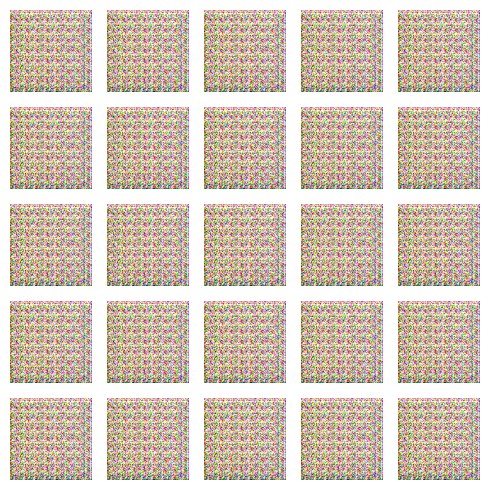

  0%|          | 0/500 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step


  0%|          | 1/500 [00:03<30:56,  3.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 656ms/step


  0%|          | 2/500 [00:08<35:55,  4.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


  1%|          | 3/500 [00:11<30:45,  3.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


  1%|          | 4/500 [00:14<28:39,  3.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


  1%|          | 5/500 [00:17<26:55,  3.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 527ms/step


  1%|          | 6/500 [00:21<29:28,  3.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 689ms/step


  1%|▏         | 7/500 [00:25<29:39,  3.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step


  2%|▏         | 8/500 [00:28<27:58,  3.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step


  2%|▏         | 9/500 [00:31<26:25,  3.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step


  2%|▏         | 10/500 [00:34<27:07,  3.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 678ms/step


  2%|▏         | 11/500 [00:39<30:37,  3.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step


  2%|▏         | 12/500 [00:42<28:24,  3.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step


  3%|▎         | 13/500 [00:45<26:46,  3.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step


  3%|▎         | 14/500 [00:48<26:23,  3.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


  3%|▎         | 15/500 [00:52<29:01,  3.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step


  3%|▎         | 16/500 [00:56<29:10,  3.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step


  3%|▎         | 17/500 [00:59<27:32,  3.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step


  4%|▎         | 18/500 [01:02<26:31,  3.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step


  4%|▍         | 19/500 [01:05<26:44,  3.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 685ms/step


  4%|▍         | 20/500 [01:10<30:34,  3.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step


  4%|▍         | 21/500 [01:13<28:37,  3.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


  4%|▍         | 22/500 [01:16<27:17,  3.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


  5%|▍         | 23/500 [01:19<26:25,  3.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step


  5%|▍         | 24/500 [01:24<28:46,  3.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 652ms/step


  5%|▌         | 25/500 [01:27<28:38,  3.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step


  5%|▌         | 26/500 [01:30<27:16,  3.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step


  5%|▌         | 27/500 [01:34<26:30,  3.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step


  6%|▌         | 28/500 [01:37<27:27,  3.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 717ms/step


  6%|▌         | 29/500 [01:41<28:45,  3.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


  6%|▌         | 30/500 [01:45<27:38,  3.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step


  6%|▌         | 31/500 [01:48<26:39,  3.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


  6%|▋         | 32/500 [01:51<25:28,  3.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 717ms/step


  7%|▋         | 33/500 [01:56<30:03,  3.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step


  7%|▋         | 34/500 [01:59<27:36,  3.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step


  7%|▋         | 35/500 [02:02<26:17,  3.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


  7%|▋         | 36/500 [02:05<25:25,  3.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


  7%|▋         | 37/500 [02:08<26:17,  3.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/step


  8%|▊         | 38/500 [02:13<28:45,  3.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step


  8%|▊         | 39/500 [02:16<26:44,  3.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


  8%|▊         | 40/500 [02:19<26:03,  3.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step


  8%|▊         | 41/500 [02:22<25:40,  3.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 708ms/step


  8%|▊         | 42/500 [02:27<28:45,  3.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


  9%|▊         | 43/500 [02:30<27:16,  3.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


  9%|▉         | 44/500 [02:33<26:06,  3.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step


  9%|▉         | 45/500 [02:36<24:44,  3.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 519ms/step


  9%|▉         | 46/500 [02:40<26:56,  3.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 679ms/step


  9%|▉         | 47/500 [02:44<27:19,  3.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step


 10%|▉         | 48/500 [02:47<26:08,  3.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


 10%|▉         | 49/500 [02:51<25:34,  3.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step


 10%|█         | 50/500 [02:55<27:32,  3.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 648ms/step


 10%|█         | 51/500 [02:59<27:53,  3.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


 10%|█         | 52/500 [03:02<26:15,  3.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step


 11%|█         | 53/500 [03:05<25:19,  3.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 11%|█         | 54/500 [03:08<24:33,  3.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 730ms/step


 11%|█         | 55/500 [03:13<28:17,  3.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 517ms/step


 11%|█         | 56/500 [03:16<26:21,  3.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step


 11%|█▏        | 57/500 [03:19<24:59,  3.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step


 12%|█▏        | 58/500 [03:22<24:41,  3.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step


 12%|█▏        | 59/500 [03:27<26:51,  3.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 748ms/step


 12%|█▏        | 60/500 [03:30<27:06,  3.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step


 12%|█▏        | 61/500 [03:33<25:41,  3.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step


 12%|█▏        | 62/500 [03:37<24:45,  3.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step


 13%|█▎        | 63/500 [03:40<25:49,  3.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 689ms/step


 13%|█▎        | 64/500 [03:45<27:12,  3.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step


 13%|█▎        | 65/500 [03:48<25:38,  3.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


 13%|█▎        | 66/500 [03:51<24:53,  3.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step


 13%|█▎        | 67/500 [03:55<25:37,  3.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 691ms/step


 14%|█▎        | 68/500 [03:59<27:20,  3.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


 14%|█▍        | 69/500 [04:02<26:02,  3.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step


 14%|█▍        | 70/500 [04:05<24:28,  3.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step


 14%|█▍        | 71/500 [04:08<23:28,  3.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 14%|█▍        | 72/500 [04:13<26:45,  3.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 733ms/step


 15%|█▍        | 73/500 [04:17<27:12,  3.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step


 15%|█▍        | 74/500 [04:20<25:45,  3.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


 15%|█▌        | 75/500 [04:23<24:34,  3.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step


 15%|█▌        | 76/500 [04:28<26:31,  3.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 769ms/step


 15%|█▌        | 77/500 [04:33<28:46,  4.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 904ms/step


 16%|█▌        | 78/500 [04:36<27:58,  3.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step


 16%|█▌        | 79/500 [04:39<26:16,  3.74s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step


 16%|█▌        | 80/500 [04:42<24:20,  3.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


 16%|█▌        | 81/500 [04:46<24:25,  3.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 641ms/step


 16%|█▋        | 82/500 [04:50<26:07,  3.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


 17%|█▋        | 83/500 [04:53<24:21,  3.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


 17%|█▋        | 84/500 [04:56<23:02,  3.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step


 17%|█▋        | 85/500 [04:59<22:53,  3.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step


 17%|█▋        | 86/500 [05:04<25:18,  3.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 714ms/step


 17%|█▋        | 87/500 [05:08<25:17,  3.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step


 18%|█▊        | 88/500 [05:10<23:30,  3.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step


 18%|█▊        | 89/500 [05:14<23:05,  3.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step


 18%|█▊        | 90/500 [05:18<24:27,  3.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 759ms/step


 18%|█▊        | 91/500 [05:22<25:36,  3.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step


 18%|█▊        | 92/500 [05:25<24:19,  3.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step


 19%|█▊        | 93/500 [05:28<23:33,  3.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step


 19%|█▉        | 94/500 [05:32<24:03,  3.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 759ms/step


 19%|█▉        | 95/500 [05:37<26:00,  3.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step


 19%|█▉        | 96/500 [05:40<24:11,  3.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


 19%|█▉        | 97/500 [05:42<22:39,  3.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step


 20%|█▉        | 98/500 [05:46<22:14,  3.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step


 20%|█▉        | 99/500 [05:50<23:59,  3.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 641ms/step


 20%|██        | 100/500 [05:54<24:16,  3.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step


 20%|██        | 101/500 [05:57<23:12,  3.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step


 20%|██        | 102/500 [06:00<22:16,  3.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step


 21%|██        | 103/500 [06:03<22:43,  3.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 689ms/step


 21%|██        | 104/500 [06:08<24:37,  3.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step


 21%|██        | 105/500 [06:11<23:17,  3.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step


 21%|██        | 106/500 [06:14<22:02,  3.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 21%|██▏       | 107/500 [06:17<20:47,  3.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 22%|██▏       | 108/500 [06:20<21:15,  3.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 668ms/step


 22%|██▏       | 109/500 [06:24<23:13,  3.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step


 22%|██▏       | 110/500 [06:27<22:22,  3.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step


 22%|██▏       | 111/500 [06:30<21:21,  3.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


 22%|██▏       | 112/500 [06:34<21:30,  3.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 763ms/step


 23%|██▎       | 113/500 [06:39<24:36,  3.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step


 23%|██▎       | 114/500 [06:42<22:58,  3.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


 23%|██▎       | 115/500 [06:45<21:36,  3.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step


 23%|██▎       | 116/500 [06:47<20:31,  3.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step


 23%|██▎       | 117/500 [06:52<22:31,  3.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 649ms/step


 24%|██▎       | 118/500 [06:56<23:09,  3.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step


 24%|██▍       | 119/500 [06:59<22:12,  3.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step


 24%|██▍       | 120/500 [07:02<20:51,  3.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


 24%|██▍       | 121/500 [07:05<20:51,  3.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 740ms/step


 24%|██▍       | 122/500 [07:09<23:07,  3.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step


 25%|██▍       | 123/500 [07:13<22:07,  3.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step


 25%|██▍       | 124/500 [07:16<21:14,  3.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step


 25%|██▌       | 125/500 [07:18<19:59,  3.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step


 25%|██▌       | 126/500 [07:22<20:39,  3.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 667ms/step


 25%|██▌       | 127/500 [07:26<22:36,  3.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


 26%|██▌       | 128/500 [07:29<21:13,  3.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


 26%|██▌       | 129/500 [07:32<20:14,  3.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step


 26%|██▌       | 130/500 [07:35<19:36,  3.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step


 26%|██▌       | 131/500 [07:40<21:40,  3.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 728ms/step


 26%|██▋       | 132/500 [07:43<22:05,  3.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step


 27%|██▋       | 133/500 [07:46<20:48,  3.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step


 27%|██▋       | 134/500 [07:49<20:17,  3.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


 27%|██▋       | 135/500 [07:53<21:09,  3.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 673ms/step


 27%|██▋       | 136/500 [07:58<22:25,  3.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step


 27%|██▋       | 137/500 [08:00<21:01,  3.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step


 28%|██▊       | 138/500 [08:04<20:30,  3.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step


 28%|██▊       | 139/500 [08:07<19:31,  3.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 681ms/step


 28%|██▊       | 140/500 [08:12<22:42,  3.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 28%|██▊       | 141/500 [08:14<20:48,  3.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step


 28%|██▊       | 142/500 [08:17<19:30,  3.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step


 29%|██▊       | 143/500 [08:20<18:56,  3.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step


 29%|██▉       | 144/500 [08:24<20:14,  3.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 735ms/step


 29%|██▉       | 145/500 [08:28<20:59,  3.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


 29%|██▉       | 146/500 [08:31<19:31,  3.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


 29%|██▉       | 147/500 [08:33<18:27,  3.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step


 30%|██▉       | 148/500 [08:36<17:48,  3.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step


 30%|██▉       | 149/500 [08:40<18:39,  3.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 698ms/step


 30%|███       | 150/500 [08:44<20:19,  3.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step


 30%|███       | 151/500 [08:47<19:33,  3.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step


 30%|███       | 152/500 [08:50<18:40,  3.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step


 31%|███       | 153/500 [08:53<18:40,  3.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 721ms/step


 31%|███       | 154/500 [08:58<21:27,  3.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step


 31%|███       | 155/500 [09:01<20:19,  3.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step


 31%|███       | 156/500 [09:04<19:35,  3.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step


 31%|███▏      | 157/500 [09:07<18:47,  3.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


 32%|███▏      | 158/500 [09:12<20:39,  3.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 692ms/step


 32%|███▏      | 159/500 [09:15<20:30,  3.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step


 32%|███▏      | 160/500 [09:18<19:21,  3.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step


 32%|███▏      | 161/500 [09:21<18:51,  3.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


 32%|███▏      | 162/500 [09:25<18:45,  3.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 688ms/step


 33%|███▎      | 163/500 [09:29<20:46,  3.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step


 33%|███▎      | 164/500 [09:32<19:29,  3.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step


 33%|███▎      | 165/500 [09:35<18:30,  3.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 33%|███▎      | 166/500 [09:38<18:04,  3.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step


 33%|███▎      | 167/500 [09:43<19:46,  3.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 719ms/step


 34%|███▎      | 168/500 [09:46<19:50,  3.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step


 34%|███▍      | 169/500 [09:49<18:56,  3.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step


 34%|███▍      | 170/500 [09:52<18:19,  3.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step


 34%|███▍      | 171/500 [09:56<19:05,  3.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 695ms/step


 34%|███▍      | 172/500 [10:00<20:15,  3.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step


 35%|███▍      | 173/500 [10:03<18:58,  3.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step


 35%|███▍      | 174/500 [10:06<17:45,  3.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step


 35%|███▌      | 175/500 [10:09<17:10,  3.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 695ms/step


 35%|███▌      | 176/500 [10:14<20:02,  3.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step


 35%|███▌      | 177/500 [10:17<18:28,  3.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step


 36%|███▌      | 178/500 [10:20<17:50,  3.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step


 36%|███▌      | 179/500 [10:23<16:56,  3.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


 36%|███▌      | 180/500 [10:26<17:28,  3.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 706ms/step


 36%|███▌      | 181/500 [10:30<18:45,  3.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


 36%|███▋      | 182/500 [10:33<17:54,  3.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


 37%|███▋      | 183/500 [10:36<17:10,  3.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step


 37%|███▋      | 184/500 [10:39<16:38,  3.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step


 37%|███▋      | 185/500 [10:44<18:24,  3.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 745ms/step


 37%|███▋      | 186/500 [10:47<18:46,  3.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step


 37%|███▋      | 187/500 [10:50<17:43,  3.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


 38%|███▊      | 188/500 [10:53<16:42,  3.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 38%|███▊      | 189/500 [10:57<17:10,  3.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 676ms/step


 38%|███▊      | 190/500 [11:01<19:15,  3.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step


 38%|███▊      | 191/500 [11:04<17:41,  3.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


 38%|███▊      | 192/500 [11:07<17:03,  3.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 39%|███▊      | 193/500 [11:10<16:05,  3.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step


 39%|███▉      | 194/500 [11:14<17:32,  3.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 676ms/step


 39%|███▉      | 195/500 [11:18<17:45,  3.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


 39%|███▉      | 196/500 [11:21<17:00,  3.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step


 39%|███▉      | 197/500 [11:24<16:10,  3.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


 40%|███▉      | 198/500 [11:27<16:50,  3.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 717ms/step


 40%|███▉      | 199/500 [11:33<19:43,  3.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 761ms/step


 40%|████      | 200/500 [11:36<19:31,  3.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step


 40%|████      | 201/500 [11:39<18:03,  3.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step


 40%|████      | 202/500 [11:42<17:06,  3.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step


 41%|████      | 203/500 [11:46<17:21,  3.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 688ms/step


 41%|████      | 204/500 [11:50<18:33,  3.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step


 41%|████      | 205/500 [11:53<17:00,  3.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step


 41%|████      | 206/500 [11:56<16:33,  3.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step


 41%|████▏     | 207/500 [12:00<16:21,  3.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 702ms/step


 42%|████▏     | 208/500 [12:04<18:33,  3.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step


 42%|████▏     | 209/500 [12:07<17:10,  3.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


 42%|████▏     | 210/500 [12:10<16:13,  3.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step


 42%|████▏     | 211/500 [12:13<15:32,  3.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step


 42%|████▏     | 212/500 [12:17<16:00,  3.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 679ms/step


 43%|████▎     | 213/500 [12:21<17:19,  3.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step


 43%|████▎     | 214/500 [12:24<16:10,  3.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step


 43%|████▎     | 215/500 [12:27<15:45,  3.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step


 43%|████▎     | 216/500 [12:31<15:55,  3.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 733ms/step


 43%|████▎     | 217/500 [12:35<17:25,  3.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step


 44%|████▎     | 218/500 [12:38<16:21,  3.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


 44%|████▍     | 219/500 [12:41<15:28,  3.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step


 44%|████▍     | 220/500 [12:44<14:56,  3.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step


 44%|████▍     | 221/500 [12:48<15:35,  3.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 701ms/step


 44%|████▍     | 222/500 [12:52<17:02,  3.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step


 45%|████▍     | 223/500 [12:55<16:08,  3.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


 45%|████▍     | 224/500 [12:58<15:01,  3.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step


 45%|████▌     | 225/500 [13:01<14:14,  3.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step


 45%|████▌     | 226/500 [13:05<15:56,  3.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 698ms/step


 45%|████▌     | 227/500 [13:09<16:26,  3.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step


 46%|████▌     | 228/500 [13:12<15:42,  3.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


 46%|████▌     | 229/500 [13:15<14:44,  3.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 46%|████▌     | 230/500 [13:19<15:22,  3.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 748ms/step


 46%|████▌     | 231/500 [13:23<16:13,  3.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step


 46%|████▋     | 232/500 [13:25<15:07,  3.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 47%|████▋     | 233/500 [13:28<14:26,  3.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 47%|████▋     | 234/500 [13:31<13:44,  3.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step


 47%|████▋     | 235/500 [13:35<14:36,  3.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step


 47%|████▋     | 236/500 [13:39<15:01,  3.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step


 47%|████▋     | 237/500 [13:42<14:41,  3.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step


 48%|████▊     | 238/500 [13:45<14:08,  3.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step


 48%|████▊     | 239/500 [13:48<14:19,  3.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 780ms/step


 48%|████▊     | 240/500 [13:53<16:25,  3.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


 48%|████▊     | 241/500 [13:56<15:28,  3.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step


 48%|████▊     | 242/500 [13:59<14:30,  3.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step


 49%|████▊     | 243/500 [14:02<13:49,  3.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 49%|████▉     | 244/500 [14:06<14:57,  3.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 698ms/step


 49%|████▉     | 245/500 [14:10<15:41,  3.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step


 49%|████▉     | 246/500 [14:14<15:06,  3.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step


 49%|████▉     | 247/500 [14:17<14:50,  3.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 510ms/step


 50%|████▉     | 248/500 [14:22<16:03,  3.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 658ms/step


 50%|████▉     | 249/500 [14:25<16:04,  3.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step


 50%|█████     | 250/500 [14:28<14:57,  3.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step


 50%|█████     | 251/500 [14:32<14:29,  3.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step


 50%|█████     | 252/500 [14:35<14:33,  3.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 670ms/step


 51%|█████     | 253/500 [14:40<15:40,  3.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step


 51%|█████     | 254/500 [14:43<14:35,  3.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


 51%|█████     | 255/500 [14:46<13:33,  3.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


 51%|█████     | 256/500 [14:48<12:51,  3.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step


 51%|█████▏    | 257/500 [14:53<14:15,  3.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 708ms/step


 52%|█████▏    | 258/500 [14:56<14:28,  3.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


 52%|█████▏    | 259/500 [14:59<13:24,  3.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step


 52%|█████▏    | 260/500 [15:02<12:57,  3.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step


 52%|█████▏    | 261/500 [15:06<13:44,  3.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 709ms/step


 52%|█████▏    | 262/500 [15:10<14:44,  3.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step


 53%|█████▎    | 263/500 [15:13<13:45,  3.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step


 53%|█████▎    | 264/500 [15:16<12:51,  3.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


 53%|█████▎    | 265/500 [15:20<13:01,  3.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 699ms/step


 53%|█████▎    | 266/500 [15:25<15:09,  3.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step


 53%|█████▎    | 267/500 [15:28<14:01,  3.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


 54%|█████▎    | 268/500 [15:31<13:11,  3.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


 54%|█████▍    | 269/500 [15:34<12:45,  3.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step


 54%|█████▍    | 270/500 [15:38<13:27,  3.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 667ms/step


 54%|█████▍    | 271/500 [15:42<13:43,  3.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step


 54%|█████▍    | 272/500 [15:45<12:54,  3.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


 55%|█████▍    | 273/500 [15:48<12:41,  3.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 55%|█████▍    | 274/500 [15:51<12:12,  3.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 744ms/step


 55%|█████▌    | 275/500 [15:55<13:18,  3.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 732ms/step


 55%|█████▌    | 276/500 [15:59<13:17,  3.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step


 55%|█████▌    | 277/500 [16:01<12:22,  3.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step


 56%|█████▌    | 278/500 [16:04<11:52,  3.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


 56%|█████▌    | 279/500 [16:08<12:15,  3.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 671ms/step


 56%|█████▌    | 280/500 [16:12<13:25,  3.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 56%|█████▌    | 281/500 [16:15<12:34,  3.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 56%|█████▋    | 282/500 [16:18<11:56,  3.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


 57%|█████▋    | 283/500 [16:21<11:22,  3.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 504ms/step


 57%|█████▋    | 284/500 [16:25<12:35,  3.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 691ms/step


 57%|█████▋    | 285/500 [16:29<12:37,  3.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


 57%|█████▋    | 286/500 [16:32<11:45,  3.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step


 57%|█████▋    | 287/500 [16:35<11:18,  3.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step


 58%|█████▊    | 288/500 [16:38<11:29,  3.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 662ms/step


 58%|█████▊    | 289/500 [16:43<12:47,  3.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


 58%|█████▊    | 290/500 [16:45<11:47,  3.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step


 58%|█████▊    | 291/500 [16:48<11:22,  3.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step


 58%|█████▊    | 292/500 [16:51<11:00,  3.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 59%|█████▊    | 293/500 [16:56<12:10,  3.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 751ms/step


 59%|█████▉    | 294/500 [16:59<12:22,  3.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step


 59%|█████▉    | 295/500 [17:03<11:53,  3.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


 59%|█████▉    | 296/500 [17:06<11:29,  3.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step


 59%|█████▉    | 297/500 [17:09<11:46,  3.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 731ms/step


 60%|█████▉    | 298/500 [17:14<12:21,  3.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step


 60%|█████▉    | 299/500 [17:17<11:46,  3.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step


 60%|██████    | 300/500 [17:20<11:11,  3.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step


 60%|██████    | 301/500 [17:23<10:47,  3.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 686ms/step


 60%|██████    | 302/500 [17:28<12:33,  3.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step


 61%|██████    | 303/500 [17:31<11:44,  3.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step


 61%|██████    | 304/500 [17:34<11:00,  3.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step


 61%|██████    | 305/500 [17:37<10:33,  3.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step


 61%|██████    | 306/500 [17:40<10:56,  3.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 707ms/step


 61%|██████▏   | 307/500 [17:44<11:24,  3.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


 62%|██████▏   | 308/500 [17:47<10:43,  3.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


 62%|██████▏   | 309/500 [17:50<10:06,  3.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


 62%|██████▏   | 310/500 [17:53<09:44,  3.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 691ms/step


 62%|██████▏   | 311/500 [17:58<11:31,  3.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step


 62%|██████▏   | 312/500 [18:01<10:58,  3.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step


 63%|██████▎   | 313/500 [18:04<10:32,  3.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


 63%|██████▎   | 314/500 [18:07<10:08,  3.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 63%|██████▎   | 315/500 [18:11<10:54,  3.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 656ms/step


 63%|██████▎   | 316/500 [18:15<10:57,  3.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step


 63%|██████▎   | 317/500 [18:18<10:15,  3.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 64%|██████▎   | 318/500 [18:21<09:37,  3.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 64%|██████▍   | 319/500 [18:23<09:19,  3.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step


 64%|██████▍   | 320/500 [18:28<10:44,  3.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 717ms/step


 64%|██████▍   | 321/500 [18:34<12:16,  4.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step


 64%|██████▍   | 322/500 [18:36<11:05,  3.74s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


 65%|██████▍   | 323/500 [18:40<10:27,  3.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


 65%|██████▍   | 324/500 [18:42<09:50,  3.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step


 65%|██████▌   | 325/500 [18:46<10:05,  3.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 719ms/step


 65%|██████▌   | 326/500 [18:50<10:23,  3.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 65%|██████▌   | 327/500 [18:53<09:52,  3.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step


 66%|██████▌   | 328/500 [18:56<09:28,  3.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step


 66%|██████▌   | 329/500 [18:59<09:13,  3.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step


 66%|██████▌   | 330/500 [19:03<09:56,  3.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 706ms/step


 66%|██████▌   | 331/500 [19:07<10:01,  3.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step


 66%|██████▋   | 332/500 [19:10<09:28,  3.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


 67%|██████▋   | 333/500 [19:13<09:03,  3.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


 67%|██████▋   | 334/500 [19:16<09:11,  3.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 707ms/step


 67%|██████▋   | 335/500 [19:21<09:57,  3.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step


 67%|██████▋   | 336/500 [19:24<09:24,  3.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step


 67%|██████▋   | 337/500 [19:27<09:02,  3.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step


 68%|██████▊   | 338/500 [19:30<08:51,  3.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 673ms/step


 68%|██████▊   | 339/500 [19:35<10:15,  3.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step


 68%|██████▊   | 340/500 [19:38<09:37,  3.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


 68%|██████▊   | 341/500 [19:41<09:01,  3.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step


 68%|██████▊   | 342/500 [19:44<08:36,  3.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step


 69%|██████▊   | 343/500 [19:48<09:22,  3.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 667ms/step


 69%|██████▉   | 344/500 [19:52<09:19,  3.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step


 69%|██████▉   | 345/500 [19:55<08:51,  3.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step


 69%|██████▉   | 346/500 [19:58<08:28,  3.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step


 69%|██████▉   | 347/500 [20:02<08:41,  3.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 742ms/step


 70%|██████▉   | 348/500 [20:06<09:37,  3.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step


 70%|██████▉   | 349/500 [20:10<09:07,  3.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step


 70%|███████   | 350/500 [20:13<08:34,  3.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 70%|███████   | 351/500 [20:16<08:26,  3.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 713ms/step


 70%|███████   | 352/500 [20:21<09:18,  3.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


 71%|███████   | 353/500 [20:23<08:27,  3.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step


 71%|███████   | 354/500 [20:26<08:04,  3.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step


 71%|███████   | 355/500 [20:29<07:53,  3.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step


 71%|███████   | 356/500 [20:34<08:32,  3.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 699ms/step


 71%|███████▏  | 357/500 [20:37<08:28,  3.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


 72%|███████▏  | 358/500 [20:40<07:57,  3.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


 72%|███████▏  | 359/500 [20:43<07:41,  3.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step


 72%|███████▏  | 360/500 [20:47<07:49,  3.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 662ms/step


 72%|███████▏  | 361/500 [20:51<08:29,  3.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


 72%|███████▏  | 362/500 [20:54<08:01,  3.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step


 73%|███████▎  | 363/500 [20:57<07:35,  3.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 502ms/step


 73%|███████▎  | 364/500 [21:00<07:10,  3.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step


 73%|███████▎  | 365/500 [21:05<08:06,  3.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 750ms/step


 73%|███████▎  | 366/500 [21:08<08:08,  3.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step


 73%|███████▎  | 367/500 [21:11<07:37,  3.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


 74%|███████▎  | 368/500 [21:14<07:09,  3.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step


 74%|███████▍  | 369/500 [21:18<07:20,  3.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 717ms/step


 74%|███████▍  | 370/500 [21:22<07:50,  3.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step


 74%|███████▍  | 371/500 [21:25<07:19,  3.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


 74%|███████▍  | 372/500 [21:28<07:06,  3.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step


 75%|███████▍  | 373/500 [21:31<07:00,  3.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step


 75%|███████▍  | 374/500 [21:36<07:44,  3.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 787ms/step


 75%|███████▌  | 375/500 [21:39<07:28,  3.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


 75%|███████▌  | 376/500 [21:42<06:57,  3.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


 75%|███████▌  | 377/500 [21:45<06:43,  3.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step


 76%|███████▌  | 378/500 [21:48<06:30,  3.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 671ms/step


 76%|███████▌  | 379/500 [21:53<07:24,  3.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step


 76%|███████▌  | 380/500 [21:56<06:54,  3.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


 76%|███████▌  | 381/500 [21:59<06:37,  3.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 76%|███████▋  | 382/500 [22:02<06:20,  3.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step


 77%|███████▋  | 383/500 [22:06<07:03,  3.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 763ms/step


 77%|███████▋  | 384/500 [22:10<06:54,  3.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


 77%|███████▋  | 385/500 [22:13<06:26,  3.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


 77%|███████▋  | 386/500 [22:16<06:09,  3.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step


 77%|███████▋  | 387/500 [22:19<06:06,  3.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 684ms/step


 78%|███████▊  | 388/500 [22:24<06:50,  3.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step


 78%|███████▊  | 389/500 [22:26<06:14,  3.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 78%|███████▊  | 390/500 [22:29<05:49,  3.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step


 78%|███████▊  | 391/500 [22:32<05:41,  3.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step


 78%|███████▊  | 392/500 [22:36<06:04,  3.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 744ms/step


 79%|███████▊  | 393/500 [22:40<06:30,  3.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step


 79%|███████▉  | 394/500 [22:43<06:10,  3.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


 79%|███████▉  | 395/500 [22:46<05:51,  3.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


 79%|███████▉  | 396/500 [22:50<05:42,  3.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 671ms/step


 79%|███████▉  | 397/500 [22:54<06:26,  3.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step


 80%|███████▉  | 398/500 [22:58<06:05,  3.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 512ms/step


 80%|███████▉  | 399/500 [23:01<05:50,  3.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step


 80%|████████  | 400/500 [23:04<05:41,  3.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 645ms/step


 80%|████████  | 401/500 [23:09<06:09,  3.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 772ms/step


 80%|████████  | 402/500 [23:12<06:07,  3.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step


 81%|████████  | 403/500 [23:15<05:43,  3.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 81%|████████  | 404/500 [23:19<05:27,  3.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step


 81%|████████  | 405/500 [23:22<05:32,  3.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 701ms/step


 81%|████████  | 406/500 [23:26<05:48,  3.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 81%|████████▏ | 407/500 [23:30<05:28,  3.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step


 82%|████████▏ | 408/500 [23:33<05:16,  3.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step


 82%|████████▏ | 409/500 [23:37<05:23,  3.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 700ms/step


 82%|████████▏ | 410/500 [23:41<05:43,  3.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step


 82%|████████▏ | 411/500 [23:44<05:23,  3.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step


 82%|████████▏ | 412/500 [23:47<05:05,  3.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


 83%|████████▎ | 413/500 [23:51<05:02,  3.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 721ms/step


 83%|████████▎ | 414/500 [23:56<05:31,  3.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 83%|████████▎ | 415/500 [23:59<05:12,  3.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step


 83%|████████▎ | 416/500 [24:02<04:55,  3.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step


 83%|████████▎ | 417/500 [24:05<04:44,  3.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 714ms/step


 84%|████████▎ | 418/500 [24:10<05:26,  3.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 522ms/step


 84%|████████▍ | 419/500 [24:14<05:07,  3.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step


 84%|████████▍ | 420/500 [24:17<04:51,  3.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step


 84%|████████▍ | 421/500 [24:20<04:33,  3.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step


 84%|████████▍ | 422/500 [24:24<04:49,  3.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 664ms/step


 85%|████████▍ | 423/500 [24:28<04:46,  3.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step


 85%|████████▍ | 424/500 [24:31<04:26,  3.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step


 85%|████████▌ | 425/500 [24:34<04:14,  3.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step


 85%|████████▌ | 426/500 [24:38<04:23,  3.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 651ms/step


 85%|████████▌ | 427/500 [24:42<04:31,  3.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step


 86%|████████▌ | 428/500 [24:45<04:10,  3.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step


 86%|████████▌ | 429/500 [24:48<03:53,  3.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step


 86%|████████▌ | 430/500 [24:51<03:43,  3.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


 86%|████████▌ | 431/500 [24:56<04:08,  3.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 734ms/step


 86%|████████▋ | 432/500 [24:59<04:04,  3.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step


 87%|████████▋ | 433/500 [25:02<03:46,  3.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step


 87%|████████▋ | 434/500 [25:05<03:35,  3.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


 87%|████████▋ | 435/500 [25:09<03:37,  3.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 704ms/step


 87%|████████▋ | 436/500 [25:13<03:54,  3.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step


 87%|████████▋ | 437/500 [25:16<03:42,  3.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step


 88%|████████▊ | 438/500 [25:19<03:32,  3.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step


 88%|████████▊ | 439/500 [25:23<03:36,  3.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 852ms/step


 88%|████████▊ | 440/500 [25:28<03:55,  3.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 786ms/step


 88%|████████▊ | 441/500 [25:33<04:09,  4.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step


 88%|████████▊ | 442/500 [25:36<03:42,  3.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


 89%|████████▊ | 443/500 [25:39<03:24,  3.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step


 89%|████████▉ | 444/500 [25:42<03:12,  3.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 698ms/step


 89%|████████▉ | 445/500 [25:47<03:26,  3.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step


 89%|████████▉ | 446/500 [25:50<03:13,  3.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step


 89%|████████▉ | 447/500 [25:53<03:01,  3.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step


 90%|████████▉ | 448/500 [25:56<02:53,  3.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step


 90%|████████▉ | 449/500 [26:00<03:04,  3.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 757ms/step


 90%|█████████ | 450/500 [26:04<03:04,  3.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step


 90%|█████████ | 451/500 [26:07<02:54,  3.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step


 90%|█████████ | 452/500 [26:10<02:43,  3.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


 91%|█████████ | 453/500 [26:14<02:42,  3.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 758ms/step


 91%|█████████ | 454/500 [26:18<02:53,  3.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step


 91%|█████████ | 455/500 [26:21<02:36,  3.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step


 91%|█████████ | 456/500 [26:24<02:26,  3.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


 91%|█████████▏| 457/500 [26:28<02:22,  3.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 710ms/step


 92%|█████████▏| 458/500 [26:33<02:42,  3.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step


 92%|█████████▏| 459/500 [26:36<02:28,  3.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step


 92%|█████████▏| 460/500 [26:39<02:15,  3.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step


 92%|█████████▏| 461/500 [26:41<02:06,  3.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 92%|█████████▏| 462/500 [26:45<02:06,  3.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 690ms/step


 93%|█████████▎| 463/500 [26:49<02:15,  3.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


 93%|█████████▎| 464/500 [26:52<02:03,  3.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step


 93%|█████████▎| 465/500 [26:55<01:57,  3.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step


 93%|█████████▎| 466/500 [26:59<01:54,  3.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 701ms/step


 93%|█████████▎| 467/500 [27:03<02:02,  3.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 644ms/step


 94%|█████████▎| 468/500 [27:07<01:53,  3.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step


 94%|█████████▍| 469/500 [27:10<01:46,  3.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step


 94%|█████████▍| 470/500 [27:13<01:38,  3.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step


 94%|█████████▍| 471/500 [27:16<01:36,  3.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 724ms/step


 94%|█████████▍| 472/500 [27:20<01:40,  3.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


 95%|█████████▍| 473/500 [27:23<01:29,  3.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


 95%|█████████▍| 474/500 [27:26<01:23,  3.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step


 95%|█████████▌| 475/500 [27:29<01:19,  3.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step


 95%|█████████▌| 476/500 [27:33<01:24,  3.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 699ms/step


 95%|█████████▌| 477/500 [27:37<01:22,  3.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step


 96%|█████████▌| 478/500 [27:40<01:15,  3.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 96%|█████████▌| 479/500 [27:43<01:09,  3.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


 96%|█████████▌| 480/500 [27:46<01:03,  3.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step


 96%|█████████▌| 481/500 [27:50<01:06,  3.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 715ms/step


 96%|█████████▋| 482/500 [27:54<01:01,  3.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


 97%|█████████▋| 483/500 [27:57<00:55,  3.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step


 97%|█████████▋| 484/500 [27:59<00:50,  3.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step


 97%|█████████▋| 485/500 [28:03<00:49,  3.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step


 97%|█████████▋| 486/500 [28:07<00:50,  3.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step


 97%|█████████▋| 487/500 [28:10<00:44,  3.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


 98%|█████████▊| 488/500 [28:13<00:39,  3.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step


 98%|█████████▊| 489/500 [28:16<00:34,  3.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step


 98%|█████████▊| 490/500 [28:20<00:34,  3.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 698ms/step


 98%|█████████▊| 491/500 [28:24<00:32,  3.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


 98%|█████████▊| 492/500 [28:27<00:27,  3.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


 99%|█████████▊| 493/500 [28:30<00:22,  3.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step


 99%|█████████▉| 494/500 [28:33<00:18,  3.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 696ms/step


 99%|█████████▉| 495/500 [28:37<00:17,  3.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step


 99%|█████████▉| 496/500 [28:41<00:13,  3.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


 99%|█████████▉| 497/500 [28:44<00:09,  3.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step


100%|█████████▉| 498/500 [28:47<00:06,  3.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


100%|█████████▉| 499/500 [28:50<00:03,  3.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 734ms/step


100%|██████████| 500/500 [28:55<00:00,  3.47s/it]


Epoch: 5 	 Discriminator Loss: 0.6596287488937378 		 Generator Loss: [array(0.65962875), array(0.65962875), array(0.65962875)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


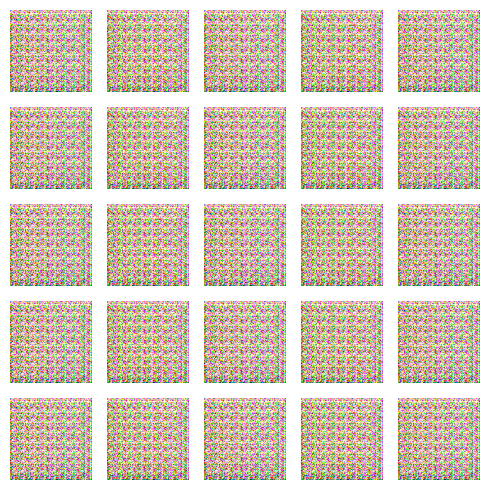

  0%|          | 0/500 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 686ms/step


  0%|          | 1/500 [00:03<31:16,  3.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step


  0%|          | 2/500 [00:07<31:25,  3.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 716ms/step


  1%|          | 3/500 [00:11<32:58,  3.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step


  1%|          | 4/500 [00:14<30:13,  3.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step


  1%|          | 5/500 [00:17<28:07,  3.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


  1%|          | 6/500 [00:21<28:13,  3.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 649ms/step


  1%|▏         | 7/500 [00:26<32:02,  3.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


  2%|▏         | 8/500 [00:29<30:19,  3.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step


  2%|▏         | 9/500 [00:32<28:43,  3.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step


  2%|▏         | 10/500 [00:35<27:07,  3.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


  2%|▏         | 11/500 [00:39<29:14,  3.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 670ms/step


  2%|▏         | 12/500 [00:43<29:32,  3.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step


  3%|▎         | 13/500 [00:46<28:22,  3.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step


  3%|▎         | 14/500 [00:49<27:21,  3.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step


  3%|▎         | 15/500 [00:53<28:28,  3.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 691ms/step


  3%|▎         | 16/500 [00:57<30:01,  3.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step


  3%|▎         | 17/500 [01:00<28:32,  3.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step


  4%|▎         | 18/500 [01:04<27:35,  3.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


  4%|▍         | 19/500 [01:07<27:32,  3.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 756ms/step


  4%|▍         | 20/500 [01:12<30:13,  3.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step


  4%|▍         | 21/500 [01:15<28:44,  3.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step


  4%|▍         | 22/500 [01:18<27:23,  3.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step


  5%|▍         | 23/500 [01:21<26:27,  3.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 735ms/step


  5%|▍         | 24/500 [01:26<30:45,  3.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


  5%|▌         | 25/500 [01:29<28:29,  3.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step


  5%|▌         | 26/500 [01:32<26:29,  3.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step


  5%|▌         | 27/500 [01:35<26:08,  3.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step


  6%|▌         | 28/500 [01:39<28:40,  3.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 690ms/step


  6%|▌         | 29/500 [01:44<29:38,  3.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step


  6%|▌         | 30/500 [01:46<27:31,  3.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step


  6%|▌         | 31/500 [01:49<26:15,  3.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step


  6%|▋         | 32/500 [01:52<25:12,  3.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 703ms/step


  7%|▋         | 33/500 [01:58<29:38,  3.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


  7%|▋         | 34/500 [02:01<28:01,  3.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


  7%|▋         | 35/500 [02:04<26:21,  3.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step


  7%|▋         | 36/500 [02:06<24:56,  3.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


  7%|▋         | 37/500 [02:10<26:56,  3.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 719ms/step


  8%|▊         | 38/500 [02:14<27:30,  3.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step


  8%|▊         | 39/500 [02:17<25:59,  3.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


  8%|▊         | 40/500 [02:20<24:52,  3.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


  8%|▊         | 41/500 [02:23<25:06,  3.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 677ms/step


  8%|▊         | 42/500 [02:28<28:20,  3.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


  9%|▊         | 43/500 [02:31<25:59,  3.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step


  9%|▉         | 44/500 [02:34<25:36,  3.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step


  9%|▉         | 45/500 [02:37<25:21,  3.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step


  9%|▉         | 46/500 [02:42<27:17,  3.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 733ms/step


  9%|▉         | 47/500 [02:45<27:37,  3.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step


 10%|▉         | 48/500 [02:49<26:16,  3.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


 10%|▉         | 49/500 [02:52<25:05,  3.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step


 10%|█         | 50/500 [02:55<26:09,  3.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 789ms/step


 10%|█         | 51/500 [03:00<28:29,  3.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step


 10%|█         | 52/500 [03:03<26:48,  3.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 507ms/step


 11%|█         | 53/500 [03:06<25:40,  3.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step


 11%|█         | 54/500 [03:10<26:15,  3.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 695ms/step


 11%|█         | 55/500 [03:15<28:43,  3.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 661ms/step


 11%|█         | 56/500 [03:19<29:58,  4.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step


 11%|█▏        | 57/500 [03:22<27:38,  3.74s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 12%|█▏        | 58/500 [03:25<26:45,  3.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 665ms/step


 12%|█▏        | 59/500 [03:30<28:27,  3.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


 12%|█▏        | 60/500 [03:33<25:53,  3.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


 12%|█▏        | 61/500 [03:36<24:47,  3.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step


 12%|█▏        | 62/500 [03:39<24:05,  3.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


 13%|█▎        | 63/500 [03:43<26:27,  3.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 686ms/step


 13%|█▎        | 64/500 [03:46<25:12,  3.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step


 13%|█▎        | 65/500 [03:49<24:25,  3.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step


 13%|█▎        | 66/500 [03:52<23:34,  3.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step


 13%|█▎        | 67/500 [03:56<25:10,  3.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 701ms/step


 14%|█▎        | 68/500 [04:00<25:40,  3.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


 14%|█▍        | 69/500 [04:03<23:49,  3.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


 14%|█▍        | 70/500 [04:06<22:53,  3.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


 14%|█▍        | 71/500 [04:09<22:46,  3.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 671ms/step


 14%|█▍        | 72/500 [04:13<25:33,  3.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 520ms/step


 15%|█▍        | 73/500 [04:16<24:04,  3.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 15%|█▍        | 74/500 [04:19<23:03,  3.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step


 15%|█▌        | 75/500 [04:22<22:22,  3.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step


 15%|█▌        | 76/500 [04:26<23:08,  3.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 714ms/step


 15%|█▌        | 77/500 [04:30<24:39,  3.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


 16%|█▌        | 78/500 [04:33<23:27,  3.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step


 16%|█▌        | 79/500 [04:36<23:09,  3.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


 16%|█▌        | 80/500 [04:39<22:15,  3.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step


 16%|█▌        | 81/500 [04:43<24:00,  3.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 691ms/step


 16%|█▋        | 82/500 [04:47<24:16,  3.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step


 17%|█▋        | 83/500 [04:50<23:23,  3.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 514ms/step


 17%|█▋        | 84/500 [04:53<24:09,  3.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 796ms/step


 17%|█▋        | 85/500 [04:58<27:30,  3.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 717ms/step


 17%|█▋        | 86/500 [05:03<28:10,  4.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step


 17%|█▋        | 87/500 [05:06<25:35,  3.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step


 18%|█▊        | 88/500 [05:08<23:38,  3.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step


 18%|█▊        | 89/500 [05:12<23:35,  3.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 740ms/step


 18%|█▊        | 90/500 [05:17<27:06,  3.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step


 18%|█▊        | 91/500 [05:20<25:32,  3.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step


 18%|█▊        | 92/500 [05:24<24:17,  3.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step


 19%|█▊        | 93/500 [05:26<22:59,  3.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 504ms/step


 19%|█▉        | 94/500 [05:31<24:21,  3.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 709ms/step


 19%|█▉        | 95/500 [05:34<24:49,  3.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step


 19%|█▉        | 96/500 [05:37<23:03,  3.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


 19%|█▉        | 97/500 [05:40<21:36,  3.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 20%|█▉        | 98/500 [05:43<22:08,  3.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 678ms/step


 20%|█▉        | 99/500 [05:48<23:51,  3.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 20%|██        | 100/500 [05:51<22:45,  3.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step


 20%|██        | 101/500 [05:54<21:58,  3.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step


 20%|██        | 102/500 [05:57<22:16,  3.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 673ms/step


 21%|██        | 103/500 [06:02<24:16,  3.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step


 21%|██        | 104/500 [06:05<23:07,  3.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


 21%|██        | 105/500 [06:08<22:18,  3.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step


 21%|██        | 106/500 [06:11<21:40,  3.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


 21%|██▏       | 107/500 [06:15<23:20,  3.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 652ms/step


 22%|██▏       | 108/500 [06:19<23:38,  3.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step


 22%|██▏       | 109/500 [06:22<22:39,  3.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step


 22%|██▏       | 110/500 [06:25<21:35,  3.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


 22%|██▏       | 111/500 [06:29<22:21,  3.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step


 22%|██▏       | 112/500 [06:33<24:03,  3.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step


 23%|██▎       | 113/500 [06:36<23:05,  3.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


 23%|██▎       | 114/500 [06:40<22:18,  3.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step


 23%|██▎       | 115/500 [06:43<22:27,  3.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 721ms/step


 23%|██▎       | 116/500 [06:48<24:08,  3.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step


 23%|██▎       | 117/500 [06:50<22:05,  3.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step


 24%|██▎       | 118/500 [06:53<21:28,  3.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step


 24%|██▍       | 119/500 [06:57<21:18,  3.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 686ms/step


 24%|██▍       | 120/500 [07:01<23:03,  3.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step


 24%|██▍       | 121/500 [07:04<22:07,  3.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step


 24%|██▍       | 122/500 [07:07<21:01,  3.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


 25%|██▍       | 123/500 [07:10<20:05,  3.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step


 25%|██▍       | 124/500 [07:14<20:47,  3.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step


 25%|██▌       | 125/500 [07:18<22:20,  3.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step


 25%|██▌       | 126/500 [07:21<21:23,  3.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step


 25%|██▌       | 127/500 [07:24<20:25,  3.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step


 26%|██▌       | 128/500 [07:27<19:37,  3.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step


 26%|██▌       | 129/500 [07:31<21:25,  3.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 711ms/step


 26%|██▌       | 130/500 [07:34<21:13,  3.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step


 26%|██▌       | 131/500 [07:37<20:07,  3.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step


 26%|██▋       | 132/500 [07:40<19:19,  3.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 27%|██▋       | 133/500 [07:44<19:52,  3.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 727ms/step


 27%|██▋       | 134/500 [07:48<22:02,  3.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 525ms/step


 27%|██▋       | 135/500 [07:51<20:47,  3.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step


 27%|██▋       | 136/500 [07:54<19:56,  3.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step


 27%|██▋       | 137/500 [07:57<19:45,  3.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step


 28%|██▊       | 138/500 [08:01<20:44,  3.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 684ms/step


 28%|██▊       | 139/500 [08:05<21:12,  3.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step


 28%|██▊       | 140/500 [08:08<20:02,  3.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step


 28%|██▊       | 141/500 [08:11<19:27,  3.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step


 28%|██▊       | 142/500 [08:14<19:41,  3.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 640ms/step


 29%|██▊       | 143/500 [08:19<21:35,  3.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step


 29%|██▉       | 144/500 [08:22<20:24,  3.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step


 29%|██▉       | 145/500 [08:24<19:08,  3.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


 29%|██▉       | 146/500 [08:27<19:03,  3.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


 29%|██▉       | 147/500 [08:32<20:42,  3.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 708ms/step


 30%|██▉       | 148/500 [08:36<21:27,  3.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step


 30%|██▉       | 149/500 [08:39<20:06,  3.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


 30%|███       | 150/500 [08:41<18:55,  3.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


 30%|███       | 151/500 [08:45<19:58,  3.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 702ms/step


 30%|███       | 152/500 [08:49<20:33,  3.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step


 31%|███       | 153/500 [08:52<19:24,  3.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


 31%|███       | 154/500 [08:55<18:20,  3.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


 31%|███       | 155/500 [08:58<18:05,  3.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 664ms/step


 31%|███       | 156/500 [09:03<21:02,  3.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step


 31%|███▏      | 157/500 [09:06<19:41,  3.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


 32%|███▏      | 158/500 [09:09<18:46,  3.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


 32%|███▏      | 159/500 [09:12<18:11,  3.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step


 32%|███▏      | 160/500 [09:16<19:44,  3.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 752ms/step


 32%|███▏      | 161/500 [09:20<20:28,  3.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step


 32%|███▏      | 162/500 [09:22<19:02,  3.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


 33%|███▎      | 163/500 [09:25<18:21,  3.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 33%|███▎      | 164/500 [09:28<17:49,  3.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 733ms/step


 33%|███▎      | 165/500 [09:33<20:08,  3.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 637ms/step


 33%|███▎      | 166/500 [09:36<19:06,  3.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 33%|███▎      | 167/500 [09:39<17:54,  3.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


 34%|███▎      | 168/500 [09:42<17:29,  3.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step


 34%|███▍      | 169/500 [09:45<17:55,  3.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step


 34%|███▍      | 170/500 [09:50<19:51,  3.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


 34%|███▍      | 171/500 [09:53<19:06,  3.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


 34%|███▍      | 172/500 [09:56<18:35,  3.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step


 35%|███▍      | 173/500 [09:59<18:02,  3.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 701ms/step


 35%|███▍      | 174/500 [10:04<20:02,  3.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 758ms/step


 35%|███▌      | 175/500 [10:09<22:18,  4.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step


 35%|███▌      | 176/500 [10:12<20:21,  3.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


 35%|███▌      | 177/500 [10:15<18:41,  3.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 36%|███▌      | 178/500 [10:19<19:51,  3.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 764ms/step


 36%|███▌      | 179/500 [10:22<19:25,  3.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step


 36%|███▌      | 180/500 [10:25<18:05,  3.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step


 36%|███▌      | 181/500 [10:28<17:18,  3.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step


 36%|███▋      | 182/500 [10:31<17:25,  3.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 717ms/step


 37%|███▋      | 183/500 [10:36<19:45,  3.74s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step


 37%|███▋      | 184/500 [10:39<18:17,  3.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step


 37%|███▋      | 185/500 [10:42<17:13,  3.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step


 37%|███▋      | 186/500 [10:45<16:35,  3.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


 37%|███▋      | 187/500 [10:48<16:58,  3.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 691ms/step


 38%|███▊      | 188/500 [10:53<18:43,  3.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


 38%|███▊      | 189/500 [10:56<17:29,  3.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


 38%|███▊      | 190/500 [10:58<16:39,  3.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


 38%|███▊      | 191/500 [11:01<15:51,  3.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 697ms/step


 38%|███▊      | 192/500 [11:06<18:12,  3.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step


 39%|███▊      | 193/500 [11:09<17:17,  3.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


 39%|███▉      | 194/500 [11:12<16:39,  3.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


 39%|███▉      | 195/500 [11:15<16:27,  3.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step


 39%|███▉      | 196/500 [11:19<17:13,  3.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 715ms/step


 39%|███▉      | 197/500 [11:23<17:43,  3.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step


 40%|███▉      | 198/500 [11:26<16:50,  3.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step


 40%|███▉      | 199/500 [11:28<15:55,  3.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step


 40%|████      | 200/500 [11:32<16:17,  3.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 668ms/step


 40%|████      | 201/500 [11:36<17:50,  3.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 735ms/step


 40%|████      | 202/500 [11:41<19:51,  4.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step


 41%|████      | 203/500 [11:44<18:26,  3.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


 41%|████      | 204/500 [11:47<17:40,  3.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step


 41%|████      | 205/500 [11:52<18:55,  3.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step


 41%|████      | 206/500 [11:55<17:27,  3.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step


 41%|████▏     | 207/500 [11:58<16:50,  3.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step


 42%|████▏     | 208/500 [12:01<16:12,  3.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 42%|████▏     | 209/500 [12:05<17:13,  3.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 740ms/step


 42%|████▏     | 210/500 [12:09<17:15,  3.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


 42%|████▏     | 211/500 [12:11<15:59,  3.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step


 42%|████▏     | 212/500 [12:14<15:00,  3.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


 43%|████▎     | 213/500 [12:17<15:18,  3.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step


 43%|████▎     | 214/500 [12:22<16:58,  3.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step


 43%|████▎     | 215/500 [12:25<16:23,  3.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


 43%|████▎     | 216/500 [12:28<15:19,  3.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 43%|████▎     | 217/500 [12:31<14:44,  3.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step


 44%|████▎     | 218/500 [12:35<15:42,  3.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 740ms/step


 44%|████▍     | 219/500 [12:39<16:35,  3.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


 44%|████▍     | 220/500 [12:41<15:23,  3.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


 44%|████▍     | 221/500 [12:44<14:31,  3.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


 44%|████▍     | 222/500 [12:47<14:36,  3.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 673ms/step


 45%|████▍     | 223/500 [12:52<16:48,  3.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step


 45%|████▍     | 224/500 [12:55<15:54,  3.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


 45%|████▌     | 225/500 [12:58<15:09,  3.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step


 45%|████▌     | 226/500 [13:01<14:51,  3.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step


 45%|████▌     | 227/500 [13:05<16:05,  3.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 769ms/step


 46%|████▌     | 228/500 [13:09<16:19,  3.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


 46%|████▌     | 229/500 [13:12<15:08,  3.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step


 46%|████▌     | 230/500 [13:15<14:51,  3.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step


 46%|████▌     | 231/500 [13:19<15:21,  3.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 695ms/step


 46%|████▋     | 232/500 [13:23<16:10,  3.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step


 47%|████▋     | 233/500 [13:26<15:10,  3.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step


 47%|████▋     | 234/500 [13:29<14:29,  3.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


 47%|████▋     | 235/500 [13:31<13:42,  3.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


 47%|████▋     | 236/500 [13:35<15:00,  3.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 744ms/step


 47%|████▋     | 237/500 [13:39<15:35,  3.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step


 48%|████▊     | 238/500 [13:42<14:39,  3.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step


 48%|████▊     | 239/500 [13:45<14:13,  3.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 48%|████▊     | 240/500 [13:49<14:41,  3.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 751ms/step


 48%|████▊     | 241/500 [13:53<15:58,  3.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


 48%|████▊     | 242/500 [13:56<14:56,  3.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step


 49%|████▊     | 243/500 [13:59<14:12,  3.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


 49%|████▉     | 244/500 [14:03<14:00,  3.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 731ms/step


 49%|████▉     | 245/500 [14:07<15:43,  3.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


 49%|████▉     | 246/500 [14:10<15:04,  3.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


 49%|████▉     | 247/500 [14:13<14:04,  3.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


 50%|████▉     | 248/500 [14:16<13:16,  3.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step


 50%|████▉     | 249/500 [14:20<14:17,  3.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 709ms/step


 50%|█████     | 250/500 [14:24<14:45,  3.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


 50%|█████     | 251/500 [14:27<13:58,  3.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step


 50%|█████     | 252/500 [14:30<13:15,  3.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


 51%|█████     | 253/500 [14:33<12:57,  3.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 618ms/step


 51%|█████     | 254/500 [14:37<14:14,  3.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 689ms/step


 51%|█████     | 255/500 [14:40<14:17,  3.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step


 51%|█████     | 256/500 [14:43<13:35,  3.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step


 51%|█████▏    | 257/500 [14:46<13:06,  3.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


 52%|█████▏    | 258/500 [14:50<13:21,  3.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 662ms/step


 52%|█████▏    | 259/500 [14:54<14:40,  3.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step


 52%|█████▏    | 260/500 [14:57<13:51,  3.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step


 52%|█████▏    | 261/500 [15:00<13:00,  3.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


 52%|█████▏    | 262/500 [15:03<12:35,  3.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 729ms/step


 53%|█████▎    | 263/500 [15:08<14:36,  3.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step


 53%|█████▎    | 264/500 [15:11<13:51,  3.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step


 53%|█████▎    | 265/500 [15:14<13:30,  3.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step


 53%|█████▎    | 266/500 [15:18<13:00,  3.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step


 53%|█████▎    | 267/500 [15:22<14:10,  3.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 705ms/step


 54%|█████▎    | 268/500 [15:25<13:39,  3.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


 54%|█████▍    | 269/500 [15:28<12:57,  3.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step


 54%|█████▍    | 270/500 [15:31<12:20,  3.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


 54%|█████▍    | 271/500 [15:34<12:31,  3.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 632ms/step


 54%|█████▍    | 272/500 [15:39<13:49,  3.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step


 55%|█████▍    | 273/500 [15:42<12:57,  3.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


 55%|█████▍    | 274/500 [15:45<12:33,  3.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step


 55%|█████▌    | 275/500 [15:48<12:16,  3.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step


 55%|█████▌    | 276/500 [15:52<13:23,  3.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step


 55%|█████▌    | 277/500 [15:56<13:09,  3.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


 56%|█████▌    | 278/500 [15:59<12:36,  3.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step


 56%|█████▌    | 279/500 [16:02<11:53,  3.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


 56%|█████▌    | 280/500 [16:05<11:52,  3.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 657ms/step


 56%|█████▌    | 281/500 [16:10<13:19,  3.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step


 56%|█████▋    | 282/500 [16:13<12:29,  3.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step


 57%|█████▋    | 283/500 [16:15<11:42,  3.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step


 57%|█████▋    | 284/500 [16:18<11:24,  3.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step


 57%|█████▋    | 285/500 [16:23<12:30,  3.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 700ms/step


 57%|█████▋    | 286/500 [16:26<12:53,  3.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step


 57%|█████▋    | 287/500 [16:29<12:09,  3.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


 58%|█████▊    | 288/500 [16:32<11:39,  3.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step


 58%|█████▊    | 289/500 [16:36<12:22,  3.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 742ms/step


 58%|█████▊    | 290/500 [16:40<12:48,  3.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step


 58%|█████▊    | 291/500 [16:44<13:01,  3.74s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 732ms/step


 58%|█████▊    | 292/500 [16:49<14:15,  4.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 650ms/step


 59%|█████▊    | 293/500 [16:54<14:36,  4.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step


 59%|█████▉    | 294/500 [16:57<13:11,  3.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step


 59%|█████▉    | 295/500 [17:00<12:00,  3.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step


 59%|█████▉    | 296/500 [17:03<11:34,  3.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


 59%|█████▉    | 297/500 [17:06<11:26,  3.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 690ms/step


 60%|█████▉    | 298/500 [17:10<12:04,  3.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


 60%|█████▉    | 299/500 [17:13<11:09,  3.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step


 60%|██████    | 300/500 [17:16<10:47,  3.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


 60%|██████    | 301/500 [17:19<10:27,  3.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step


 60%|██████    | 302/500 [17:23<11:28,  3.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 723ms/step


 61%|██████    | 303/500 [17:27<11:44,  3.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step


 61%|██████    | 304/500 [17:30<11:14,  3.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step


 61%|██████    | 305/500 [17:33<10:38,  3.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 61%|██████    | 306/500 [17:37<11:05,  3.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 694ms/step


 61%|██████▏   | 307/500 [17:41<11:40,  3.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step


 62%|██████▏   | 308/500 [17:44<11:09,  3.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step


 62%|██████▏   | 309/500 [17:47<10:49,  3.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


 62%|██████▏   | 310/500 [17:51<10:46,  3.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 657ms/step


 62%|██████▏   | 311/500 [17:55<11:34,  3.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step


 62%|██████▏   | 312/500 [17:58<10:46,  3.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


 63%|██████▎   | 313/500 [18:01<10:10,  3.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


 63%|██████▎   | 314/500 [18:04<09:46,  3.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


 63%|██████▎   | 315/500 [18:07<10:18,  3.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/step


 63%|██████▎   | 316/500 [18:11<10:29,  3.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step


 63%|██████▎   | 317/500 [18:14<09:58,  3.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


 64%|██████▎   | 318/500 [18:17<09:35,  3.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step


 64%|██████▍   | 319/500 [18:20<09:44,  3.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 631ms/step


 64%|██████▍   | 320/500 [18:24<10:40,  3.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 64%|██████▍   | 321/500 [18:27<10:02,  3.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


 64%|██████▍   | 322/500 [18:30<09:33,  3.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step


 65%|██████▍   | 323/500 [18:33<09:04,  3.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step


 65%|██████▍   | 324/500 [18:36<09:22,  3.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 734ms/step


 65%|██████▌   | 325/500 [18:41<10:10,  3.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step


 65%|██████▌   | 326/500 [18:44<09:46,  3.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step


 65%|██████▌   | 327/500 [18:46<09:12,  3.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


 66%|██████▌   | 328/500 [18:49<08:56,  3.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 700ms/step


 66%|██████▌   | 329/500 [18:54<10:18,  3.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step


 66%|██████▌   | 330/500 [18:57<09:32,  3.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step


 66%|██████▌   | 331/500 [19:00<09:09,  3.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step


 66%|██████▋   | 332/500 [19:03<08:42,  3.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step


 67%|██████▋   | 333/500 [19:07<09:28,  3.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 681ms/step


 67%|██████▋   | 334/500 [19:11<09:51,  3.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step


 67%|██████▋   | 335/500 [19:14<09:18,  3.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step


 67%|██████▋   | 336/500 [19:17<08:44,  3.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


 67%|██████▋   | 337/500 [19:19<08:19,  3.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


 68%|██████▊   | 338/500 [19:23<09:09,  3.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 704ms/step


 68%|██████▊   | 339/500 [19:27<09:13,  3.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step


 68%|██████▊   | 340/500 [19:30<08:44,  3.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


 68%|██████▊   | 341/500 [19:33<08:32,  3.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step


 68%|██████▊   | 342/500 [19:37<08:51,  3.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 699ms/step


 69%|██████▊   | 343/500 [19:41<09:40,  3.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


 69%|██████▉   | 344/500 [19:44<08:57,  3.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


 69%|██████▉   | 345/500 [19:47<08:19,  3.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step


 69%|██████▉   | 346/500 [19:50<07:58,  3.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step


 69%|██████▉   | 347/500 [19:54<09:20,  3.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step


 70%|██████▉   | 348/500 [19:57<08:34,  3.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step


 70%|██████▉   | 349/500 [20:00<08:00,  3.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step


 70%|███████   | 350/500 [20:03<07:51,  3.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


 70%|███████   | 351/500 [20:07<08:11,  3.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 695ms/step


 70%|███████   | 352/500 [20:10<08:29,  3.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


 71%|███████   | 353/500 [20:13<08:07,  3.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


 71%|███████   | 354/500 [20:16<07:37,  3.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


 71%|███████   | 355/500 [20:19<07:30,  3.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 692ms/step


 71%|███████   | 356/500 [20:24<08:31,  3.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


 71%|███████▏  | 357/500 [20:27<07:58,  3.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


 72%|███████▏  | 358/500 [20:29<07:29,  3.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step


 72%|███████▏  | 359/500 [20:32<07:17,  3.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step


 72%|███████▏  | 360/500 [20:36<07:55,  3.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 703ms/step


 72%|███████▏  | 361/500 [20:40<08:07,  3.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step


 72%|███████▏  | 362/500 [20:43<07:45,  3.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step


 73%|███████▎  | 363/500 [20:46<07:22,  3.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


 73%|███████▎  | 364/500 [20:50<07:35,  3.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 660ms/step


 73%|███████▎  | 365/500 [20:54<08:14,  3.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


 73%|███████▎  | 366/500 [20:57<07:44,  3.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step


 73%|███████▎  | 367/500 [21:00<07:16,  3.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 74%|███████▎  | 368/500 [21:03<07:05,  3.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 722ms/step


 74%|███████▍  | 369/500 [21:08<08:00,  3.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


 74%|███████▍  | 370/500 [21:11<07:30,  3.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


 74%|███████▍  | 371/500 [21:14<07:09,  3.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step


 74%|███████▍  | 372/500 [21:17<06:56,  3.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step


 75%|███████▍  | 373/500 [21:21<07:29,  3.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 680ms/step


 75%|███████▍  | 374/500 [21:25<07:34,  3.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step


 75%|███████▌  | 375/500 [21:28<07:12,  3.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step


 75%|███████▌  | 376/500 [21:31<06:49,  3.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


 75%|███████▌  | 377/500 [21:35<07:01,  3.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 730ms/step


 76%|███████▌  | 378/500 [21:39<07:17,  3.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


 76%|███████▌  | 379/500 [21:41<06:46,  3.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


 76%|███████▌  | 380/500 [21:45<06:35,  3.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step


 76%|███████▌  | 381/500 [21:48<06:23,  3.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 643ms/step


 76%|███████▋  | 382/500 [21:52<06:58,  3.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 734ms/step


 77%|███████▋  | 383/500 [21:55<06:43,  3.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step


 77%|███████▋  | 384/500 [21:58<06:22,  3.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


 77%|███████▋  | 385/500 [22:01<06:09,  3.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step


 77%|███████▋  | 386/500 [22:05<06:17,  3.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 688ms/step


 77%|███████▋  | 387/500 [22:09<07:04,  3.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


 78%|███████▊  | 388/500 [22:12<06:32,  3.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step


 78%|███████▊  | 389/500 [22:15<06:09,  3.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


 78%|███████▊  | 390/500 [22:18<05:47,  3.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step


 78%|███████▊  | 391/500 [22:22<06:21,  3.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 734ms/step


 78%|███████▊  | 392/500 [22:26<06:14,  3.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


 79%|███████▊  | 393/500 [22:29<05:56,  3.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


 79%|███████▉  | 394/500 [22:32<05:39,  3.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step


 79%|███████▉  | 395/500 [22:35<05:48,  3.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 766ms/step


 79%|███████▉  | 396/500 [22:40<06:18,  3.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step


 79%|███████▉  | 397/500 [22:43<05:53,  3.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


 80%|███████▉  | 398/500 [22:45<05:33,  3.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step


 80%|███████▉  | 399/500 [22:48<05:20,  3.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 764ms/step


 80%|████████  | 400/500 [22:53<06:04,  3.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step


 80%|████████  | 401/500 [22:56<05:40,  3.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step


 80%|████████  | 402/500 [22:59<05:22,  3.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step


 81%|████████  | 403/500 [23:02<05:08,  3.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step


 81%|████████  | 404/500 [23:06<05:17,  3.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 713ms/step


 81%|████████  | 405/500 [23:10<05:38,  3.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step


 81%|████████  | 406/500 [23:13<05:20,  3.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


 81%|████████▏ | 407/500 [23:16<05:01,  3.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step


 82%|████████▏ | 408/500 [23:19<04:51,  3.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 504ms/step


 82%|████████▏ | 409/500 [23:23<05:16,  3.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 755ms/step


 82%|████████▏ | 410/500 [23:28<05:46,  3.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 679ms/step


 82%|████████▏ | 411/500 [23:31<05:33,  3.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step


 82%|████████▏ | 412/500 [23:34<05:08,  3.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step


 83%|████████▎ | 413/500 [23:37<05:01,  3.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 654ms/step


 83%|████████▎ | 414/500 [23:42<05:26,  3.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step


 83%|████████▎ | 415/500 [23:45<04:55,  3.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step


 83%|████████▎ | 416/500 [23:48<04:42,  3.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


 83%|████████▎ | 417/500 [23:51<04:28,  3.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


 84%|████████▎ | 418/500 [23:55<04:40,  3.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 670ms/step


 84%|████████▍ | 419/500 [23:58<04:43,  3.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


 84%|████████▍ | 420/500 [24:01<04:20,  3.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


 84%|████████▍ | 421/500 [24:04<04:04,  3.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step


 84%|████████▍ | 422/500 [24:07<04:09,  3.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step


 85%|████████▍ | 423/500 [24:11<04:30,  3.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


 85%|████████▍ | 424/500 [24:14<04:13,  3.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


 85%|████████▌ | 425/500 [24:17<03:57,  3.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


 85%|████████▌ | 426/500 [24:20<03:49,  3.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


 85%|████████▌ | 427/500 [24:24<03:56,  3.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 723ms/step


 86%|████████▌ | 428/500 [24:28<04:09,  3.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


 86%|████████▌ | 429/500 [24:31<03:56,  3.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


 86%|████████▌ | 430/500 [24:34<03:46,  3.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step


 86%|████████▌ | 431/500 [24:37<03:39,  3.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 698ms/step


 86%|████████▋ | 432/500 [24:42<04:12,  3.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


 87%|████████▋ | 433/500 [24:44<03:51,  3.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step


 87%|████████▋ | 434/500 [24:47<03:33,  3.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step


 87%|████████▋ | 435/500 [24:50<03:26,  3.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 87%|████████▋ | 436/500 [24:54<03:27,  3.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 670ms/step


 87%|████████▋ | 437/500 [24:58<03:38,  3.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step


 88%|████████▊ | 438/500 [25:01<03:26,  3.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step


 88%|████████▊ | 439/500 [25:04<03:19,  3.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step


 88%|████████▊ | 440/500 [25:07<03:14,  3.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 714ms/step


 88%|████████▊ | 441/500 [25:11<03:30,  3.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 667ms/step


 88%|████████▊ | 442/500 [25:15<03:27,  3.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step


 89%|████████▊ | 443/500 [25:18<03:21,  3.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step


 89%|████████▉ | 444/500 [25:21<03:11,  3.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step


 89%|████████▉ | 445/500 [25:26<03:21,  3.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 680ms/step


 89%|████████▉ | 446/500 [25:29<03:10,  3.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 89%|████████▉ | 447/500 [25:32<02:53,  3.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step


 90%|████████▉ | 448/500 [25:35<02:46,  3.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step


 90%|████████▉ | 449/500 [25:38<02:41,  3.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 689ms/step


 90%|█████████ | 450/500 [25:42<03:00,  3.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step


 90%|█████████ | 451/500 [25:45<02:46,  3.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step


 90%|█████████ | 452/500 [25:48<02:37,  3.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


 91%|█████████ | 453/500 [25:51<02:32,  3.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


 91%|█████████ | 454/500 [25:56<02:42,  3.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 681ms/step


 91%|█████████ | 455/500 [25:59<02:40,  3.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step


 91%|█████████ | 456/500 [26:02<02:27,  3.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step


 91%|█████████▏| 457/500 [26:05<02:20,  3.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step


 92%|█████████▏| 458/500 [26:08<02:14,  3.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 654ms/step


 92%|█████████▏| 459/500 [26:13<02:29,  3.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step


 92%|█████████▏| 460/500 [26:16<02:18,  3.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step


 92%|█████████▏| 461/500 [26:19<02:08,  3.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step


 92%|█████████▏| 462/500 [26:22<01:59,  3.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


 93%|█████████▎| 463/500 [26:26<02:07,  3.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step


 93%|█████████▎| 464/500 [26:29<02:05,  3.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step


 93%|█████████▎| 465/500 [26:32<01:53,  3.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step


 93%|█████████▎| 466/500 [26:35<01:44,  3.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


 93%|█████████▎| 467/500 [26:38<01:39,  3.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step


 94%|█████████▎| 468/500 [26:42<01:46,  3.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 705ms/step


 94%|█████████▍| 469/500 [26:45<01:45,  3.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


 94%|█████████▍| 470/500 [26:48<01:38,  3.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step


 94%|█████████▍| 471/500 [26:51<01:29,  3.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step


 94%|█████████▍| 472/500 [26:54<01:28,  3.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 706ms/step


 95%|█████████▍| 473/500 [26:59<01:36,  3.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step


 95%|█████████▍| 474/500 [27:02<01:26,  3.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step


 95%|█████████▌| 475/500 [27:05<01:24,  3.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step


 95%|█████████▌| 476/500 [27:08<01:17,  3.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 722ms/step


 95%|█████████▌| 477/500 [27:13<01:25,  3.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


 96%|█████████▌| 478/500 [27:15<01:15,  3.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step


 96%|█████████▌| 479/500 [27:18<01:07,  3.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 96%|█████████▌| 480/500 [27:21<01:01,  3.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step


 96%|█████████▌| 481/500 [27:25<01:02,  3.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 650ms/step


 96%|█████████▋| 482/500 [27:29<01:02,  3.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step


 97%|█████████▋| 483/500 [27:32<00:57,  3.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step


 97%|█████████▋| 484/500 [27:35<00:51,  3.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step


 97%|█████████▋| 485/500 [27:38<00:46,  3.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step


 97%|█████████▋| 486/500 [27:42<00:47,  3.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step


 97%|█████████▋| 487/500 [27:45<00:44,  3.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step


 98%|█████████▊| 488/500 [27:48<00:39,  3.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


 98%|█████████▊| 489/500 [27:51<00:34,  3.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step


 98%|█████████▊| 490/500 [27:54<00:30,  3.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step


 98%|█████████▊| 491/500 [27:58<00:30,  3.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 719ms/step


 98%|█████████▊| 492/500 [28:02<00:28,  3.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


 99%|█████████▊| 493/500 [28:05<00:23,  3.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step


 99%|█████████▉| 494/500 [28:08<00:19,  3.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step


 99%|█████████▉| 495/500 [28:12<00:17,  3.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 693ms/step


 99%|█████████▉| 496/500 [28:16<00:14,  3.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step


 99%|█████████▉| 497/500 [28:19<00:10,  3.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


100%|█████████▉| 498/500 [28:22<00:06,  3.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step


100%|█████████▉| 499/500 [28:25<00:03,  3.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 618ms/step


100%|██████████| 500/500 [28:29<00:00,  3.42s/it]


Epoch: 6 	 Discriminator Loss: 0.6616442799568176 		 Generator Loss: [array(0.66164428), array(0.66164428), array(0.66164428)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


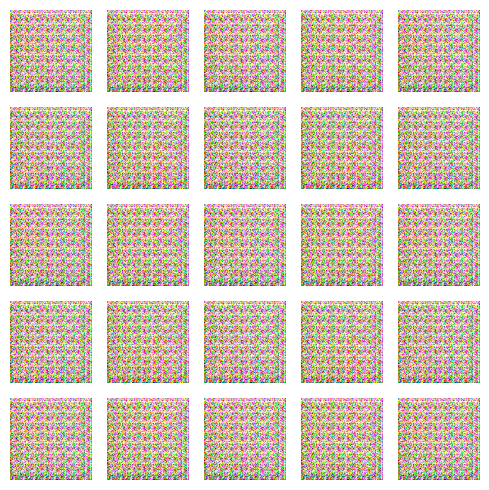

  0%|          | 0/500 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 713ms/step


  0%|          | 1/500 [00:03<27:52,  3.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


  0%|          | 2/500 [00:06<27:38,  3.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 707ms/step


  1%|          | 3/500 [00:11<32:00,  3.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step


  1%|          | 4/500 [00:14<28:36,  3.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step


  1%|          | 5/500 [00:17<27:10,  3.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step


  1%|          | 6/500 [00:19<26:03,  3.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step


  1%|▏         | 7/500 [00:23<27:29,  3.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 679ms/step


  2%|▏         | 8/500 [00:27<29:11,  3.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


  2%|▏         | 9/500 [00:30<27:02,  3.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step


  2%|▏         | 10/500 [00:33<26:21,  3.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


  2%|▏         | 11/500 [00:36<25:23,  3.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/step


  2%|▏         | 12/500 [00:40<28:37,  3.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step


  3%|▎         | 13/500 [00:43<27:35,  3.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step


  3%|▎         | 14/500 [00:46<26:02,  3.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step


  3%|▎         | 15/500 [00:49<25:30,  3.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step


  3%|▎         | 16/500 [00:53<26:22,  3.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 728ms/step


  3%|▎         | 17/500 [00:57<29:08,  3.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


  4%|▎         | 18/500 [01:00<27:58,  3.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


  4%|▍         | 19/500 [01:03<27:09,  3.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step


  4%|▍         | 20/500 [01:07<26:18,  3.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 714ms/step


  4%|▍         | 21/500 [01:11<29:38,  3.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


  4%|▍         | 22/500 [01:14<27:12,  3.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


  5%|▍         | 23/500 [01:17<25:25,  3.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


  5%|▍         | 24/500 [01:20<24:54,  3.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step


  5%|▌         | 25/500 [01:23<25:53,  3.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 697ms/step


  5%|▌         | 26/500 [01:28<28:50,  3.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 771ms/step


  5%|▌         | 27/500 [01:32<30:23,  3.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


  6%|▌         | 28/500 [01:35<28:57,  3.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 737ms/step


  6%|▌         | 29/500 [01:40<30:51,  3.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 511ms/step


  6%|▌         | 30/500 [01:43<28:35,  3.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step


  6%|▌         | 31/500 [01:46<27:02,  3.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step


  6%|▋         | 32/500 [01:49<26:21,  3.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step


  7%|▋         | 33/500 [01:53<27:31,  3.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 666ms/step


  7%|▋         | 34/500 [01:57<28:31,  3.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step


  7%|▋         | 35/500 [02:00<27:11,  3.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step


  7%|▋         | 36/500 [02:03<26:28,  3.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step


  7%|▋         | 37/500 [02:07<27:18,  3.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 747ms/step


  8%|▊         | 38/500 [02:11<28:33,  3.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step


  8%|▊         | 39/500 [02:14<27:15,  3.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step


  8%|▊         | 40/500 [02:17<25:53,  3.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


  8%|▊         | 41/500 [02:20<24:57,  3.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 688ms/step


  8%|▊         | 42/500 [02:25<28:26,  3.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step


  9%|▊         | 43/500 [02:28<27:08,  3.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step


  9%|▉         | 44/500 [02:31<25:52,  3.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step


  9%|▉         | 45/500 [02:34<24:30,  3.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


  9%|▉         | 46/500 [02:38<26:38,  3.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step


  9%|▉         | 47/500 [02:42<26:53,  3.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step


 10%|▉         | 48/500 [02:45<25:16,  3.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step


 10%|▉         | 49/500 [02:48<24:47,  3.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step


 10%|█         | 50/500 [02:52<25:28,  3.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 620ms/step


 10%|█         | 51/500 [02:56<26:38,  3.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step


 10%|█         | 52/500 [02:59<24:52,  3.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


 11%|█         | 53/500 [03:01<23:27,  3.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step


 11%|█         | 54/500 [03:04<23:16,  3.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step


 11%|█         | 55/500 [03:09<26:08,  3.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 688ms/step


 11%|█         | 56/500 [03:13<26:50,  3.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


 11%|█▏        | 57/500 [03:16<25:54,  3.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step


 12%|█▏        | 58/500 [03:19<24:27,  3.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step


 12%|█▏        | 59/500 [03:23<26:07,  3.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 691ms/step


 12%|█▏        | 60/500 [03:27<26:23,  3.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step


 12%|█▏        | 61/500 [03:29<24:48,  3.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step


 12%|█▏        | 62/500 [03:32<23:52,  3.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step


 13%|█▎        | 63/500 [03:36<24:10,  3.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 713ms/step


 13%|█▎        | 64/500 [03:40<25:55,  3.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


 13%|█▎        | 65/500 [03:43<24:21,  3.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step


 13%|█▎        | 66/500 [03:46<22:53,  3.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step


 13%|█▎        | 67/500 [03:48<21:53,  3.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


 14%|█▎        | 68/500 [03:53<24:18,  3.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 666ms/step


 14%|█▍        | 69/500 [03:56<25:23,  3.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step


 14%|█▍        | 70/500 [03:59<24:17,  3.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step


 14%|█▍        | 71/500 [04:03<23:34,  3.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step


 14%|█▍        | 72/500 [04:07<25:13,  3.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 714ms/step


 15%|█▍        | 73/500 [04:10<25:15,  3.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


 15%|█▍        | 74/500 [04:13<23:48,  3.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step


 15%|█▌        | 75/500 [04:16<22:27,  3.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 15%|█▌        | 76/500 [04:20<23:29,  3.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 706ms/step


 15%|█▌        | 77/500 [04:24<25:43,  3.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step


 16%|█▌        | 78/500 [04:27<24:11,  3.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step


 16%|█▌        | 79/500 [04:30<23:02,  3.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step


 16%|█▌        | 80/500 [04:33<22:34,  3.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 742ms/step


 16%|█▌        | 81/500 [04:38<26:15,  3.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step


 16%|█▋        | 82/500 [04:41<24:06,  3.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


 17%|█▋        | 83/500 [04:43<22:25,  3.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step


 17%|█▋        | 84/500 [04:46<21:17,  3.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step


 17%|█▋        | 85/500 [04:50<22:51,  3.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/step


 17%|█▋        | 86/500 [04:54<24:07,  3.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step


 17%|█▋        | 87/500 [04:57<23:00,  3.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 18%|█▊        | 88/500 [05:00<22:30,  3.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


 18%|█▊        | 89/500 [05:03<21:20,  3.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 510ms/step


 18%|█▊        | 90/500 [05:07<23:17,  3.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 680ms/step


 18%|█▊        | 91/500 [05:10<23:30,  3.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


 18%|█▊        | 92/500 [05:13<22:37,  3.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step


 19%|█▊        | 93/500 [05:16<21:49,  3.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


 19%|█▉        | 94/500 [05:20<22:50,  3.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 658ms/step


 19%|█▉        | 95/500 [05:25<25:14,  3.74s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


 19%|█▉        | 96/500 [05:28<23:35,  3.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step


 19%|█▉        | 97/500 [05:31<22:43,  3.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


 20%|█▉        | 98/500 [05:34<21:49,  3.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 712ms/step


 20%|█▉        | 99/500 [05:39<24:59,  3.74s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step


 20%|██        | 100/500 [05:41<22:50,  3.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


 20%|██        | 101/500 [05:44<21:21,  3.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step


 20%|██        | 102/500 [05:47<20:59,  3.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step


 21%|██        | 103/500 [05:51<22:35,  3.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 696ms/step


 21%|██        | 104/500 [05:55<23:02,  3.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


 21%|██        | 105/500 [05:58<21:39,  3.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step


 21%|██        | 106/500 [06:01<21:25,  3.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step


 21%|██▏       | 107/500 [06:04<21:41,  3.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 711ms/step


 22%|██▏       | 108/500 [06:09<24:12,  3.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step


 22%|██▏       | 109/500 [06:12<22:14,  3.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


 22%|██▏       | 110/500 [06:14<21:06,  3.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step


 22%|██▏       | 111/500 [06:17<20:25,  3.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step


 22%|██▏       | 112/500 [06:22<22:50,  3.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 770ms/step


 23%|██▎       | 113/500 [06:26<23:16,  3.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step


 23%|██▎       | 114/500 [06:28<21:51,  3.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step


 23%|██▎       | 115/500 [06:31<20:49,  3.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step


 23%|██▎       | 116/500 [06:35<21:20,  3.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 733ms/step


 23%|██▎       | 117/500 [06:39<23:18,  3.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step


 24%|██▎       | 118/500 [06:42<22:11,  3.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step


 24%|██▍       | 119/500 [06:45<21:20,  3.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step


 24%|██▍       | 120/500 [06:49<21:25,  3.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 743ms/step


 24%|██▍       | 121/500 [06:53<23:28,  3.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step


 24%|██▍       | 122/500 [06:57<22:36,  3.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step


 25%|██▍       | 123/500 [07:00<21:34,  3.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step


 25%|██▍       | 124/500 [07:03<20:28,  3.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 745ms/step


 25%|██▌       | 125/500 [07:07<22:29,  3.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step


 25%|██▌       | 126/500 [07:10<21:11,  3.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


 25%|██▌       | 127/500 [07:13<20:21,  3.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step


 26%|██▌       | 128/500 [07:16<19:37,  3.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 26%|██▌       | 129/500 [07:19<20:31,  3.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 689ms/step


 26%|██▌       | 130/500 [07:24<22:07,  3.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 26%|██▌       | 131/500 [07:26<20:29,  3.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step


 26%|██▋       | 132/500 [07:29<19:56,  3.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step


 27%|██▋       | 133/500 [07:32<19:26,  3.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 673ms/step


 27%|██▋       | 134/500 [07:37<21:13,  3.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 697ms/step


 27%|██▋       | 135/500 [07:40<21:26,  3.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step


 27%|██▋       | 136/500 [07:43<20:24,  3.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


 27%|██▋       | 137/500 [07:46<19:40,  3.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step


 28%|██▊       | 138/500 [07:50<20:40,  3.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 737ms/step


 28%|██▊       | 139/500 [07:54<21:45,  3.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step


 28%|██▊       | 140/500 [07:57<20:27,  3.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step


 28%|██▊       | 141/500 [08:01<22:07,  3.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 736ms/step


 28%|██▊       | 142/500 [08:06<24:07,  4.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 718ms/step


 29%|██▊       | 143/500 [08:10<23:29,  3.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


 29%|██▉       | 144/500 [08:13<21:20,  3.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step


 29%|██▉       | 145/500 [08:16<20:01,  3.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


 29%|██▉       | 146/500 [08:19<20:33,  3.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 687ms/step


 29%|██▉       | 147/500 [08:24<22:05,  3.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


 30%|██▉       | 148/500 [08:27<20:31,  3.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step


 30%|██▉       | 149/500 [08:30<19:47,  3.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


 30%|███       | 150/500 [08:33<20:08,  3.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 681ms/step


 30%|███       | 151/500 [08:38<21:32,  3.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step


 30%|███       | 152/500 [08:41<20:20,  3.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 31%|███       | 153/500 [08:44<19:14,  3.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step


 31%|███       | 154/500 [08:47<18:37,  3.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


 31%|███       | 155/500 [08:51<19:48,  3.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 713ms/step


 31%|███       | 156/500 [08:55<20:28,  3.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step


 31%|███▏      | 157/500 [08:58<19:33,  3.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


 32%|███▏      | 158/500 [09:01<18:43,  3.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


 32%|███▏      | 159/500 [09:04<19:24,  3.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 707ms/step


 32%|███▏      | 160/500 [09:08<20:16,  3.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


 32%|███▏      | 161/500 [09:11<18:48,  3.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step


 32%|███▏      | 162/500 [09:14<18:10,  3.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step


 33%|███▎      | 163/500 [09:17<17:32,  3.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


 33%|███▎      | 164/500 [09:21<18:58,  3.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 617ms/step


 33%|███▎      | 165/500 [09:24<19:21,  3.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step


 33%|███▎      | 166/500 [09:28<18:43,  3.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step


 33%|███▎      | 167/500 [09:31<18:07,  3.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step


 34%|███▎      | 168/500 [09:34<17:41,  3.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 724ms/step


 34%|███▍      | 169/500 [09:38<20:00,  3.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


 34%|███▍      | 170/500 [09:41<19:03,  3.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


 34%|███▍      | 171/500 [09:44<18:00,  3.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


 34%|███▍      | 172/500 [09:47<17:04,  3.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step


 35%|███▍      | 173/500 [09:50<17:20,  3.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 718ms/step


 35%|███▍      | 174/500 [09:54<18:34,  3.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


 35%|███▌      | 175/500 [09:57<17:57,  3.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 35%|███▌      | 176/500 [10:00<17:33,  3.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step


 35%|███▌      | 177/500 [10:03<16:59,  3.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step


 36%|███▌      | 178/500 [10:08<18:42,  3.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 701ms/step


 36%|███▌      | 179/500 [10:11<18:55,  3.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step


 36%|███▌      | 180/500 [10:14<18:06,  3.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step


 36%|███▌      | 181/500 [10:17<17:33,  3.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


 36%|███▋      | 182/500 [10:21<18:24,  3.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 676ms/step


 37%|███▋      | 183/500 [10:25<18:59,  3.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step


 37%|███▋      | 184/500 [10:28<18:05,  3.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step


 37%|███▋      | 185/500 [10:31<16:59,  3.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step


 37%|███▋      | 186/500 [10:34<16:24,  3.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


 37%|███▋      | 187/500 [10:38<17:52,  3.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 765ms/step


 38%|███▊      | 188/500 [10:42<18:04,  3.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


 38%|███▊      | 189/500 [10:44<16:57,  3.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step


 38%|███▊      | 190/500 [10:47<16:30,  3.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step


 38%|███▊      | 191/500 [10:51<16:55,  3.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 525ms/step


 38%|███▊      | 192/500 [10:55<18:19,  3.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


 39%|███▊      | 193/500 [10:58<17:39,  3.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


 39%|███▉      | 194/500 [11:01<16:50,  3.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


 39%|███▉      | 195/500 [11:04<16:32,  3.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 39%|███▉      | 196/500 [11:08<17:32,  3.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 677ms/step


 39%|███▉      | 197/500 [11:12<17:44,  3.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step


 40%|███▉      | 198/500 [11:15<16:36,  3.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step


 40%|███▉      | 199/500 [11:18<15:49,  3.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


 40%|████      | 200/500 [11:21<15:59,  3.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step


 40%|████      | 201/500 [11:25<17:40,  3.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step


 40%|████      | 202/500 [11:28<17:00,  3.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step


 41%|████      | 203/500 [11:31<16:09,  3.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step


 41%|████      | 204/500 [11:34<15:51,  3.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


 41%|████      | 205/500 [11:39<17:21,  3.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 763ms/step


 41%|████      | 206/500 [11:42<17:29,  3.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


 41%|████▏     | 207/500 [11:45<16:36,  3.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step


 42%|████▏     | 208/500 [11:48<16:02,  3.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


 42%|████▏     | 209/500 [11:52<16:58,  3.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 690ms/step


 42%|████▏     | 210/500 [11:56<17:16,  3.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step


 42%|████▏     | 211/500 [11:59<16:20,  3.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step


 42%|████▏     | 212/500 [12:02<16:01,  3.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step


 43%|████▎     | 213/500 [12:06<16:22,  3.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 688ms/step


 43%|████▎     | 214/500 [12:10<17:26,  3.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step


 43%|████▎     | 215/500 [12:13<16:13,  3.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 43%|████▎     | 216/500 [12:16<15:32,  3.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step


 43%|████▎     | 217/500 [12:19<15:20,  3.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 731ms/step


 44%|████▎     | 218/500 [12:24<17:51,  3.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step


 44%|████▍     | 219/500 [12:27<16:36,  3.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


 44%|████▍     | 220/500 [12:30<15:49,  3.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


 44%|████▍     | 221/500 [12:33<15:00,  3.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step


 44%|████▍     | 222/500 [12:37<16:10,  3.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 722ms/step


 45%|████▍     | 223/500 [12:41<16:59,  3.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step


 45%|████▍     | 224/500 [12:44<15:58,  3.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step


 45%|████▌     | 225/500 [12:47<15:14,  3.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 45%|████▌     | 226/500 [12:51<15:42,  3.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 692ms/step


 45%|████▌     | 227/500 [12:55<16:18,  3.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


 46%|████▌     | 228/500 [12:58<15:23,  3.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step


 46%|████▌     | 229/500 [13:01<14:53,  3.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


 46%|████▌     | 230/500 [13:04<14:19,  3.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step


 46%|████▌     | 231/500 [13:08<15:40,  3.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 703ms/step


 46%|████▋     | 232/500 [13:12<15:37,  3.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step


 47%|████▋     | 233/500 [13:14<14:41,  3.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step


 47%|████▋     | 234/500 [13:17<14:14,  3.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step


 47%|████▋     | 235/500 [13:21<14:49,  3.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 691ms/step


 47%|████▋     | 236/500 [13:26<16:13,  3.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step


 47%|████▋     | 237/500 [13:29<15:33,  3.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step


 48%|████▊     | 238/500 [13:32<15:00,  3.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step


 48%|████▊     | 239/500 [13:35<14:55,  3.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 654ms/step


 48%|████▊     | 240/500 [13:40<16:32,  3.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


 48%|████▊     | 241/500 [13:43<15:27,  3.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


 48%|████▊     | 242/500 [13:46<14:43,  3.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step


 49%|████▊     | 243/500 [13:49<14:12,  3.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 705ms/step


 49%|████▉     | 244/500 [13:54<16:06,  3.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step


 49%|████▉     | 245/500 [13:57<14:48,  3.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step


 49%|████▉     | 246/500 [14:00<14:02,  3.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step


 49%|████▉     | 247/500 [14:03<13:49,  3.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step


 50%|████▉     | 248/500 [14:07<15:03,  3.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 759ms/step


 50%|████▉     | 249/500 [14:11<15:07,  3.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step


 50%|█████     | 250/500 [14:14<14:23,  3.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step


 50%|█████     | 251/500 [14:17<13:25,  3.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


 50%|█████     | 252/500 [14:20<13:38,  3.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 697ms/step


 51%|█████     | 253/500 [14:25<14:49,  3.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


 51%|█████     | 254/500 [14:28<14:19,  3.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 710ms/step


 51%|█████     | 255/500 [14:32<15:37,  3.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step


 51%|█████     | 256/500 [14:36<15:22,  3.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 677ms/step


 51%|█████▏    | 257/500 [14:40<15:19,  3.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


 52%|█████▏    | 258/500 [14:43<14:26,  3.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step


 52%|█████▏    | 259/500 [14:46<13:54,  3.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step


 52%|█████▏    | 260/500 [14:49<13:01,  3.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 688ms/step


 52%|█████▏    | 261/500 [14:53<14:05,  3.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 738ms/step


 52%|█████▏    | 262/500 [14:56<13:42,  3.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step


 53%|█████▎    | 263/500 [15:00<13:18,  3.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step


 53%|█████▎    | 264/500 [15:03<13:03,  3.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


 53%|█████▎    | 265/500 [15:07<13:44,  3.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 671ms/step


 53%|█████▎    | 266/500 [15:10<13:51,  3.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step


 53%|█████▎    | 267/500 [15:13<13:13,  3.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step


 54%|█████▎    | 268/500 [15:16<12:41,  3.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 54%|█████▍    | 269/500 [15:20<12:39,  3.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 708ms/step


 54%|█████▍    | 270/500 [15:24<13:49,  3.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


 54%|█████▍    | 271/500 [15:27<12:57,  3.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


 54%|█████▍    | 272/500 [15:30<12:13,  3.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step


 55%|█████▍    | 273/500 [15:33<11:38,  3.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


 55%|█████▍    | 274/500 [15:37<12:47,  3.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 699ms/step


 55%|█████▌    | 275/500 [15:40<12:55,  3.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step


 55%|█████▌    | 276/500 [15:43<12:16,  3.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 55%|█████▌    | 277/500 [15:46<11:35,  3.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step


 56%|█████▌    | 278/500 [15:49<11:37,  3.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 665ms/step


 56%|█████▌    | 279/500 [15:54<13:10,  3.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step


 56%|█████▌    | 280/500 [15:57<12:38,  3.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step


 56%|█████▌    | 281/500 [16:00<12:21,  3.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


 56%|█████▋    | 282/500 [16:04<12:19,  3.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 704ms/step


 57%|█████▋    | 283/500 [16:08<13:14,  3.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step


 57%|█████▋    | 284/500 [16:11<12:24,  3.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step


 57%|█████▋    | 285/500 [16:14<12:01,  3.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


 57%|█████▋    | 286/500 [16:17<11:16,  3.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step


 57%|█████▋    | 287/500 [16:20<11:38,  3.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 693ms/step


 58%|█████▊    | 288/500 [16:24<12:36,  3.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step


 58%|█████▊    | 289/500 [16:27<11:58,  3.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


 58%|█████▊    | 290/500 [16:30<11:29,  3.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


 58%|█████▊    | 291/500 [16:34<11:34,  3.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 688ms/step


 58%|█████▊    | 292/500 [16:38<12:48,  3.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step


 59%|█████▊    | 293/500 [16:41<11:59,  3.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step


 59%|█████▉    | 294/500 [16:44<11:23,  3.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step


 59%|█████▉    | 295/500 [16:47<10:52,  3.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step


 59%|█████▉    | 296/500 [16:51<11:45,  3.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 653ms/step


 59%|█████▉    | 297/500 [16:55<11:47,  3.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


 60%|█████▉    | 298/500 [16:58<11:22,  3.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


 60%|█████▉    | 299/500 [17:01<10:55,  3.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step


 60%|██████    | 300/500 [17:04<11:06,  3.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 678ms/step


 60%|██████    | 301/500 [17:08<11:44,  3.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step


 60%|██████    | 302/500 [17:11<11:07,  3.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


 61%|██████    | 303/500 [17:14<10:34,  3.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


 61%|██████    | 304/500 [17:17<10:21,  3.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step


 61%|██████    | 305/500 [17:22<11:26,  3.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 726ms/step


 61%|██████    | 306/500 [17:25<11:11,  3.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


 61%|██████▏   | 307/500 [17:28<10:25,  3.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step


 62%|██████▏   | 308/500 [17:31<10:09,  3.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step


 62%|██████▏   | 309/500 [17:34<10:10,  3.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 681ms/step


 62%|██████▏   | 310/500 [17:39<11:31,  3.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 62%|██████▏   | 311/500 [17:42<10:53,  3.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step


 62%|██████▏   | 312/500 [17:45<10:23,  3.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


 63%|██████▎   | 313/500 [17:48<09:55,  3.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step


 63%|██████▎   | 314/500 [17:52<10:42,  3.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 773ms/step


 63%|██████▎   | 315/500 [17:55<10:40,  3.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


 63%|██████▎   | 316/500 [17:58<10:15,  3.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step


 63%|██████▎   | 317/500 [18:01<09:55,  3.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step


 64%|██████▎   | 318/500 [18:05<10:08,  3.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 651ms/step


 64%|██████▍   | 319/500 [18:09<11:03,  3.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


 64%|██████▍   | 320/500 [18:12<10:17,  3.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


 64%|██████▍   | 321/500 [18:15<09:39,  3.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step


 64%|██████▍   | 322/500 [18:18<09:18,  3.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step


 65%|██████▍   | 323/500 [18:22<10:15,  3.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 696ms/step


 65%|██████▍   | 324/500 [18:26<10:23,  3.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


 65%|██████▌   | 325/500 [18:29<09:49,  3.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step


 65%|██████▌   | 326/500 [18:32<09:15,  3.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step


 65%|██████▌   | 327/500 [18:35<09:35,  3.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 702ms/step


 66%|██████▌   | 328/500 [18:39<10:14,  3.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


 66%|██████▌   | 329/500 [18:42<09:41,  3.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step


 66%|██████▌   | 330/500 [18:45<09:10,  3.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


 66%|██████▌   | 331/500 [18:48<08:55,  3.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


 66%|██████▋   | 332/500 [18:52<09:46,  3.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 689ms/step


 67%|██████▋   | 333/500 [18:56<09:46,  3.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


 67%|██████▋   | 334/500 [18:59<09:03,  3.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


 67%|██████▋   | 335/500 [19:02<08:41,  3.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


 67%|██████▋   | 336/500 [19:05<09:06,  3.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 709ms/step


 67%|██████▋   | 337/500 [19:10<09:50,  3.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 68%|██████▊   | 338/500 [19:13<09:13,  3.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 68%|██████▊   | 339/500 [19:16<08:51,  3.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


 68%|██████▊   | 340/500 [19:19<08:33,  3.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 749ms/step


 68%|██████▊   | 341/500 [19:24<09:54,  3.74s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


 68%|██████▊   | 342/500 [19:27<09:18,  3.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


 69%|██████▊   | 343/500 [19:29<08:43,  3.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


 69%|██████▉   | 344/500 [19:32<08:23,  3.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


 69%|██████▉   | 345/500 [19:37<09:07,  3.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step


 69%|██████▉   | 346/500 [19:40<09:04,  3.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 69%|██████▉   | 347/500 [19:43<08:30,  3.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step


 70%|██████▉   | 348/500 [19:46<08:00,  3.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step


 70%|██████▉   | 349/500 [19:49<07:51,  3.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 709ms/step


 70%|███████   | 350/500 [19:54<09:02,  3.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step


 70%|███████   | 351/500 [19:57<08:27,  3.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


 70%|███████   | 352/500 [19:59<08:01,  3.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


 71%|███████   | 353/500 [20:02<07:43,  3.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step


 71%|███████   | 354/500 [20:07<08:24,  3.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 641ms/step


 71%|███████   | 355/500 [20:10<08:21,  3.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step


 71%|███████   | 356/500 [20:13<08:05,  3.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step


 71%|███████▏  | 357/500 [20:16<07:40,  3.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


 72%|███████▏  | 358/500 [20:19<07:32,  3.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 709ms/step


 72%|███████▏  | 359/500 [20:24<08:30,  3.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


 72%|███████▏  | 360/500 [20:27<07:56,  3.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step


 72%|███████▏  | 361/500 [20:30<07:38,  3.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step


 72%|███████▏  | 362/500 [20:33<07:17,  3.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step


 73%|███████▎  | 363/500 [20:37<07:43,  3.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 670ms/step


 73%|███████▎  | 364/500 [20:40<07:52,  3.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


 73%|███████▎  | 365/500 [20:43<07:25,  3.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step


 73%|███████▎  | 366/500 [20:46<07:04,  3.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step


 73%|███████▎  | 367/500 [20:50<07:26,  3.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 710ms/step


 74%|███████▎  | 368/500 [20:55<08:22,  3.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 709ms/step


 74%|███████▍  | 369/500 [20:59<08:43,  3.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step


 74%|███████▍  | 370/500 [21:02<08:08,  3.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step


 74%|███████▍  | 371/500 [21:07<08:29,  3.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 689ms/step


 74%|███████▍  | 372/500 [21:10<07:57,  3.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


 75%|███████▍  | 373/500 [21:13<07:24,  3.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


 75%|███████▍  | 374/500 [21:16<07:03,  3.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


 75%|███████▌  | 375/500 [21:19<07:02,  3.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 711ms/step


 75%|███████▌  | 376/500 [21:24<07:46,  3.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step


 75%|███████▌  | 377/500 [21:27<07:17,  3.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step


 76%|███████▌  | 378/500 [21:30<06:50,  3.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step


 76%|███████▌  | 379/500 [21:33<06:47,  3.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 681ms/step


 76%|███████▌  | 380/500 [21:38<07:29,  3.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step


 76%|███████▌  | 381/500 [21:41<07:08,  3.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


 76%|███████▋  | 382/500 [21:44<06:51,  3.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


 77%|███████▋  | 383/500 [21:47<06:26,  3.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 77%|███████▋  | 384/500 [21:51<06:51,  3.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 719ms/step


 77%|███████▋  | 385/500 [21:55<06:47,  3.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


 77%|███████▋  | 386/500 [21:58<06:23,  3.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step


 77%|███████▋  | 387/500 [22:01<06:11,  3.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


 78%|███████▊  | 388/500 [22:05<06:20,  3.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 696ms/step


 78%|███████▊  | 389/500 [22:09<06:53,  3.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step


 78%|███████▊  | 390/500 [22:12<06:28,  3.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 78%|███████▊  | 391/500 [22:15<06:08,  3.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step


 78%|███████▊  | 392/500 [22:19<06:01,  3.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 731ms/step


 79%|███████▊  | 393/500 [22:23<06:45,  3.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step


 79%|███████▉  | 394/500 [22:26<06:19,  3.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step


 79%|███████▉  | 395/500 [22:29<05:59,  3.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step


 79%|███████▉  | 396/500 [22:33<05:51,  3.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step


 79%|███████▉  | 397/500 [22:37<06:14,  3.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 730ms/step


 80%|███████▉  | 398/500 [22:41<06:13,  3.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step


 80%|███████▉  | 399/500 [22:44<05:49,  3.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step


 80%|████████  | 400/500 [22:46<05:24,  3.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


 80%|████████  | 401/500 [22:50<05:31,  3.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/step


 80%|████████  | 402/500 [22:55<06:01,  3.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step


 81%|████████  | 403/500 [22:58<05:45,  3.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step


 81%|████████  | 404/500 [23:01<05:32,  3.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 516ms/step


 81%|████████  | 405/500 [23:05<05:36,  3.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 697ms/step


 81%|████████  | 406/500 [23:09<05:52,  3.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step


 81%|████████▏ | 407/500 [23:12<05:29,  3.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


 82%|████████▏ | 408/500 [23:15<05:14,  3.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step


 82%|████████▏ | 409/500 [23:18<05:01,  3.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 500ms/step


 82%|████████▏ | 410/500 [23:22<05:20,  3.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 699ms/step


 82%|████████▏ | 411/500 [23:26<05:24,  3.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step


 82%|████████▏ | 412/500 [23:29<05:00,  3.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step


 83%|████████▎ | 413/500 [23:32<04:50,  3.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step


 83%|████████▎ | 414/500 [23:36<04:59,  3.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 646ms/step


 83%|████████▎ | 415/500 [23:40<05:04,  3.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


 83%|████████▎ | 416/500 [23:43<04:43,  3.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step


 83%|████████▎ | 417/500 [23:46<04:32,  3.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step


 84%|████████▎ | 418/500 [23:49<04:26,  3.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 751ms/step


 84%|████████▍ | 419/500 [23:54<05:09,  3.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step


 84%|████████▍ | 420/500 [23:57<04:50,  3.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step


 84%|████████▍ | 421/500 [24:01<04:37,  3.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step


 84%|████████▍ | 422/500 [24:03<04:18,  3.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step


 85%|████████▍ | 423/500 [24:08<04:36,  3.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 718ms/step


 85%|████████▍ | 424/500 [24:11<04:30,  3.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step


 85%|████████▌ | 425/500 [24:14<04:12,  3.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step


 85%|████████▌ | 426/500 [24:17<04:03,  3.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


 85%|████████▌ | 427/500 [24:21<04:08,  3.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 754ms/step


 86%|████████▌ | 428/500 [24:25<04:31,  3.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 86%|████████▌ | 429/500 [24:28<04:11,  3.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step


 86%|████████▌ | 430/500 [24:32<03:58,  3.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 514ms/step


 86%|████████▌ | 431/500 [24:35<03:55,  3.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 749ms/step


 86%|████████▋ | 432/500 [24:40<04:17,  3.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


 87%|████████▋ | 433/500 [24:42<03:54,  3.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step


 87%|████████▋ | 434/500 [24:46<03:42,  3.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


 87%|████████▋ | 435/500 [24:49<03:32,  3.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step


 87%|████████▋ | 436/500 [24:53<03:50,  3.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 769ms/step


 87%|████████▋ | 437/500 [24:57<03:53,  3.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step


 88%|████████▊ | 438/500 [25:00<03:37,  3.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step


 88%|████████▊ | 439/500 [25:03<03:25,  3.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 88%|████████▊ | 440/500 [25:06<03:25,  3.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 749ms/step


 88%|████████▊ | 441/500 [25:11<03:36,  3.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step


 88%|████████▊ | 442/500 [25:14<03:23,  3.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step


 89%|████████▊ | 443/500 [25:17<03:13,  3.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step


 89%|████████▉ | 444/500 [25:20<03:08,  3.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 710ms/step


 89%|████████▉ | 445/500 [25:25<03:24,  3.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step


 89%|████████▉ | 446/500 [25:28<03:06,  3.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


 89%|████████▉ | 447/500 [25:31<02:56,  3.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step


 90%|████████▉ | 448/500 [25:34<02:51,  3.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 677ms/step


 90%|████████▉ | 449/500 [25:39<03:12,  3.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step


 90%|█████████ | 450/500 [25:42<02:55,  3.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


 90%|█████████ | 451/500 [25:45<02:47,  3.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


 90%|█████████ | 452/500 [25:48<02:40,  3.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 91%|█████████ | 453/500 [25:52<02:49,  3.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 731ms/step


 91%|█████████ | 454/500 [25:56<02:45,  3.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step


 91%|█████████ | 455/500 [25:59<02:34,  3.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step


 91%|█████████ | 456/500 [26:02<02:26,  3.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step


 91%|█████████▏| 457/500 [26:06<02:30,  3.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 714ms/step


 92%|█████████▏| 458/500 [26:10<02:32,  3.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step


 92%|█████████▏| 459/500 [26:13<02:22,  3.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step


 92%|█████████▏| 460/500 [26:16<02:14,  3.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step


 92%|█████████▏| 461/500 [26:19<02:04,  3.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step


 92%|█████████▏| 462/500 [26:23<02:13,  3.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 740ms/step


 93%|█████████▎| 463/500 [26:27<02:10,  3.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


 93%|█████████▎| 464/500 [26:30<02:01,  3.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step


 93%|█████████▎| 465/500 [26:33<01:55,  3.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step


 93%|█████████▎| 466/500 [26:36<01:55,  3.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 644ms/step


 93%|█████████▎| 467/500 [26:41<02:02,  3.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step


 94%|█████████▎| 468/500 [26:44<01:50,  3.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step


 94%|█████████▍| 469/500 [26:47<01:43,  3.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


 94%|█████████▍| 470/500 [26:50<01:35,  3.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


 94%|█████████▍| 471/500 [26:54<01:40,  3.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 687ms/step


 94%|█████████▍| 472/500 [26:57<01:37,  3.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


 95%|█████████▍| 473/500 [27:00<01:29,  3.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step


 95%|█████████▍| 474/500 [27:03<01:24,  3.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


 95%|█████████▌| 475/500 [27:07<01:23,  3.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 656ms/step


 95%|█████████▌| 476/500 [27:11<01:29,  3.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step


 95%|█████████▌| 477/500 [27:14<01:18,  3.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step


 96%|█████████▌| 478/500 [27:19<01:21,  3.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 737ms/step


 96%|█████████▌| 479/500 [27:23<01:23,  4.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 704ms/step


 96%|█████████▌| 480/500 [27:27<01:18,  3.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step


 96%|█████████▌| 481/500 [27:30<01:09,  3.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step


 96%|█████████▋| 482/500 [27:33<01:02,  3.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step


 97%|█████████▋| 483/500 [27:37<01:00,  3.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 674ms/step


 97%|█████████▋| 484/500 [27:41<00:59,  3.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


 97%|█████████▋| 485/500 [27:44<00:53,  3.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step


 97%|█████████▋| 486/500 [27:47<00:46,  3.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


 97%|█████████▋| 487/500 [27:50<00:43,  3.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 657ms/step


 98%|█████████▊| 488/500 [27:55<00:43,  3.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step


 98%|█████████▊| 489/500 [27:58<00:37,  3.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step


 98%|█████████▊| 490/500 [28:01<00:33,  3.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step


 98%|█████████▊| 491/500 [28:04<00:29,  3.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


 98%|█████████▊| 492/500 [28:07<00:26,  3.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 691ms/step


 99%|█████████▊| 493/500 [28:11<00:24,  3.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step


 99%|█████████▉| 494/500 [28:14<00:19,  3.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


 99%|█████████▉| 495/500 [28:16<00:15,  3.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step


 99%|█████████▉| 496/500 [28:19<00:12,  3.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 748ms/step


 99%|█████████▉| 497/500 [28:24<00:10,  3.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step


100%|█████████▉| 498/500 [28:27<00:06,  3.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


100%|█████████▉| 499/500 [28:30<00:03,  3.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


100%|██████████| 500/500 [28:33<00:00,  3.43s/it]


Epoch: 7 	 Discriminator Loss: 0.6635864973068237 		 Generator Loss: [array(0.6635865), array(0.6635865), array(0.6635865)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


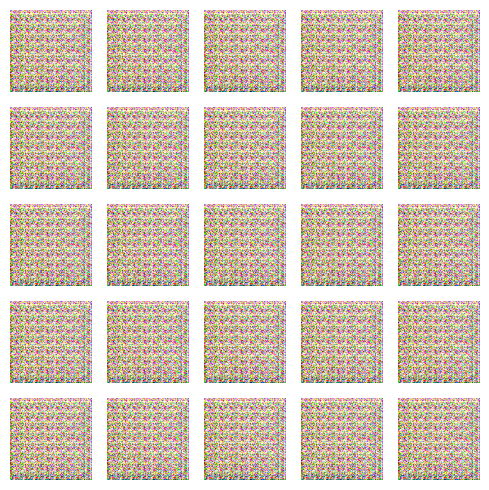

  0%|          | 0/500 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 722ms/step


  0%|          | 1/500 [00:03<29:47,  3.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step


  0%|          | 2/500 [00:06<26:57,  3.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step


  1%|          | 3/500 [00:10<27:55,  3.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 673ms/step


  1%|          | 4/500 [00:13<28:51,  3.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


  1%|          | 5/500 [00:16<26:35,  3.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step


  1%|          | 6/500 [00:19<26:04,  3.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


  1%|▏         | 7/500 [00:23<26:55,  3.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 701ms/step


  2%|▏         | 8/500 [00:27<30:11,  3.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step


  2%|▏         | 9/500 [00:30<28:02,  3.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step


  2%|▏         | 10/500 [00:33<26:22,  3.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step


  2%|▏         | 11/500 [00:36<25:28,  3.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step


  2%|▏         | 12/500 [00:40<28:27,  3.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 717ms/step


  3%|▎         | 13/500 [00:43<28:07,  3.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step


  3%|▎         | 14/500 [00:47<27:38,  3.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step


  3%|▎         | 15/500 [00:50<26:29,  3.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step


  3%|▎         | 16/500 [00:54<28:43,  3.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 768ms/step


  3%|▎         | 17/500 [00:58<29:09,  3.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step


  4%|▎         | 18/500 [01:00<26:49,  3.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step


  4%|▍         | 19/500 [01:03<25:49,  3.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


  4%|▍         | 20/500 [01:07<27:11,  3.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 687ms/step


  4%|▍         | 21/500 [01:11<29:08,  3.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step


  4%|▍         | 22/500 [01:14<27:03,  3.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step


  5%|▍         | 23/500 [01:17<25:33,  3.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step


  5%|▍         | 24/500 [01:20<25:42,  3.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 723ms/step


  5%|▌         | 25/500 [01:25<28:21,  3.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 682ms/step


  5%|▌         | 26/500 [01:28<27:07,  3.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step


  5%|▌         | 27/500 [01:31<25:55,  3.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step


  6%|▌         | 28/500 [01:34<25:15,  3.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step


  6%|▌         | 29/500 [01:37<26:14,  3.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 709ms/step


  6%|▌         | 30/500 [01:42<28:54,  3.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


  6%|▌         | 31/500 [01:45<26:35,  3.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step


  6%|▋         | 32/500 [01:47<25:23,  3.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


  7%|▋         | 33/500 [01:51<25:08,  3.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 693ms/step


  7%|▋         | 34/500 [01:56<28:51,  3.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


  7%|▋         | 35/500 [01:59<27:20,  3.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step


  7%|▋         | 36/500 [02:02<26:00,  3.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


  7%|▋         | 37/500 [02:04<24:51,  3.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


  8%|▊         | 38/500 [02:08<26:24,  3.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 652ms/step


  8%|▊         | 39/500 [02:12<27:23,  3.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step


  8%|▊         | 40/500 [02:15<26:00,  3.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step


  8%|▊         | 41/500 [02:18<25:24,  3.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step


  8%|▊         | 42/500 [02:22<25:39,  3.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step


  9%|▊         | 43/500 [02:26<27:51,  3.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


  9%|▉         | 44/500 [02:29<25:43,  3.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step


  9%|▉         | 45/500 [02:32<24:54,  3.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step


  9%|▉         | 46/500 [02:35<23:49,  3.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step


  9%|▉         | 47/500 [02:39<25:25,  3.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 754ms/step


 10%|▉         | 48/500 [02:43<27:08,  3.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step


 10%|▉         | 49/500 [02:46<25:57,  3.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step


 10%|█         | 50/500 [02:49<25:10,  3.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step


 10%|█         | 51/500 [02:53<25:23,  3.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 712ms/step


 10%|█         | 52/500 [02:57<28:05,  3.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step


 11%|█         | 53/500 [03:00<26:06,  3.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


 11%|█         | 54/500 [03:03<24:20,  3.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step


 11%|█         | 55/500 [03:06<23:30,  3.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 11%|█         | 56/500 [03:10<25:19,  3.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 689ms/step


 11%|█▏        | 57/500 [03:14<26:22,  3.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step


 12%|█▏        | 58/500 [03:17<25:07,  3.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step


 12%|█▏        | 59/500 [03:20<24:08,  3.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step


 12%|█▏        | 60/500 [03:23<24:45,  3.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 721ms/step


 12%|█▏        | 61/500 [03:28<27:11,  3.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step


 12%|█▏        | 62/500 [03:31<25:21,  3.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step


 13%|█▎        | 63/500 [03:34<24:47,  3.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step


 13%|█▎        | 64/500 [03:37<23:52,  3.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 510ms/step


 13%|█▎        | 65/500 [03:41<26:10,  3.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 736ms/step


 13%|█▎        | 66/500 [03:45<26:24,  3.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step


 13%|█▎        | 67/500 [03:48<24:43,  3.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step


 14%|█▎        | 68/500 [03:51<23:44,  3.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


 14%|█▍        | 69/500 [03:55<25:03,  3.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 693ms/step


 14%|█▍        | 70/500 [03:59<25:48,  3.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step


 14%|█▍        | 71/500 [04:01<23:45,  3.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


 14%|█▍        | 72/500 [04:04<22:40,  3.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


 15%|█▍        | 73/500 [04:07<21:59,  3.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step


 15%|█▍        | 74/500 [04:11<24:19,  3.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 687ms/step


 15%|█▌        | 75/500 [04:15<23:59,  3.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step


 15%|█▌        | 76/500 [04:18<22:46,  3.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step


 15%|█▌        | 77/500 [04:21<22:42,  3.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step


 16%|█▌        | 78/500 [04:24<23:18,  3.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 667ms/step


 16%|█▌        | 79/500 [04:29<26:03,  3.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


 16%|█▌        | 80/500 [04:32<23:57,  3.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step


 16%|█▌        | 81/500 [04:35<23:16,  3.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 16%|█▋        | 82/500 [04:38<22:20,  3.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step


 17%|█▋        | 83/500 [04:42<24:12,  3.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/step


 17%|█▋        | 84/500 [04:46<24:34,  3.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step


 17%|█▋        | 85/500 [04:49<23:37,  3.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step


 17%|█▋        | 86/500 [04:52<23:13,  3.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step


 17%|█▋        | 87/500 [04:56<24:41,  3.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 790ms/step


 18%|█▊        | 88/500 [05:01<27:55,  4.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 710ms/step


 18%|█▊        | 89/500 [05:05<27:02,  3.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step


 18%|█▊        | 90/500 [05:08<24:39,  3.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


 18%|█▊        | 91/500 [05:11<23:08,  3.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


 18%|█▊        | 92/500 [05:15<24:24,  3.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 721ms/step


 19%|█▊        | 93/500 [05:19<24:57,  3.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step


 19%|█▉        | 94/500 [05:22<23:52,  3.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step


 19%|█▉        | 95/500 [05:25<22:43,  3.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step


 19%|█▉        | 96/500 [05:29<23:48,  3.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 661ms/step


 19%|█▉        | 97/500 [05:32<23:44,  3.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step


 20%|█▉        | 98/500 [05:35<22:42,  3.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


 20%|█▉        | 99/500 [05:38<21:33,  3.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


 20%|██        | 100/500 [05:41<21:46,  3.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 713ms/step


 20%|██        | 101/500 [05:46<24:42,  3.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step


 20%|██        | 102/500 [05:49<23:01,  3.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step


 21%|██        | 103/500 [05:52<22:06,  3.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step


 21%|██        | 104/500 [05:55<21:39,  3.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 668ms/step


 21%|██        | 105/500 [06:00<24:43,  3.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


 21%|██        | 106/500 [06:03<22:56,  3.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step


 21%|██▏       | 107/500 [06:06<21:45,  3.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


 22%|██▏       | 108/500 [06:09<21:08,  3.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step


 22%|██▏       | 109/500 [06:13<22:40,  3.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 728ms/step


 22%|██▏       | 110/500 [06:17<23:25,  3.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


 22%|██▏       | 111/500 [06:20<22:24,  3.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step


 22%|██▏       | 112/500 [06:23<21:25,  3.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 23%|██▎       | 113/500 [06:26<21:24,  3.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 682ms/step


 23%|██▎       | 114/500 [06:31<23:46,  3.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step


 23%|██▎       | 115/500 [06:34<22:35,  3.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step


 23%|██▎       | 116/500 [06:37<21:13,  3.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


 23%|██▎       | 117/500 [06:40<20:39,  3.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step


 24%|██▎       | 118/500 [06:44<22:35,  3.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 755ms/step


 24%|██▍       | 119/500 [06:48<22:28,  3.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step


 24%|██▍       | 120/500 [06:51<21:34,  3.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step


 24%|██▍       | 121/500 [06:54<20:59,  3.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step


 24%|██▍       | 122/500 [06:58<21:32,  3.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 733ms/step


 25%|██▍       | 123/500 [07:02<23:10,  3.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step


 25%|██▍       | 124/500 [07:05<21:39,  3.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


 25%|██▌       | 125/500 [07:08<20:22,  3.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


 25%|██▌       | 126/500 [07:10<19:19,  3.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 507ms/step


 25%|██▌       | 127/500 [07:15<21:21,  3.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 696ms/step


 26%|██▌       | 128/500 [07:18<21:46,  3.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step


 26%|██▌       | 129/500 [07:21<21:08,  3.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 26%|██▌       | 130/500 [07:25<20:35,  3.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step


 26%|██▌       | 131/500 [07:28<21:33,  3.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 684ms/step


 26%|██▋       | 132/500 [07:32<22:01,  3.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


 27%|██▋       | 133/500 [07:35<20:40,  3.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step


 27%|██▋       | 134/500 [07:38<20:05,  3.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step


 27%|██▋       | 135/500 [07:41<19:46,  3.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 736ms/step


 27%|██▋       | 136/500 [07:46<22:55,  3.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step


 27%|██▋       | 137/500 [07:49<21:34,  3.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 28%|██▊       | 138/500 [07:53<20:40,  3.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step


 28%|██▊       | 139/500 [07:56<19:50,  3.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step


 28%|██▊       | 140/500 [08:00<21:17,  3.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 690ms/step


 28%|██▊       | 141/500 [08:03<21:21,  3.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


 28%|██▊       | 142/500 [08:06<20:15,  3.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step


 29%|██▊       | 143/500 [08:09<19:11,  3.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step


 29%|██▉       | 144/500 [08:13<19:54,  3.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 680ms/step


 29%|██▉       | 145/500 [08:17<21:44,  3.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step


 29%|██▉       | 146/500 [08:20<20:37,  3.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step


 29%|██▉       | 147/500 [08:23<19:47,  3.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step


 30%|██▉       | 148/500 [08:26<19:19,  3.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step


 30%|██▉       | 149/500 [08:31<21:42,  3.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step


 30%|███       | 150/500 [08:34<20:19,  3.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


 30%|███       | 151/500 [08:37<19:09,  3.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


 30%|███       | 152/500 [08:40<18:40,  3.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


 31%|███       | 153/500 [08:44<20:22,  3.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 725ms/step


 31%|███       | 154/500 [08:48<20:50,  3.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step


 31%|███       | 155/500 [08:51<19:43,  3.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step


 31%|███       | 156/500 [08:54<19:00,  3.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


 31%|███▏      | 157/500 [08:58<20:07,  3.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 762ms/step


 32%|███▏      | 158/500 [09:02<21:05,  3.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step


 32%|███▏      | 159/500 [09:05<19:52,  3.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step


 32%|███▏      | 160/500 [09:08<19:19,  3.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step


 32%|███▏      | 161/500 [09:11<18:28,  3.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 751ms/step


 32%|███▏      | 162/500 [09:16<21:19,  3.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step


 33%|███▎      | 163/500 [09:20<20:09,  3.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step


 33%|███▎      | 164/500 [09:23<19:30,  3.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step


 33%|███▎      | 165/500 [09:26<18:34,  3.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step


 33%|███▎      | 166/500 [09:30<19:55,  3.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 716ms/step


 33%|███▎      | 167/500 [09:34<19:57,  3.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step


 34%|███▎      | 168/500 [09:37<18:51,  3.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step


 34%|███▍      | 169/500 [09:40<18:11,  3.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step


 34%|███▍      | 170/500 [09:43<18:21,  3.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 696ms/step


 34%|███▍      | 171/500 [09:47<20:02,  3.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step


 34%|███▍      | 172/500 [09:50<18:43,  3.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step


 35%|███▍      | 173/500 [09:53<18:19,  3.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step


 35%|███▍      | 174/500 [09:57<18:26,  3.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 641ms/step


 35%|███▌      | 175/500 [10:01<19:55,  3.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


 35%|███▌      | 176/500 [10:04<18:47,  3.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


 35%|███▌      | 177/500 [10:07<17:49,  3.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


 36%|███▌      | 178/500 [10:10<17:03,  3.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step


 36%|███▌      | 179/500 [10:14<18:21,  3.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 726ms/step


 36%|███▌      | 180/500 [10:18<18:39,  3.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 36%|███▌      | 181/500 [10:21<18:07,  3.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step


 36%|███▋      | 182/500 [10:24<17:24,  3.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step


 37%|███▋      | 183/500 [10:28<17:47,  3.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 684ms/step


 37%|███▋      | 184/500 [10:32<19:11,  3.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step


 37%|███▋      | 185/500 [10:35<17:58,  3.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


 37%|███▋      | 186/500 [10:38<17:00,  3.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


 37%|███▋      | 187/500 [10:41<16:34,  3.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 782ms/step


 38%|███▊      | 188/500 [10:45<18:22,  3.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 707ms/step


 38%|███▊      | 189/500 [10:48<18:12,  3.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step


 38%|███▊      | 190/500 [10:52<17:36,  3.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step


 38%|███▊      | 191/500 [10:55<16:54,  3.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step


 38%|███▊      | 192/500 [10:58<17:16,  3.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 757ms/step


 39%|███▊      | 193/500 [11:02<18:15,  3.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


 39%|███▉      | 194/500 [11:05<17:26,  3.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step


 39%|███▉      | 195/500 [11:08<16:36,  3.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


 39%|███▉      | 196/500 [11:12<17:22,  3.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 787ms/step


 39%|███▉      | 197/500 [11:17<19:17,  3.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 781ms/step


 40%|███▉      | 198/500 [11:21<19:42,  3.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step


 40%|███▉      | 199/500 [11:24<18:26,  3.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step


 40%|████      | 200/500 [11:27<17:28,  3.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


 40%|████      | 201/500 [11:30<16:41,  3.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 664ms/step


 40%|████      | 202/500 [11:34<18:13,  3.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 704ms/step


 41%|████      | 203/500 [11:38<18:25,  3.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step


 41%|████      | 204/500 [11:41<17:18,  3.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


 41%|████      | 205/500 [11:44<16:31,  3.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


 41%|████      | 206/500 [11:48<17:35,  3.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms/step


 41%|████▏     | 207/500 [11:52<17:24,  3.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 42%|████▏     | 208/500 [11:55<16:36,  3.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step


 42%|████▏     | 209/500 [11:58<15:48,  3.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step


 42%|████▏     | 210/500 [12:01<15:07,  3.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 666ms/step


 42%|████▏     | 211/500 [12:06<17:54,  3.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step


 42%|████▏     | 212/500 [12:09<16:39,  3.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


 43%|████▎     | 213/500 [12:11<15:36,  3.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


 43%|████▎     | 214/500 [12:15<15:16,  3.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


 43%|████▎     | 215/500 [12:18<15:59,  3.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 666ms/step


 43%|████▎     | 216/500 [12:22<16:52,  3.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


 43%|████▎     | 217/500 [12:25<15:44,  3.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step


 44%|████▎     | 218/500 [12:28<15:24,  3.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


 44%|████▍     | 219/500 [12:32<15:25,  3.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step


 44%|████▍     | 220/500 [12:36<16:55,  3.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


 44%|████▍     | 221/500 [12:39<16:01,  3.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step


 44%|████▍     | 222/500 [12:42<15:07,  3.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step


 45%|████▍     | 223/500 [12:45<14:47,  3.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step


 45%|████▍     | 224/500 [12:49<15:55,  3.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 758ms/step


 45%|████▌     | 225/500 [12:53<16:31,  3.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step


 45%|████▌     | 226/500 [12:56<15:58,  3.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


 45%|████▌     | 227/500 [12:59<15:09,  3.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step


 46%|████▌     | 228/500 [13:03<15:52,  3.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 703ms/step


 46%|████▌     | 229/500 [13:07<16:37,  3.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step


 46%|████▌     | 230/500 [13:10<15:41,  3.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


 46%|████▌     | 231/500 [13:13<15:02,  3.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step


 46%|████▋     | 232/500 [13:16<14:34,  3.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 508ms/step


 47%|████▋     | 233/500 [13:21<16:02,  3.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 704ms/step


 47%|████▋     | 234/500 [13:25<16:23,  3.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step


 47%|████▋     | 235/500 [13:28<15:33,  3.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step


 47%|████▋     | 236/500 [13:31<14:52,  3.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step


 47%|████▋     | 237/500 [13:35<15:28,  3.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 657ms/step


 48%|████▊     | 238/500 [13:38<15:39,  3.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step


 48%|████▊     | 239/500 [13:41<14:44,  3.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


 48%|████▊     | 240/500 [13:44<14:04,  3.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step


 48%|████▊     | 241/500 [13:48<14:11,  3.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 661ms/step


 48%|████▊     | 242/500 [13:52<15:50,  3.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step


 49%|████▊     | 243/500 [13:55<14:52,  3.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


 49%|████▉     | 244/500 [13:58<13:55,  3.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step


 49%|████▉     | 245/500 [14:01<13:22,  3.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


 49%|████▉     | 246/500 [14:05<14:36,  3.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 703ms/step


 49%|████▉     | 247/500 [14:09<15:03,  3.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


 50%|████▉     | 248/500 [14:12<14:29,  3.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step


 50%|████▉     | 249/500 [14:15<13:46,  3.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


 50%|█████     | 250/500 [14:19<14:25,  3.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 715ms/step


 50%|█████     | 251/500 [14:23<15:03,  3.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step


 50%|█████     | 252/500 [14:26<14:16,  3.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


 51%|█████     | 253/500 [14:29<13:47,  3.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step


 51%|█████     | 254/500 [14:33<14:11,  3.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 680ms/step


 51%|█████     | 255/500 [14:37<15:11,  3.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step


 51%|█████     | 256/500 [14:40<13:57,  3.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step


 51%|█████▏    | 257/500 [14:43<13:35,  3.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step


 52%|█████▏    | 258/500 [14:46<13:12,  3.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 658ms/step


 52%|█████▏    | 259/500 [14:51<15:09,  3.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step


 52%|█████▏    | 260/500 [14:54<14:07,  3.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step


 52%|█████▏    | 261/500 [14:57<13:17,  3.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step


 52%|█████▏    | 262/500 [15:00<12:50,  3.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step


 53%|█████▎    | 263/500 [15:04<14:03,  3.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 654ms/step


 53%|█████▎    | 264/500 [15:07<13:38,  3.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


 53%|█████▎    | 265/500 [15:10<12:47,  3.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step


 53%|█████▎    | 266/500 [15:13<12:39,  3.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step


 53%|█████▎    | 267/500 [15:17<12:52,  3.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 678ms/step


 54%|█████▎    | 268/500 [15:21<14:10,  3.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


 54%|█████▍    | 269/500 [15:24<13:32,  3.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step


 54%|█████▍    | 270/500 [15:27<12:45,  3.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step


 54%|█████▍    | 271/500 [15:30<12:03,  3.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step


 54%|█████▍    | 272/500 [15:34<13:06,  3.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 721ms/step


 55%|█████▍    | 273/500 [15:38<12:50,  3.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


 55%|█████▍    | 274/500 [15:40<12:11,  3.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step


 55%|█████▌    | 275/500 [15:43<11:39,  3.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


 55%|█████▌    | 276/500 [15:47<11:52,  3.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 670ms/step


 55%|█████▌    | 277/500 [15:51<13:35,  3.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step


 56%|█████▌    | 278/500 [15:54<12:30,  3.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step


 56%|█████▌    | 279/500 [15:57<12:02,  3.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step


 56%|█████▌    | 280/500 [16:00<11:42,  3.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step


 56%|█████▌    | 281/500 [16:04<12:49,  3.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 661ms/step


 56%|█████▋    | 282/500 [16:08<12:49,  3.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


 57%|█████▋    | 283/500 [16:11<11:54,  3.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


 57%|█████▋    | 284/500 [16:14<11:29,  3.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step


 57%|█████▋    | 285/500 [16:17<11:52,  3.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 685ms/step


 57%|█████▋    | 286/500 [16:22<13:00,  3.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step


 57%|█████▋    | 287/500 [16:25<12:18,  3.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step


 58%|█████▊    | 288/500 [16:28<11:40,  3.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step


 58%|█████▊    | 289/500 [16:31<11:26,  3.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 684ms/step


 58%|█████▊    | 290/500 [16:36<13:06,  3.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step


 58%|█████▊    | 291/500 [16:38<12:08,  3.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step


 58%|█████▊    | 292/500 [16:41<11:23,  3.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 59%|█████▊    | 293/500 [16:44<10:59,  3.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


 59%|█████▉    | 294/500 [16:48<11:21,  3.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step


 59%|█████▉    | 295/500 [16:52<11:50,  3.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


 59%|█████▉    | 296/500 [16:54<11:05,  3.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


 59%|█████▉    | 297/500 [16:57<10:40,  3.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step


 60%|█████▉    | 298/500 [17:01<10:37,  3.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 720ms/step


 60%|█████▉    | 299/500 [17:05<12:11,  3.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step


 60%|██████    | 300/500 [17:08<11:13,  3.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step


 60%|██████    | 301/500 [17:11<10:41,  3.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 60%|██████    | 302/500 [17:14<10:16,  3.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


 61%|██████    | 303/500 [17:18<10:53,  3.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 708ms/step


 61%|██████    | 304/500 [17:21<11:19,  3.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step


 61%|██████    | 305/500 [17:25<11:51,  3.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step


 61%|██████    | 306/500 [17:29<11:51,  3.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


 61%|██████▏   | 307/500 [17:33<12:14,  3.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 782ms/step


 62%|██████▏   | 308/500 [17:37<12:15,  3.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step


 62%|██████▏   | 309/500 [17:40<11:20,  3.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step


 62%|██████▏   | 310/500 [17:43<10:45,  3.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


 62%|██████▏   | 311/500 [17:47<11:01,  3.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 730ms/step


 62%|██████▏   | 312/500 [17:51<11:42,  3.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step


 63%|██████▎   | 313/500 [17:54<10:59,  3.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step


 63%|██████▎   | 314/500 [17:57<10:25,  3.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


 63%|██████▎   | 315/500 [18:01<10:40,  3.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 706ms/step


 63%|██████▎   | 316/500 [18:05<11:30,  3.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


 63%|██████▎   | 317/500 [18:08<10:45,  3.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


 64%|██████▎   | 318/500 [18:11<09:58,  3.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step


 64%|██████▍   | 319/500 [18:14<09:31,  3.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


 64%|██████▍   | 320/500 [18:18<09:58,  3.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 694ms/step


 64%|██████▍   | 321/500 [18:21<10:15,  3.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step


 64%|██████▍   | 322/500 [18:24<09:40,  3.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step


 65%|██████▍   | 323/500 [18:27<09:18,  3.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


 65%|██████▍   | 324/500 [18:30<09:15,  3.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 668ms/step


 65%|██████▌   | 325/500 [18:35<10:27,  3.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


 65%|██████▌   | 326/500 [18:38<09:46,  3.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step


 65%|██████▌   | 327/500 [18:41<09:23,  3.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step


 66%|██████▌   | 328/500 [18:44<09:10,  3.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step


 66%|██████▌   | 329/500 [18:48<09:56,  3.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 640ms/step


 66%|██████▌   | 330/500 [18:51<09:46,  3.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step


 66%|██████▌   | 331/500 [18:54<09:21,  3.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


 66%|██████▋   | 332/500 [18:57<08:59,  3.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


 67%|██████▋   | 333/500 [19:01<09:03,  3.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step


 67%|██████▋   | 334/500 [19:05<09:54,  3.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step


 67%|██████▋   | 335/500 [19:08<09:22,  3.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


 67%|██████▋   | 336/500 [19:11<09:01,  3.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step


 67%|██████▋   | 337/500 [19:14<08:40,  3.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step


 68%|██████▊   | 338/500 [19:18<09:04,  3.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 686ms/step


 68%|██████▊   | 339/500 [19:21<09:20,  3.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step


 68%|██████▊   | 340/500 [19:25<08:59,  3.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step


 68%|██████▊   | 341/500 [19:27<08:26,  3.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


 68%|██████▊   | 342/500 [19:30<08:22,  3.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 656ms/step


 69%|██████▊   | 343/500 [19:35<09:14,  3.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


 69%|██████▉   | 344/500 [19:38<08:44,  3.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


 69%|██████▉   | 345/500 [19:41<08:20,  3.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 69%|██████▉   | 346/500 [19:44<08:01,  3.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 69%|██████▉   | 347/500 [19:47<08:27,  3.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 696ms/step


 70%|██████▉   | 348/500 [19:51<08:43,  3.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


 70%|██████▉   | 349/500 [19:54<08:26,  3.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step


 70%|███████   | 350/500 [19:57<08:02,  3.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step


 70%|███████   | 351/500 [20:01<08:22,  3.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 714ms/step


 70%|███████   | 352/500 [20:06<09:14,  3.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step


 71%|███████   | 353/500 [20:08<08:35,  3.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


 71%|███████   | 354/500 [20:11<08:04,  3.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 71%|███████   | 355/500 [20:14<07:54,  3.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 661ms/step


 71%|███████   | 356/500 [20:19<09:01,  3.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step


 71%|███████▏  | 357/500 [20:22<08:15,  3.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step


 72%|███████▏  | 358/500 [20:25<07:42,  3.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


 72%|███████▏  | 359/500 [20:28<07:18,  3.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step


 72%|███████▏  | 360/500 [20:31<07:38,  3.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step


 72%|███████▏  | 361/500 [20:35<08:09,  3.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


 72%|███████▏  | 362/500 [20:39<07:50,  3.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step


 73%|███████▎  | 363/500 [20:42<07:39,  3.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step


 73%|███████▎  | 364/500 [20:45<07:41,  3.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 680ms/step


 73%|███████▎  | 365/500 [20:50<08:22,  3.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step


 73%|███████▎  | 366/500 [20:53<07:55,  3.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step


 73%|███████▎  | 367/500 [20:56<07:33,  3.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step


 74%|███████▎  | 368/500 [20:59<07:20,  3.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 652ms/step


 74%|███████▍  | 369/500 [21:04<08:12,  3.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step


 74%|███████▍  | 370/500 [21:07<07:37,  3.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step


 74%|███████▍  | 371/500 [21:10<07:18,  3.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


 74%|███████▍  | 372/500 [21:13<06:53,  3.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step


 75%|███████▍  | 373/500 [21:17<07:25,  3.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 686ms/step


 75%|███████▍  | 374/500 [21:21<07:28,  3.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step


 75%|███████▌  | 375/500 [21:24<06:59,  3.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step


 75%|███████▌  | 376/500 [21:26<06:39,  3.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


 75%|███████▌  | 377/500 [21:30<06:50,  3.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 697ms/step


 76%|███████▌  | 378/500 [21:34<07:18,  3.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


 76%|███████▌  | 379/500 [21:37<06:58,  3.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step


 76%|███████▌  | 380/500 [21:41<06:43,  3.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step


 76%|███████▌  | 381/500 [21:43<06:23,  3.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step


 76%|███████▋  | 382/500 [21:48<06:57,  3.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 680ms/step


 77%|███████▋  | 383/500 [21:52<07:02,  3.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


 77%|███████▋  | 384/500 [21:55<06:37,  3.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step


 77%|███████▋  | 385/500 [21:57<06:10,  3.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 77%|███████▋  | 386/500 [22:01<06:17,  3.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 687ms/step


 77%|███████▋  | 387/500 [22:05<06:45,  3.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


 78%|███████▊  | 388/500 [22:08<06:19,  3.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step


 78%|███████▊  | 389/500 [22:11<06:08,  3.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 78%|███████▊  | 390/500 [22:14<06:06,  3.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 678ms/step


 78%|███████▊  | 391/500 [22:19<06:45,  3.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


 78%|███████▊  | 392/500 [22:22<06:18,  3.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step


 79%|███████▊  | 393/500 [22:25<05:56,  3.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step


 79%|███████▉  | 394/500 [22:28<05:40,  3.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


 79%|███████▉  | 395/500 [22:32<06:04,  3.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 667ms/step


 79%|███████▉  | 396/500 [22:36<06:02,  3.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


 79%|███████▉  | 397/500 [22:38<05:35,  3.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step


 80%|███████▉  | 398/500 [22:41<05:22,  3.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


 80%|███████▉  | 399/500 [22:45<05:23,  3.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 691ms/step


 80%|████████  | 400/500 [22:49<05:56,  3.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step


 80%|████████  | 401/500 [22:52<05:32,  3.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


 80%|████████  | 402/500 [22:55<05:18,  3.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


 81%|████████  | 403/500 [22:58<05:08,  3.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step


 81%|████████  | 404/500 [23:02<05:24,  3.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 682ms/step


 81%|████████  | 405/500 [23:05<05:32,  3.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


 81%|████████  | 406/500 [23:08<05:12,  3.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step


 81%|████████▏ | 407/500 [23:11<04:54,  3.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step


 82%|████████▏ | 408/500 [23:14<04:40,  3.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step


 82%|████████▏ | 409/500 [23:18<05:10,  3.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 721ms/step


 82%|████████▏ | 410/500 [23:22<05:16,  3.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step


 82%|████████▏ | 411/500 [23:25<05:01,  3.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 82%|████████▏ | 412/500 [23:28<04:44,  3.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


 83%|████████▎ | 413/500 [23:31<04:34,  3.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 694ms/step


 83%|████████▎ | 414/500 [23:36<05:21,  3.74s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 718ms/step


 83%|████████▎ | 415/500 [23:40<05:35,  3.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


 83%|████████▎ | 416/500 [23:43<05:07,  3.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step


 83%|████████▎ | 417/500 [23:46<04:47,  3.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 724ms/step


 84%|████████▎ | 418/500 [23:51<05:18,  3.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step


 84%|████████▍ | 419/500 [23:54<04:50,  3.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


 84%|████████▍ | 420/500 [23:57<04:33,  3.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step


 84%|████████▍ | 421/500 [24:00<04:21,  3.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step


 84%|████████▍ | 422/500 [24:04<04:36,  3.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step


 85%|████████▍ | 423/500 [24:08<04:30,  3.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step


 85%|████████▍ | 424/500 [24:11<04:18,  3.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


 85%|████████▌ | 425/500 [24:14<04:06,  3.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step


 85%|████████▌ | 426/500 [24:17<04:02,  3.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 680ms/step


 85%|████████▌ | 427/500 [24:22<04:28,  3.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 86%|████████▌ | 428/500 [24:25<04:14,  3.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step


 86%|████████▌ | 429/500 [24:28<03:56,  3.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step


 86%|████████▌ | 430/500 [24:31<03:44,  3.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step


 86%|████████▌ | 431/500 [24:35<04:02,  3.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 740ms/step


 86%|████████▋ | 432/500 [24:39<04:00,  3.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step


 87%|████████▋ | 433/500 [24:41<03:41,  3.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


 87%|████████▋ | 434/500 [24:44<03:32,  3.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 87%|████████▋ | 435/500 [24:48<03:33,  3.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step


 87%|████████▋ | 436/500 [24:52<03:50,  3.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step


 87%|████████▋ | 437/500 [24:55<03:39,  3.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step


 88%|████████▊ | 438/500 [24:58<03:22,  3.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 88%|████████▊ | 439/500 [25:01<03:10,  3.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step


 88%|████████▊ | 440/500 [25:05<03:26,  3.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 645ms/step


 88%|████████▊ | 441/500 [25:09<03:23,  3.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


 88%|████████▊ | 442/500 [25:11<03:11,  3.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step


 89%|████████▊ | 443/500 [25:14<03:02,  3.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step


 89%|████████▉ | 444/500 [25:17<02:56,  3.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 717ms/step


 89%|████████▉ | 445/500 [25:22<03:18,  3.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step


 89%|████████▉ | 446/500 [25:25<03:05,  3.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step


 89%|████████▉ | 447/500 [25:28<02:53,  3.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step


 90%|████████▉ | 448/500 [25:31<02:43,  3.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step


 90%|████████▉ | 449/500 [25:35<02:51,  3.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step


 90%|█████████ | 450/500 [25:39<02:54,  3.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step


 90%|█████████ | 451/500 [25:42<02:42,  3.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


 90%|█████████ | 452/500 [25:45<02:35,  3.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step


 91%|█████████ | 453/500 [25:48<02:28,  3.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step


 91%|█████████ | 454/500 [25:52<02:48,  3.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step


 91%|█████████ | 455/500 [25:55<02:33,  3.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step


 91%|█████████ | 456/500 [25:58<02:23,  3.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step


 91%|█████████▏| 457/500 [26:01<02:17,  3.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step


 92%|█████████▏| 458/500 [26:05<02:24,  3.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 660ms/step


 92%|█████████▏| 459/500 [26:09<02:23,  3.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


 92%|█████████▏| 460/500 [26:12<02:11,  3.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step


 92%|█████████▏| 461/500 [26:14<02:02,  3.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step


 92%|█████████▏| 462/500 [26:18<01:59,  3.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 620ms/step


 93%|█████████▎| 463/500 [26:22<02:10,  3.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 705ms/step


 93%|█████████▎| 464/500 [26:25<02:03,  3.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


 93%|█████████▎| 465/500 [26:28<01:55,  3.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step


 93%|█████████▎| 466/500 [26:31<01:46,  3.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step


 93%|█████████▎| 467/500 [26:34<01:44,  3.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 705ms/step


 94%|█████████▎| 468/500 [26:39<01:55,  3.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step


 94%|█████████▍| 469/500 [26:42<01:47,  3.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


 94%|█████████▍| 470/500 [26:45<01:39,  3.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


 94%|█████████▍| 471/500 [26:48<01:31,  3.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step


 94%|█████████▍| 472/500 [26:52<01:38,  3.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 718ms/step


 95%|█████████▍| 473/500 [26:56<01:36,  3.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step


 95%|█████████▍| 474/500 [26:59<01:29,  3.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step


 95%|█████████▌| 475/500 [27:02<01:21,  3.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 95%|█████████▌| 476/500 [27:05<01:21,  3.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 728ms/step


 95%|█████████▌| 477/500 [27:10<01:23,  3.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step


 96%|█████████▌| 478/500 [27:12<01:14,  3.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step


 96%|█████████▌| 479/500 [27:16<01:09,  3.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


 96%|█████████▌| 480/500 [27:19<01:05,  3.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 673ms/step


 96%|█████████▌| 481/500 [27:24<01:12,  3.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step


 96%|█████████▋| 482/500 [27:27<01:04,  3.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step


 97%|█████████▋| 483/500 [27:30<00:59,  3.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


 97%|█████████▋| 484/500 [27:33<00:54,  3.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 727ms/step


 97%|█████████▋| 485/500 [27:38<00:55,  3.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 727ms/step


 97%|█████████▋| 486/500 [27:42<00:52,  3.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step


 97%|█████████▋| 487/500 [27:45<00:46,  3.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step


 98%|█████████▊| 488/500 [27:48<00:40,  3.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step


 98%|█████████▊| 489/500 [27:52<00:39,  3.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 761ms/step


 98%|█████████▊| 490/500 [27:56<00:36,  3.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step


 98%|█████████▊| 491/500 [27:58<00:30,  3.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


 98%|█████████▊| 492/500 [28:01<00:25,  3.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step


 99%|█████████▊| 493/500 [28:05<00:23,  3.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 672ms/step


 99%|█████████▉| 494/500 [28:09<00:21,  3.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step


 99%|█████████▉| 495/500 [28:12<00:17,  3.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


 99%|█████████▉| 496/500 [28:15<00:13,  3.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step


 99%|█████████▉| 497/500 [28:18<00:09,  3.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step


100%|█████████▉| 498/500 [28:23<00:07,  3.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 674ms/step


100%|█████████▉| 499/500 [28:26<00:03,  3.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


100%|██████████| 500/500 [28:29<00:00,  3.42s/it]


Epoch: 8 	 Discriminator Loss: 0.6653345823287964 		 Generator Loss: [array(0.66533458), array(0.66533458), array(0.66533458)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


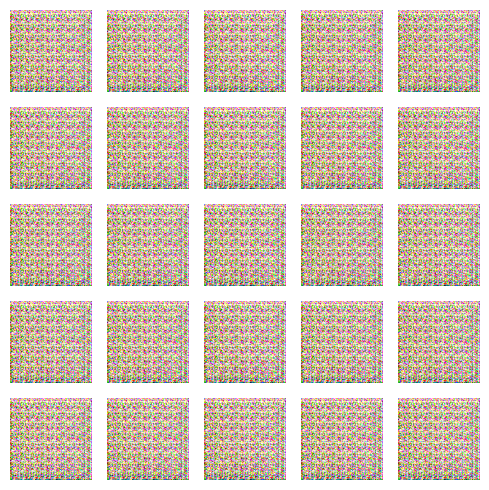

  0%|          | 0/500 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 774ms/step


  0%|          | 1/500 [00:04<38:59,  4.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step


  0%|          | 2/500 [00:07<31:01,  3.74s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step


  1%|          | 3/500 [00:10<27:26,  3.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


  1%|          | 4/500 [00:13<26:57,  3.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 688ms/step


  1%|          | 5/500 [00:18<31:35,  3.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step


  1%|          | 6/500 [00:21<29:40,  3.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step


  1%|▏         | 7/500 [00:24<28:12,  3.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step


  2%|▏         | 8/500 [00:27<27:15,  3.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 637ms/step


  2%|▏         | 9/500 [00:32<29:19,  3.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 693ms/step


  2%|▏         | 10/500 [00:35<29:29,  3.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step


  2%|▏         | 11/500 [00:38<28:04,  3.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


  2%|▏         | 12/500 [00:41<26:37,  3.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step


  3%|▎         | 13/500 [00:45<28:04,  3.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 693ms/step


  3%|▎         | 14/500 [00:49<28:50,  3.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


  3%|▎         | 15/500 [00:52<27:44,  3.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step


  3%|▎         | 16/500 [00:55<27:02,  3.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step


  3%|▎         | 17/500 [00:59<28:16,  3.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 706ms/step


  4%|▎         | 18/500 [01:03<30:09,  3.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step


  4%|▍         | 19/500 [01:06<27:57,  3.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step


  4%|▍         | 20/500 [01:10<28:17,  3.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 654ms/step


  4%|▍         | 21/500 [01:15<30:46,  3.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 727ms/step


  4%|▍         | 22/500 [01:19<32:48,  4.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step


  5%|▍         | 23/500 [01:22<30:19,  3.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step


  5%|▍         | 24/500 [01:25<27:52,  3.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step


  5%|▌         | 25/500 [01:28<26:48,  3.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step


  5%|▌         | 26/500 [01:33<29:01,  3.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 692ms/step


  5%|▌         | 27/500 [01:36<29:01,  3.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step


  6%|▌         | 28/500 [01:39<27:47,  3.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step


  6%|▌         | 29/500 [01:42<26:01,  3.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step


  6%|▌         | 30/500 [01:46<27:48,  3.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 724ms/step


  6%|▌         | 31/500 [01:50<28:10,  3.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step


  6%|▋         | 32/500 [01:53<27:12,  3.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


  7%|▋         | 33/500 [01:56<26:10,  3.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step


  7%|▋         | 34/500 [02:00<26:22,  3.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 744ms/step


  7%|▋         | 35/500 [02:04<27:57,  3.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


  7%|▋         | 36/500 [02:07<25:59,  3.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


  7%|▋         | 37/500 [02:10<25:16,  3.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step


  8%|▊         | 38/500 [02:13<24:46,  3.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step


  8%|▊         | 39/500 [02:17<27:22,  3.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 785ms/step


  8%|▊         | 40/500 [02:21<27:22,  3.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


  8%|▊         | 41/500 [02:24<25:49,  3.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step


  8%|▊         | 42/500 [02:27<24:38,  3.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step


  9%|▊         | 43/500 [02:30<25:14,  3.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 682ms/step


  9%|▉         | 44/500 [02:34<27:25,  3.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step


  9%|▉         | 45/500 [02:38<26:06,  3.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step


  9%|▉         | 46/500 [02:41<25:25,  3.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step


  9%|▉         | 47/500 [02:44<25:36,  3.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 689ms/step


 10%|▉         | 48/500 [02:49<28:19,  3.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


 10%|▉         | 49/500 [02:52<26:29,  3.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


 10%|█         | 50/500 [02:55<25:36,  3.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


 10%|█         | 51/500 [02:58<24:28,  3.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step


 10%|█         | 52/500 [03:02<26:23,  3.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 737ms/step


 11%|█         | 53/500 [03:06<26:24,  3.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step


 11%|█         | 54/500 [03:08<24:52,  3.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step


 11%|█         | 55/500 [03:11<23:51,  3.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step


 11%|█         | 56/500 [03:14<23:25,  3.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 650ms/step


 11%|█▏        | 57/500 [03:19<26:41,  3.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


 12%|█▏        | 58/500 [03:22<24:43,  3.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


 12%|█▏        | 59/500 [03:25<23:54,  3.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step


 12%|█▏        | 60/500 [03:28<23:33,  3.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step


 12%|█▏        | 61/500 [03:32<25:43,  3.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 682ms/step


 12%|█▏        | 62/500 [03:36<25:44,  3.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


 13%|█▎        | 63/500 [03:39<24:25,  3.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step


 13%|█▎        | 64/500 [03:42<23:34,  3.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


 13%|█▎        | 65/500 [03:45<23:30,  3.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 705ms/step


 13%|█▎        | 66/500 [03:50<26:52,  3.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


 13%|█▎        | 67/500 [03:53<24:47,  3.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


 14%|█▎        | 68/500 [03:55<23:29,  3.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step


 14%|█▍        | 69/500 [03:58<22:40,  3.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step


 14%|█▍        | 70/500 [04:02<24:22,  3.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 831ms/step


 14%|█▍        | 71/500 [04:06<25:16,  3.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


 14%|█▍        | 72/500 [04:09<24:01,  3.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


 15%|█▍        | 73/500 [04:12<22:52,  3.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step


 15%|█▍        | 74/500 [04:15<22:53,  3.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 687ms/step


 15%|█▌        | 75/500 [04:20<25:59,  3.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step


 15%|█▌        | 76/500 [04:23<24:21,  3.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


 15%|█▌        | 77/500 [04:26<23:06,  3.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 16%|█▌        | 78/500 [04:29<22:36,  3.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step


 16%|█▌        | 79/500 [04:33<24:29,  3.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 726ms/step


 16%|█▌        | 80/500 [04:36<24:35,  3.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step


 16%|█▌        | 81/500 [04:39<23:16,  3.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step


 16%|█▋        | 82/500 [04:43<22:55,  3.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


 17%|█▋        | 83/500 [04:46<23:27,  3.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 721ms/step


 17%|█▋        | 84/500 [04:50<24:42,  3.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step


 17%|█▋        | 85/500 [04:53<23:18,  3.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step


 17%|█▋        | 86/500 [04:56<22:03,  3.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 17%|█▋        | 87/500 [04:59<21:27,  3.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step


 18%|█▊        | 88/500 [05:03<23:23,  3.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 669ms/step


 18%|█▊        | 89/500 [05:07<23:50,  3.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step


 18%|█▊        | 90/500 [05:09<22:29,  3.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step


 18%|█▊        | 91/500 [05:12<21:33,  3.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step


 18%|█▊        | 92/500 [05:16<22:46,  3.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 708ms/step


 19%|█▊        | 93/500 [05:20<24:13,  3.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


 19%|█▉        | 94/500 [05:23<23:25,  3.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


 19%|█▉        | 95/500 [05:26<21:51,  3.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step


 19%|█▉        | 96/500 [05:29<21:15,  3.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step


 19%|█▉        | 97/500 [05:33<23:16,  3.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 694ms/step


 20%|█▉        | 98/500 [05:37<23:27,  3.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


 20%|█▉        | 99/500 [05:40<21:54,  3.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step


 20%|██        | 100/500 [05:43<21:19,  3.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step


 20%|██        | 101/500 [05:46<21:45,  3.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 748ms/step


 20%|██        | 102/500 [05:50<23:27,  3.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


 21%|██        | 103/500 [05:53<21:54,  3.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


 21%|██        | 104/500 [05:56<21:35,  3.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 21%|██        | 105/500 [05:59<21:02,  3.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step


 21%|██        | 106/500 [06:03<23:13,  3.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 712ms/step


 21%|██▏       | 107/500 [06:07<22:41,  3.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step


 22%|██▏       | 108/500 [06:10<21:49,  3.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


 22%|██▏       | 109/500 [06:13<20:53,  3.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step


 22%|██▏       | 110/500 [06:16<20:36,  3.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 685ms/step


 22%|██▏       | 111/500 [06:21<23:34,  3.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step


 22%|██▏       | 112/500 [06:24<22:21,  3.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


 23%|██▎       | 113/500 [06:26<21:12,  3.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


 23%|██▎       | 114/500 [06:30<21:02,  3.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step


 23%|██▎       | 115/500 [06:34<22:43,  3.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 740ms/step


 23%|██▎       | 116/500 [06:37<22:45,  3.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step


 23%|██▎       | 117/500 [06:41<21:57,  3.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step


 24%|██▎       | 118/500 [06:44<21:10,  3.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step


 24%|██▍       | 119/500 [06:47<21:29,  3.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 664ms/step


 24%|██▍       | 120/500 [06:52<23:21,  3.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step


 24%|██▍       | 121/500 [06:54<21:31,  3.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step


 24%|██▍       | 122/500 [06:57<20:39,  3.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step


 25%|██▍       | 123/500 [07:00<20:22,  3.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step


 25%|██▍       | 124/500 [07:04<21:45,  3.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 665ms/step


 25%|██▌       | 125/500 [07:08<21:56,  3.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


 25%|██▌       | 126/500 [07:11<21:13,  3.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step


 25%|██▌       | 127/500 [07:14<20:25,  3.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


 26%|██▌       | 128/500 [07:18<21:08,  3.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 734ms/step


 26%|██▌       | 129/500 [07:22<22:31,  3.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


 26%|██▌       | 130/500 [07:25<21:09,  3.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


 26%|██▌       | 131/500 [07:28<20:31,  3.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 26%|██▋       | 132/500 [07:32<21:13,  3.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 734ms/step


 27%|██▋       | 133/500 [07:37<23:28,  3.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 741ms/step


 27%|██▋       | 134/500 [07:41<24:41,  4.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step


 27%|██▋       | 135/500 [07:44<23:08,  3.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step


 27%|██▋       | 136/500 [07:48<21:50,  3.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step


 27%|██▋       | 137/500 [07:51<21:36,  3.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 666ms/step


 28%|██▊       | 138/500 [07:56<23:11,  3.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step


 28%|██▊       | 139/500 [07:59<21:40,  3.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step


 28%|██▊       | 140/500 [08:02<20:28,  3.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step


 28%|██▊       | 141/500 [08:04<19:33,  3.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step


 28%|██▊       | 142/500 [08:09<21:14,  3.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 674ms/step


 29%|██▊       | 143/500 [08:12<21:13,  3.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step


 29%|██▉       | 144/500 [08:16<20:35,  3.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step


 29%|██▉       | 145/500 [08:19<19:43,  3.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


 29%|██▉       | 146/500 [08:23<20:45,  3.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 732ms/step


 29%|██▉       | 147/500 [08:27<21:38,  3.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


 30%|██▉       | 148/500 [08:30<20:43,  3.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step


 30%|██▉       | 149/500 [08:33<19:40,  3.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step


 30%|███       | 150/500 [08:36<20:10,  3.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 682ms/step


 30%|███       | 151/500 [08:41<21:22,  3.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step


 30%|███       | 152/500 [08:44<20:17,  3.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step


 31%|███       | 153/500 [08:47<19:18,  3.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step


 31%|███       | 154/500 [08:50<19:48,  3.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 732ms/step


 31%|███       | 155/500 [08:55<21:49,  3.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step


 31%|███       | 156/500 [08:58<20:25,  3.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


 31%|███▏      | 157/500 [09:01<19:26,  3.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


 32%|███▏      | 158/500 [09:04<19:09,  3.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 731ms/step


 32%|███▏      | 159/500 [09:09<21:41,  3.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


 32%|███▏      | 160/500 [09:12<19:55,  3.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step


 32%|███▏      | 161/500 [09:15<19:17,  3.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step


 32%|███▏      | 162/500 [09:18<18:28,  3.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step


 33%|███▎      | 163/500 [09:22<19:58,  3.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 704ms/step


 33%|███▎      | 164/500 [09:26<20:22,  3.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step


 33%|███▎      | 165/500 [09:29<19:21,  3.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step


 33%|███▎      | 166/500 [09:32<18:29,  3.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step


 33%|███▎      | 167/500 [09:36<18:47,  3.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 650ms/step


 34%|███▎      | 168/500 [09:40<20:08,  3.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


 34%|███▍      | 169/500 [09:43<19:03,  3.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step


 34%|███▍      | 170/500 [09:46<18:12,  3.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step


 34%|███▍      | 171/500 [09:49<17:40,  3.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 707ms/step


 34%|███▍      | 172/500 [09:54<20:12,  3.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


 35%|███▍      | 173/500 [09:57<18:39,  3.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step


 35%|███▍      | 174/500 [10:00<17:56,  3.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step


 35%|███▌      | 175/500 [10:03<17:26,  3.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step


 35%|███▌      | 176/500 [10:06<18:11,  3.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 681ms/step


 35%|███▌      | 177/500 [10:10<18:33,  3.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


 36%|███▌      | 178/500 [10:13<18:02,  3.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step


 36%|███▌      | 179/500 [10:16<17:29,  3.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step


 36%|███▌      | 180/500 [10:20<18:17,  3.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 662ms/step


 36%|███▌      | 181/500 [10:24<19:31,  3.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 36%|███▋      | 182/500 [10:27<18:31,  3.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


 37%|███▋      | 183/500 [10:30<17:26,  3.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step


 37%|███▋      | 184/500 [10:33<17:07,  3.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 670ms/step


 37%|███▋      | 185/500 [10:38<19:37,  3.74s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step


 37%|███▋      | 186/500 [10:41<18:02,  3.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


 37%|███▋      | 187/500 [10:44<16:57,  3.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


 38%|███▊      | 188/500 [10:47<16:25,  3.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step


 38%|███▊      | 189/500 [10:51<17:32,  3.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 743ms/step


 38%|███▊      | 190/500 [10:54<18:12,  3.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step


 38%|███▊      | 191/500 [10:57<17:13,  3.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step


 38%|███▊      | 192/500 [11:00<16:20,  3.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step


 39%|███▊      | 193/500 [11:03<16:08,  3.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 705ms/step


 39%|███▉      | 194/500 [11:08<19:03,  3.74s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step


 39%|███▉      | 195/500 [11:11<17:52,  3.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step


 39%|███▉      | 196/500 [11:14<17:17,  3.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step


 39%|███▉      | 197/500 [11:18<16:40,  3.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step


 40%|███▉      | 198/500 [11:22<17:41,  3.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 690ms/step


 40%|███▉      | 199/500 [11:25<17:40,  3.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


 40%|████      | 200/500 [11:28<16:41,  3.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


 40%|████      | 201/500 [11:31<16:19,  3.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step


 40%|████      | 202/500 [11:35<16:46,  3.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step


 41%|████      | 203/500 [11:39<18:08,  3.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step


 41%|████      | 204/500 [11:42<16:54,  3.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


 41%|████      | 205/500 [11:45<15:48,  3.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 41%|████      | 206/500 [11:48<15:18,  3.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step


 41%|████▏     | 207/500 [11:52<16:46,  3.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step


 42%|████▏     | 208/500 [11:55<17:06,  3.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step


 42%|████▏     | 209/500 [11:58<16:07,  3.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 515ms/step


 42%|████▏     | 210/500 [12:01<15:29,  3.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


 42%|████▏     | 211/500 [12:05<15:30,  3.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 730ms/step


 42%|████▏     | 212/500 [12:09<17:36,  3.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 43%|████▎     | 213/500 [12:12<16:50,  3.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step


 43%|████▎     | 214/500 [12:15<15:54,  3.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step


 43%|████▎     | 215/500 [12:18<15:19,  3.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step


 43%|████▎     | 216/500 [12:22<16:23,  3.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 692ms/step


 43%|████▎     | 217/500 [12:26<16:37,  3.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


 44%|████▎     | 218/500 [12:29<15:41,  3.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 518ms/step


 44%|████▍     | 219/500 [12:32<15:18,  3.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


 44%|████▍     | 220/500 [12:36<15:41,  3.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 706ms/step


 44%|████▍     | 221/500 [12:40<17:07,  3.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 44%|████▍     | 222/500 [12:43<16:05,  3.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step


 45%|████▍     | 223/500 [12:46<15:35,  3.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step


 45%|████▍     | 224/500 [12:49<15:24,  3.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 661ms/step


 45%|████▌     | 225/500 [12:54<16:44,  3.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


 45%|████▌     | 226/500 [12:57<15:54,  3.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 45%|████▌     | 227/500 [13:00<14:53,  3.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step


 46%|████▌     | 228/500 [13:03<14:30,  3.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


 46%|████▌     | 229/500 [13:06<14:57,  3.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 749ms/step


 46%|████▌     | 230/500 [13:10<16:01,  3.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step


 46%|████▌     | 231/500 [13:13<15:19,  3.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step


 46%|████▋     | 232/500 [13:17<15:04,  3.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step


 47%|████▋     | 233/500 [13:20<15:31,  3.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 704ms/step


 47%|████▋     | 234/500 [13:25<16:44,  3.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step


 47%|████▋     | 235/500 [13:28<15:35,  3.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step


 47%|████▋     | 236/500 [13:31<14:43,  3.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step


 47%|████▋     | 237/500 [13:34<14:12,  3.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/step


 48%|████▊     | 238/500 [13:38<15:50,  3.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 717ms/step


 48%|████▊     | 239/500 [13:44<18:15,  4.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step


 48%|████▊     | 240/500 [13:47<16:51,  3.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step


 48%|████▊     | 241/500 [13:50<15:32,  3.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step


 48%|████▊     | 242/500 [13:53<14:56,  3.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step


 49%|████▊     | 243/500 [13:58<16:04,  3.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 712ms/step


 49%|████▉     | 244/500 [14:01<15:23,  3.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


 49%|████▉     | 245/500 [14:04<14:14,  3.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


 49%|████▉     | 246/500 [14:07<13:48,  3.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step


 49%|████▉     | 247/500 [14:10<13:48,  3.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 697ms/step


 50%|████▉     | 248/500 [14:15<15:39,  3.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step


 50%|████▉     | 249/500 [14:18<14:39,  3.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step


 50%|█████     | 250/500 [14:21<14:05,  3.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


 50%|█████     | 251/500 [14:24<13:14,  3.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step


 50%|█████     | 252/500 [14:27<14:03,  3.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 741ms/step


 51%|█████     | 253/500 [14:31<14:34,  3.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step


 51%|█████     | 254/500 [14:34<13:54,  3.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


 51%|█████     | 255/500 [14:37<13:17,  3.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


 51%|█████     | 256/500 [14:41<13:27,  3.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 694ms/step


 51%|█████▏    | 257/500 [14:45<14:33,  3.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step


 52%|█████▏    | 258/500 [14:48<13:54,  3.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


 52%|█████▏    | 259/500 [14:51<13:15,  3.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 52%|█████▏    | 260/500 [14:54<12:55,  3.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step


 52%|█████▏    | 261/500 [14:59<14:24,  3.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 775ms/step


 52%|█████▏    | 262/500 [15:02<14:27,  3.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step


 53%|█████▎    | 263/500 [15:05<13:28,  3.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step


 53%|█████▎    | 264/500 [15:08<12:52,  3.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step


 53%|█████▎    | 265/500 [15:11<12:35,  3.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 715ms/step


 53%|█████▎    | 266/500 [15:16<14:27,  3.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step


 53%|█████▎    | 267/500 [15:19<13:32,  3.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step


 54%|█████▎    | 268/500 [15:22<12:58,  3.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 54%|█████▍    | 269/500 [15:25<12:34,  3.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step


 54%|█████▍    | 270/500 [15:29<13:43,  3.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 685ms/step


 54%|█████▍    | 271/500 [15:33<13:12,  3.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


 54%|█████▍    | 272/500 [15:36<12:30,  3.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


 55%|█████▍    | 273/500 [15:38<12:00,  3.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step


 55%|█████▍    | 274/500 [15:42<11:53,  3.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 739ms/step


 55%|█████▌    | 275/500 [15:46<13:36,  3.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


 55%|█████▌    | 276/500 [15:49<12:44,  3.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


 55%|█████▌    | 277/500 [15:52<11:59,  3.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step


 56%|█████▌    | 278/500 [15:55<11:41,  3.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step


 56%|█████▌    | 279/500 [15:59<12:42,  3.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 690ms/step


 56%|█████▌    | 280/500 [16:03<12:55,  3.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step


 56%|█████▌    | 281/500 [16:06<12:24,  3.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step


 56%|█████▋    | 282/500 [16:09<11:40,  3.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step


 57%|█████▋    | 283/500 [16:12<12:11,  3.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 718ms/step


 57%|█████▋    | 284/500 [16:17<13:17,  3.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step


 57%|█████▋    | 285/500 [16:20<12:28,  3.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


 57%|█████▋    | 286/500 [16:23<11:40,  3.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


 57%|█████▋    | 287/500 [16:26<11:08,  3.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 654ms/step


 58%|█████▊    | 288/500 [16:30<12:53,  3.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


 58%|█████▊    | 289/500 [16:33<12:14,  3.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 58%|█████▊    | 290/500 [16:36<11:26,  3.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 58%|█████▊    | 291/500 [16:39<10:59,  3.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step


 58%|█████▊    | 292/500 [16:43<11:45,  3.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 676ms/step


 59%|█████▊    | 293/500 [16:47<12:16,  3.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step


 59%|█████▉    | 294/500 [16:50<11:25,  3.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


 59%|█████▉    | 295/500 [16:53<10:48,  3.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


 59%|█████▉    | 296/500 [16:56<10:59,  3.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 719ms/step


 59%|█████▉    | 297/500 [17:01<12:17,  3.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step


 60%|█████▉    | 298/500 [17:04<11:39,  3.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


 60%|█████▉    | 299/500 [17:06<11:02,  3.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step


 60%|██████    | 300/500 [17:09<10:37,  3.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step


 60%|██████    | 301/500 [17:14<11:49,  3.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 735ms/step


 60%|██████    | 302/500 [17:17<11:47,  3.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


 61%|██████    | 303/500 [17:20<11:10,  3.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step


 61%|██████    | 304/500 [17:23<10:36,  3.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step


 61%|██████    | 305/500 [17:27<10:53,  3.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 721ms/step


 61%|██████    | 306/500 [17:31<11:48,  3.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step


 61%|██████▏   | 307/500 [17:34<11:08,  3.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step


 62%|██████▏   | 308/500 [17:37<10:21,  3.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step


 62%|██████▏   | 309/500 [17:40<10:01,  3.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 697ms/step


 62%|██████▏   | 310/500 [17:45<11:41,  3.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step


 62%|██████▏   | 311/500 [17:48<10:47,  3.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step


 62%|██████▏   | 312/500 [17:51<10:18,  3.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step


 63%|██████▎   | 313/500 [17:54<09:59,  3.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


 63%|██████▎   | 314/500 [17:58<10:35,  3.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 669ms/step


 63%|██████▎   | 315/500 [18:01<10:49,  3.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step


 63%|██████▎   | 316/500 [18:04<10:10,  3.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


 63%|██████▎   | 317/500 [18:07<09:39,  3.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


 64%|██████▎   | 318/500 [18:11<10:04,  3.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 730ms/step


 64%|██████▍   | 319/500 [18:15<11:12,  3.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


 64%|██████▍   | 320/500 [18:18<10:35,  3.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step


 64%|██████▍   | 321/500 [18:21<09:53,  3.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step


 64%|██████▍   | 322/500 [18:24<09:29,  3.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step


 65%|██████▍   | 323/500 [18:29<10:27,  3.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 770ms/step


 65%|██████▍   | 324/500 [18:32<10:26,  3.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


 65%|██████▌   | 325/500 [18:35<09:52,  3.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step


 65%|██████▌   | 326/500 [18:38<09:23,  3.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


 65%|██████▌   | 327/500 [18:42<09:34,  3.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 760ms/step


 66%|██████▌   | 328/500 [18:46<10:34,  3.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step


 66%|██████▌   | 329/500 [18:49<09:55,  3.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step


 66%|██████▌   | 330/500 [18:52<09:32,  3.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step


 66%|██████▌   | 331/500 [18:55<09:13,  3.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 648ms/step


 66%|██████▋   | 332/500 [19:00<10:08,  3.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 67%|██████▋   | 333/500 [19:03<09:45,  3.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step


 67%|██████▋   | 334/500 [19:06<09:19,  3.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step


 67%|██████▋   | 335/500 [19:09<08:50,  3.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step


 67%|██████▋   | 336/500 [19:13<09:17,  3.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 732ms/step


 67%|██████▋   | 337/500 [19:17<09:50,  3.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step


 68%|██████▊   | 338/500 [19:20<09:16,  3.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step


 68%|██████▊   | 339/500 [19:23<08:44,  3.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step


 68%|██████▊   | 340/500 [19:26<08:40,  3.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 722ms/step


 68%|██████▊   | 341/500 [19:31<09:58,  3.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step


 68%|██████▊   | 342/500 [19:34<09:10,  3.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


 69%|██████▊   | 343/500 [19:37<09:02,  3.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 705ms/step


 69%|██████▉   | 344/500 [19:42<10:22,  3.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 727ms/step


 69%|██████▉   | 345/500 [19:47<10:49,  4.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step


 69%|██████▉   | 346/500 [19:50<09:47,  3.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step


 69%|██████▉   | 347/500 [19:53<09:12,  3.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step


 70%|██████▉   | 348/500 [19:56<08:52,  3.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 781ms/step


 70%|██████▉   | 349/500 [20:01<10:02,  3.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step


 70%|███████   | 350/500 [20:04<09:15,  3.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step


 70%|███████   | 351/500 [20:07<08:35,  3.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step


 70%|███████   | 352/500 [20:10<08:10,  3.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step


 71%|███████   | 353/500 [20:14<08:30,  3.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 704ms/step


 71%|███████   | 354/500 [20:18<08:41,  3.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step


 71%|███████   | 355/500 [20:21<08:16,  3.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


 71%|███████   | 356/500 [20:24<07:45,  3.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step


 71%|███████▏  | 357/500 [20:27<07:51,  3.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 680ms/step


 72%|███████▏  | 358/500 [20:32<08:39,  3.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step


 72%|███████▏  | 359/500 [20:35<08:07,  3.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step


 72%|███████▏  | 360/500 [20:38<07:38,  3.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step


 72%|███████▏  | 361/500 [20:40<07:18,  3.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step


 72%|███████▏  | 362/500 [20:44<07:47,  3.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 658ms/step


 73%|███████▎  | 363/500 [20:48<07:56,  3.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


 73%|███████▎  | 364/500 [20:51<07:27,  3.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


 73%|███████▎  | 365/500 [20:54<07:12,  3.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


 73%|███████▎  | 366/500 [20:57<06:51,  3.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 689ms/step


 73%|███████▎  | 367/500 [21:02<08:01,  3.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step


 74%|███████▎  | 368/500 [21:05<07:42,  3.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 74%|███████▍  | 369/500 [21:08<07:12,  3.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step


 74%|███████▍  | 370/500 [21:11<07:01,  3.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step


 74%|███████▍  | 371/500 [21:15<07:47,  3.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 759ms/step


 74%|███████▍  | 372/500 [21:19<07:42,  3.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


 75%|███████▍  | 373/500 [21:22<07:12,  3.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step


 75%|███████▍  | 374/500 [21:25<06:53,  3.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


 75%|███████▌  | 375/500 [21:28<06:58,  3.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 719ms/step


 75%|███████▌  | 376/500 [21:33<07:31,  3.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step


 75%|███████▌  | 377/500 [21:36<07:06,  3.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step


 76%|███████▌  | 378/500 [21:39<06:43,  3.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step


 76%|███████▌  | 379/500 [21:41<06:20,  3.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 651ms/step


 76%|███████▌  | 380/500 [21:46<06:53,  3.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 766ms/step


 76%|███████▌  | 381/500 [21:49<06:45,  3.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step


 76%|███████▋  | 382/500 [21:52<06:20,  3.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


 77%|███████▋  | 383/500 [21:54<06:01,  3.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


 77%|███████▋  | 384/500 [21:57<05:51,  3.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 723ms/step


 77%|███████▋  | 385/500 [22:02<06:32,  3.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 677ms/step


 77%|███████▋  | 386/500 [22:05<06:34,  3.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step


 77%|███████▋  | 387/500 [22:08<06:13,  3.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


 78%|███████▊  | 388/500 [22:11<05:58,  3.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


 78%|███████▊  | 389/500 [22:14<06:00,  3.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 776ms/step


 78%|███████▊  | 390/500 [22:19<06:35,  3.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step


 78%|███████▊  | 391/500 [22:22<06:10,  3.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step


 78%|███████▊  | 392/500 [22:25<05:49,  3.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step


 79%|███████▊  | 393/500 [22:28<05:38,  3.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step


 79%|███████▉  | 394/500 [22:32<06:08,  3.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 765ms/step


 79%|███████▉  | 395/500 [22:36<06:15,  3.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


 79%|███████▉  | 396/500 [22:39<05:51,  3.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step


 79%|███████▉  | 397/500 [22:41<05:30,  3.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step


 80%|███████▉  | 398/500 [22:45<05:34,  3.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 699ms/step


 80%|███████▉  | 399/500 [22:49<06:07,  3.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


 80%|████████  | 400/500 [22:52<05:42,  3.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 80%|████████  | 401/500 [22:55<05:23,  3.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step


 80%|████████  | 402/500 [22:58<05:11,  3.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 664ms/step


 81%|████████  | 403/500 [23:03<05:54,  3.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


 81%|████████  | 404/500 [23:06<05:28,  3.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


 81%|████████  | 405/500 [23:09<05:10,  3.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step


 81%|████████  | 406/500 [23:11<04:53,  3.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step


 81%|████████▏ | 407/500 [23:15<05:16,  3.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 714ms/step


 82%|████████▏ | 408/500 [23:19<05:25,  3.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step


 82%|████████▏ | 409/500 [23:22<05:06,  3.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step


 82%|████████▏ | 410/500 [23:25<04:57,  3.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step


 82%|████████▏ | 411/500 [23:29<05:05,  3.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 707ms/step


 82%|████████▏ | 412/500 [23:34<05:38,  3.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step


 83%|████████▎ | 413/500 [23:37<05:14,  3.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step


 83%|████████▎ | 414/500 [23:40<04:55,  3.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step


 83%|████████▎ | 415/500 [23:43<04:41,  3.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step


 83%|████████▎ | 416/500 [23:47<05:00,  3.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 733ms/step


 83%|████████▎ | 417/500 [23:51<05:07,  3.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step


 84%|████████▎ | 418/500 [23:55<04:54,  3.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step


 84%|████████▍ | 419/500 [23:58<04:42,  3.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step


 84%|████████▍ | 420/500 [24:02<04:55,  3.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 722ms/step


 84%|████████▍ | 421/500 [24:06<05:02,  3.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step


 84%|████████▍ | 422/500 [24:09<04:40,  3.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step


 85%|████████▍ | 423/500 [24:12<04:25,  3.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step


 85%|████████▍ | 424/500 [24:16<04:14,  3.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 711ms/step


 85%|████████▌ | 425/500 [24:20<04:46,  3.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step


 85%|████████▌ | 426/500 [24:23<04:23,  3.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step


 85%|████████▌ | 427/500 [24:27<04:10,  3.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step


 86%|████████▌ | 428/500 [24:30<03:57,  3.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step


 86%|████████▌ | 429/500 [24:33<04:06,  3.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/step


 86%|████████▌ | 430/500 [24:37<04:08,  3.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step


 86%|████████▌ | 431/500 [24:40<03:56,  3.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 86%|████████▋ | 432/500 [24:43<03:44,  3.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step


 87%|████████▋ | 433/500 [24:47<03:47,  3.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 710ms/step


 87%|████████▋ | 434/500 [24:51<04:07,  3.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step


 87%|████████▋ | 435/500 [24:54<03:47,  3.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step


 87%|████████▋ | 436/500 [24:58<03:38,  3.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 87%|████████▋ | 437/500 [25:01<03:33,  3.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 661ms/step


 88%|████████▊ | 438/500 [25:06<03:54,  3.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step


 88%|████████▊ | 439/500 [25:09<03:37,  3.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step


 88%|████████▊ | 440/500 [25:12<03:20,  3.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step


 88%|████████▊ | 441/500 [25:15<03:10,  3.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step


 88%|████████▊ | 442/500 [25:19<03:27,  3.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 693ms/step


 89%|████████▊ | 443/500 [25:23<03:27,  3.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step


 89%|████████▉ | 444/500 [25:26<03:15,  3.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 89%|████████▉ | 445/500 [25:29<03:06,  3.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step


 89%|████████▉ | 446/500 [25:33<03:18,  3.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 714ms/step


 89%|████████▉ | 447/500 [25:38<03:31,  3.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 704ms/step


 90%|████████▉ | 448/500 [25:42<03:23,  3.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step


 90%|████████▉ | 449/500 [25:45<03:08,  3.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 697ms/step


 90%|█████████ | 450/500 [25:49<03:12,  3.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 697ms/step


 90%|█████████ | 451/500 [25:53<03:06,  3.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step


 90%|█████████ | 452/500 [25:56<02:48,  3.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


 91%|█████████ | 453/500 [25:59<02:37,  3.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step


 91%|█████████ | 454/500 [26:02<02:38,  3.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 639ms/step


 91%|█████████ | 455/500 [26:07<02:47,  3.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step


 91%|█████████ | 456/500 [26:10<02:36,  3.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step


 91%|█████████▏| 457/500 [26:13<02:28,  3.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step


 92%|█████████▏| 458/500 [26:17<02:26,  3.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 679ms/step


 92%|█████████▏| 459/500 [26:21<02:34,  3.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step


 92%|█████████▏| 460/500 [26:24<02:24,  3.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


 92%|█████████▏| 461/500 [26:27<02:15,  3.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step


 92%|█████████▏| 462/500 [26:30<02:06,  3.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


 93%|█████████▎| 463/500 [26:35<02:12,  3.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 704ms/step


 93%|█████████▎| 464/500 [26:38<02:09,  3.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step


 93%|█████████▎| 465/500 [26:41<01:59,  3.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step


 93%|█████████▎| 466/500 [26:44<01:50,  3.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step


 93%|█████████▎| 467/500 [26:48<01:50,  3.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 792ms/step


 94%|█████████▎| 468/500 [26:52<01:55,  3.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step


 94%|█████████▍| 469/500 [26:55<01:46,  3.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step


 94%|█████████▍| 470/500 [26:58<01:39,  3.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


 94%|█████████▍| 471/500 [27:01<01:33,  3.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 741ms/step


 94%|█████████▍| 472/500 [27:05<01:39,  3.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 704ms/step


 95%|█████████▍| 473/500 [27:09<01:37,  3.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step


 95%|█████████▍| 474/500 [27:12<01:28,  3.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step


 95%|█████████▌| 475/500 [27:15<01:24,  3.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step


 95%|█████████▌| 476/500 [27:19<01:24,  3.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 671ms/step


 95%|█████████▌| 477/500 [27:23<01:22,  3.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


 96%|█████████▌| 478/500 [27:26<01:14,  3.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step


 96%|█████████▌| 479/500 [27:28<01:06,  3.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


 96%|█████████▌| 480/500 [27:31<01:01,  3.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step


 96%|█████████▌| 481/500 [27:35<01:03,  3.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 632ms/step


 96%|█████████▋| 482/500 [27:39<01:01,  3.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step


 97%|█████████▋| 483/500 [27:42<00:57,  3.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step


 97%|█████████▋| 484/500 [27:45<00:52,  3.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step


 97%|█████████▋| 485/500 [27:49<00:49,  3.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 685ms/step


 97%|█████████▋| 486/500 [27:53<00:50,  3.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


 97%|█████████▋| 487/500 [27:56<00:45,  3.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


 98%|█████████▊| 488/500 [27:59<00:39,  3.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


 98%|█████████▊| 489/500 [28:02<00:36,  3.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 717ms/step


 98%|█████████▊| 490/500 [28:07<00:35,  3.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 673ms/step


 98%|█████████▊| 491/500 [28:10<00:32,  3.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step


 98%|█████████▊| 492/500 [28:13<00:27,  3.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step


 99%|█████████▊| 493/500 [28:17<00:23,  3.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step


 99%|█████████▉| 494/500 [28:20<00:21,  3.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 700ms/step


 99%|█████████▉| 495/500 [28:24<00:17,  3.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


 99%|█████████▉| 496/500 [28:27<00:13,  3.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step


 99%|█████████▉| 497/500 [28:30<00:09,  3.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step


100%|█████████▉| 498/500 [28:33<00:06,  3.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 674ms/step


100%|█████████▉| 499/500 [28:38<00:03,  3.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step


100%|██████████| 500/500 [28:41<00:00,  3.44s/it]


Epoch: 9 	 Discriminator Loss: 0.6669858694076538 		 Generator Loss: [array(0.66698587), array(0.66698587), array(0.66698587)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


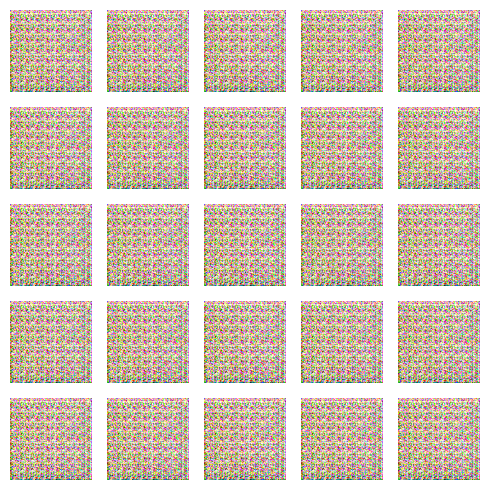

  0%|          | 0/500 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 746ms/step


  0%|          | 1/500 [00:04<35:45,  4.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 674ms/step


  0%|          | 2/500 [00:08<34:17,  4.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step


  1%|          | 3/500 [00:11<29:28,  3.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


  1%|          | 4/500 [00:14<27:49,  3.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


  1%|          | 5/500 [00:17<27:17,  3.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step


  1%|          | 6/500 [00:21<30:08,  3.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 713ms/step


  1%|▏         | 7/500 [00:25<29:50,  3.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step


  2%|▏         | 8/500 [00:28<27:34,  3.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step


  2%|▏         | 9/500 [00:31<26:59,  3.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step


  2%|▏         | 10/500 [00:34<27:15,  3.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 730ms/step


  2%|▏         | 11/500 [00:39<30:04,  3.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step


  2%|▏         | 12/500 [00:42<28:08,  3.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step


  3%|▎         | 13/500 [00:45<26:49,  3.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


  3%|▎         | 14/500 [00:48<25:49,  3.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step


  3%|▎         | 15/500 [00:52<28:04,  3.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 774ms/step


  3%|▎         | 16/500 [00:55<28:21,  3.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step


  3%|▎         | 17/500 [00:59<27:34,  3.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step


  4%|▎         | 18/500 [01:02<26:31,  3.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step


  4%|▍         | 19/500 [01:05<27:02,  3.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 751ms/step


  4%|▍         | 20/500 [01:09<29:04,  3.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step


  4%|▍         | 21/500 [01:12<27:09,  3.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step


  4%|▍         | 22/500 [01:15<25:36,  3.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


  5%|▍         | 23/500 [01:18<25:25,  3.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 744ms/step


  5%|▍         | 24/500 [01:23<29:23,  3.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step


  5%|▌         | 25/500 [01:26<27:31,  3.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step


  5%|▌         | 26/500 [01:29<26:05,  3.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


  5%|▌         | 27/500 [01:32<25:27,  3.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


  6%|▌         | 28/500 [01:35<26:15,  3.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 700ms/step


  6%|▌         | 29/500 [01:39<27:48,  3.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step


  6%|▌         | 30/500 [01:42<26:14,  3.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step


  6%|▌         | 31/500 [01:45<25:30,  3.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step


  6%|▋         | 32/500 [01:49<25:38,  3.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 694ms/step


  7%|▋         | 33/500 [01:53<28:30,  3.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step


  7%|▋         | 34/500 [01:56<26:44,  3.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step


  7%|▋         | 35/500 [01:59<25:27,  3.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step


  7%|▋         | 36/500 [02:02<24:48,  3.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


  7%|▋         | 37/500 [02:06<27:06,  3.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 696ms/step


  8%|▊         | 38/500 [02:10<27:33,  3.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step


  8%|▊         | 39/500 [02:13<25:51,  3.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


  8%|▊         | 40/500 [02:16<25:00,  3.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step


  8%|▊         | 41/500 [02:20<25:39,  3.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 692ms/step


  8%|▊         | 42/500 [02:24<27:29,  3.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step


  9%|▊         | 43/500 [02:27<25:47,  3.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step


  9%|▉         | 44/500 [02:30<24:59,  3.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


  9%|▉         | 45/500 [02:33<24:57,  3.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 687ms/step


  9%|▉         | 46/500 [02:38<28:18,  3.74s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


  9%|▉         | 47/500 [02:41<26:30,  3.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


 10%|▉         | 48/500 [02:44<24:50,  3.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step


 10%|▉         | 49/500 [02:47<24:07,  3.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 714ms/step


 10%|█         | 50/500 [02:51<27:12,  3.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 818ms/step


 10%|█         | 51/500 [02:56<30:43,  4.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step


 10%|█         | 52/500 [02:59<28:09,  3.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


 11%|█         | 53/500 [03:03<26:47,  3.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


 11%|█         | 54/500 [03:05<25:07,  3.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step


 11%|█         | 55/500 [03:10<26:31,  3.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 674ms/step


 11%|█         | 56/500 [03:13<26:23,  3.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step


 11%|█▏        | 57/500 [03:16<24:43,  3.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


 12%|█▏        | 58/500 [03:19<23:27,  3.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step


 12%|█▏        | 59/500 [03:22<23:19,  3.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 666ms/step


 12%|█▏        | 60/500 [03:26<26:05,  3.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step


 12%|█▏        | 61/500 [03:29<24:54,  3.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step


 12%|█▏        | 62/500 [03:33<24:21,  3.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step


 13%|█▎        | 63/500 [03:35<23:22,  3.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step


 13%|█▎        | 64/500 [03:40<25:28,  3.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 727ms/step


 13%|█▎        | 65/500 [03:43<25:55,  3.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step


 13%|█▎        | 66/500 [03:46<24:38,  3.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step


 13%|█▎        | 67/500 [03:49<23:52,  3.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 506ms/step


 14%|█▎        | 68/500 [03:53<24:48,  3.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 695ms/step


 14%|█▍        | 69/500 [03:57<25:50,  3.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


 14%|█▍        | 70/500 [04:00<24:06,  3.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step


 14%|█▍        | 71/500 [04:03<22:56,  3.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


 14%|█▍        | 72/500 [04:06<23:01,  3.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 679ms/step


 15%|█▍        | 73/500 [04:11<25:53,  3.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


 15%|█▍        | 74/500 [04:14<24:33,  3.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step


 15%|█▌        | 75/500 [04:17<23:16,  3.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 15%|█▌        | 76/500 [04:19<22:10,  3.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 508ms/step


 15%|█▌        | 77/500 [04:24<24:32,  3.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 669ms/step


 16%|█▌        | 78/500 [04:27<24:20,  3.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


 16%|█▌        | 79/500 [04:30<22:49,  3.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step


 16%|█▌        | 80/500 [04:33<22:28,  3.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step


 16%|█▌        | 81/500 [04:36<22:44,  3.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 648ms/step


 16%|█▋        | 82/500 [04:41<24:44,  3.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step


 17%|█▋        | 83/500 [04:44<23:26,  3.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step


 17%|█▋        | 84/500 [04:47<22:46,  3.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step


 17%|█▋        | 85/500 [04:49<21:42,  3.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


 17%|█▋        | 86/500 [04:53<22:46,  3.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 699ms/step


 17%|█▋        | 87/500 [04:57<23:34,  3.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step


 18%|█▊        | 88/500 [05:00<22:07,  3.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step


 18%|█▊        | 89/500 [05:02<21:20,  3.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step


 18%|█▊        | 90/500 [05:06<21:21,  3.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 720ms/step


 18%|█▊        | 91/500 [05:10<23:51,  3.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step


 18%|█▊        | 92/500 [05:13<23:06,  3.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step


 19%|█▊        | 93/500 [05:16<22:16,  3.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step


 19%|█▉        | 94/500 [05:19<21:17,  3.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


 19%|█▉        | 95/500 [05:23<22:34,  3.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 667ms/step


 19%|█▉        | 96/500 [05:27<23:16,  3.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


 19%|█▉        | 97/500 [05:29<21:57,  3.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step


 20%|█▉        | 98/500 [05:32<21:14,  3.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


 20%|█▉        | 99/500 [05:35<21:12,  3.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 662ms/step


 20%|██        | 100/500 [05:40<24:08,  3.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


 20%|██        | 101/500 [05:43<22:53,  3.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


 20%|██        | 102/500 [05:46<21:54,  3.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 21%|██        | 103/500 [05:49<21:03,  3.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step


 21%|██        | 104/500 [05:53<23:06,  3.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 729ms/step


 21%|██        | 105/500 [05:57<23:53,  3.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step


 21%|██        | 106/500 [06:00<22:20,  3.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step


 21%|██▏       | 107/500 [06:03<21:16,  3.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step


 22%|██▏       | 108/500 [06:07<21:48,  3.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 719ms/step


 22%|██▏       | 109/500 [06:11<23:18,  3.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step


 22%|██▏       | 110/500 [06:14<22:05,  3.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


 22%|██▏       | 111/500 [06:17<21:05,  3.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


 22%|██▏       | 112/500 [06:19<20:24,  3.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 717ms/step


 23%|██▎       | 113/500 [06:24<22:44,  3.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 761ms/step


 23%|██▎       | 114/500 [06:28<23:06,  3.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step


 23%|██▎       | 115/500 [06:30<21:33,  3.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


 23%|██▎       | 116/500 [06:33<20:33,  3.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


 23%|██▎       | 117/500 [06:37<21:02,  3.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 687ms/step


 24%|██▎       | 118/500 [06:41<22:58,  3.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 24%|██▍       | 119/500 [06:44<21:52,  3.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 24%|██▍       | 120/500 [06:47<20:44,  3.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


 24%|██▍       | 121/500 [06:50<20:12,  3.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 730ms/step


 24%|██▍       | 122/500 [06:55<23:25,  3.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 25%|██▍       | 123/500 [06:58<22:13,  3.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


 25%|██▍       | 124/500 [07:01<20:50,  3.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


 25%|██▌       | 125/500 [07:04<19:59,  3.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


 25%|██▌       | 126/500 [07:08<21:56,  3.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 648ms/step


 25%|██▌       | 127/500 [07:12<22:09,  3.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step


 26%|██▌       | 128/500 [07:15<21:03,  3.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step


 26%|██▌       | 129/500 [07:18<20:25,  3.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 26%|██▌       | 130/500 [07:22<20:54,  3.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/step


 26%|██▌       | 131/500 [07:26<23:09,  3.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


 26%|██▋       | 132/500 [07:29<21:30,  3.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step


 27%|██▋       | 133/500 [07:32<20:21,  3.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step


 27%|██▋       | 134/500 [07:35<19:20,  3.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step


 27%|██▋       | 135/500 [07:38<20:16,  3.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 726ms/step


 27%|██▋       | 136/500 [07:42<21:11,  3.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step


 27%|██▋       | 137/500 [07:45<20:09,  3.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


 28%|██▊       | 138/500 [07:48<19:50,  3.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step


 28%|██▊       | 139/500 [07:52<19:43,  3.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 642ms/step


 28%|██▊       | 140/500 [07:56<21:39,  3.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step


 28%|██▊       | 141/500 [07:59<20:39,  3.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step


 28%|██▊       | 142/500 [08:02<19:38,  3.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


 29%|██▊       | 143/500 [08:05<18:51,  3.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step


 29%|██▉       | 144/500 [08:09<20:18,  3.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 643ms/step


 29%|██▉       | 145/500 [08:13<21:08,  3.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step


 29%|██▉       | 146/500 [08:16<20:07,  3.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


 29%|██▉       | 147/500 [08:19<19:16,  3.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step


 30%|██▉       | 148/500 [08:22<18:47,  3.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 678ms/step


 30%|██▉       | 149/500 [08:27<21:24,  3.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step


 30%|███       | 150/500 [08:30<20:15,  3.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


 30%|███       | 151/500 [08:33<19:31,  3.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step


 30%|███       | 152/500 [08:36<18:57,  3.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step


 31%|███       | 153/500 [08:40<21:14,  3.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 731ms/step


 31%|███       | 154/500 [08:46<23:37,  4.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step


 31%|███       | 155/500 [08:48<21:31,  3.74s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step


 31%|███       | 156/500 [08:52<20:12,  3.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step


 31%|███▏      | 157/500 [08:55<19:15,  3.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step


 32%|███▏      | 158/500 [08:58<19:06,  3.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 708ms/step


 32%|███▏      | 159/500 [09:02<20:35,  3.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step


 32%|███▏      | 160/500 [09:05<19:08,  3.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


 32%|███▏      | 161/500 [09:08<18:04,  3.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step


 32%|███▏      | 162/500 [09:11<17:29,  3.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 33%|███▎      | 163/500 [09:15<19:36,  3.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 668ms/step


 33%|███▎      | 164/500 [09:18<19:16,  3.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step


 33%|███▎      | 165/500 [09:21<18:23,  3.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step


 33%|███▎      | 166/500 [09:24<17:53,  3.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step


 33%|███▎      | 167/500 [09:28<17:56,  3.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 665ms/step


 34%|███▎      | 168/500 [09:32<20:04,  3.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step


 34%|███▍      | 169/500 [09:35<18:40,  3.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step


 34%|███▍      | 170/500 [09:38<17:51,  3.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step


 34%|███▍      | 171/500 [09:41<17:14,  3.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


 34%|███▍      | 172/500 [09:45<18:31,  3.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 660ms/step


 35%|███▍      | 173/500 [09:48<18:49,  3.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step


 35%|███▍      | 174/500 [09:51<17:53,  3.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step


 35%|███▌      | 175/500 [09:54<17:05,  3.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 35%|███▌      | 176/500 [09:57<17:19,  3.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 672ms/step


 35%|███▌      | 177/500 [10:02<19:23,  3.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step


 36%|███▌      | 178/500 [10:05<18:10,  3.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


 36%|███▌      | 179/500 [10:08<17:07,  3.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step


 36%|███▌      | 180/500 [10:11<16:46,  3.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step


 36%|███▌      | 181/500 [10:15<18:25,  3.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 660ms/step


 36%|███▋      | 182/500 [10:18<18:28,  3.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step


 37%|███▋      | 183/500 [10:21<17:33,  3.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step


 37%|███▋      | 184/500 [10:24<17:04,  3.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step


 37%|███▋      | 185/500 [10:27<16:38,  3.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 669ms/step


 37%|███▋      | 186/500 [10:32<18:48,  3.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step


 37%|███▋      | 187/500 [10:35<17:59,  3.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 38%|███▊      | 188/500 [10:38<17:02,  3.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 38%|███▊      | 189/500 [10:41<16:32,  3.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step


 38%|███▊      | 190/500 [10:45<18:08,  3.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 734ms/step


 38%|███▊      | 191/500 [10:49<18:11,  3.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step


 38%|███▊      | 192/500 [10:51<16:58,  3.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step


 39%|███▊      | 193/500 [10:54<16:13,  3.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


 39%|███▉      | 194/500 [10:58<16:27,  3.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 753ms/step


 39%|███▉      | 195/500 [11:02<18:05,  3.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 39%|███▉      | 196/500 [11:05<17:19,  3.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


 39%|███▉      | 197/500 [11:08<16:28,  3.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step


 40%|███▉      | 198/500 [11:11<15:40,  3.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


 40%|███▉      | 199/500 [11:15<16:46,  3.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 677ms/step


 40%|████      | 200/500 [11:18<17:17,  3.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


 40%|████      | 201/500 [11:21<16:16,  3.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step


 40%|████      | 202/500 [11:24<15:42,  3.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step


 41%|████      | 203/500 [11:27<15:13,  3.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step


 41%|████      | 204/500 [11:31<16:37,  3.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 803ms/step


 41%|████      | 205/500 [11:35<17:14,  3.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step


 41%|████      | 206/500 [11:38<16:19,  3.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step


 41%|████▏     | 207/500 [11:41<15:23,  3.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


 42%|████▏     | 208/500 [11:44<15:41,  3.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 657ms/step


 42%|████▏     | 209/500 [11:48<17:06,  3.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step


 42%|████▏     | 210/500 [11:51<16:14,  3.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step


 42%|████▏     | 211/500 [11:54<15:36,  3.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


 42%|████▏     | 212/500 [11:57<15:04,  3.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


 43%|████▎     | 213/500 [12:00<15:19,  3.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 703ms/step


 43%|████▎     | 214/500 [12:05<16:41,  3.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step


 43%|████▎     | 215/500 [12:08<15:53,  3.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step


 43%|████▎     | 216/500 [12:10<15:06,  3.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step


 43%|████▎     | 217/500 [12:13<14:37,  3.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step


 44%|████▎     | 218/500 [12:17<15:48,  3.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 672ms/step


 44%|████▍     | 219/500 [12:21<16:25,  3.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step


 44%|████▍     | 220/500 [12:24<15:48,  3.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step


 44%|████▍     | 221/500 [12:27<15:08,  3.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step


 44%|████▍     | 222/500 [12:30<15:13,  3.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 631ms/step


 45%|████▍     | 223/500 [12:35<16:28,  3.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 681ms/step


 45%|████▍     | 224/500 [12:38<15:42,  3.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


 45%|████▌     | 225/500 [12:41<14:46,  3.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


 45%|████▌     | 226/500 [12:43<14:16,  3.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 45%|████▌     | 227/500 [12:47<14:29,  3.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 650ms/step


 46%|████▌     | 228/500 [12:51<15:53,  3.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step


 46%|████▌     | 229/500 [12:54<15:23,  3.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step


 46%|████▌     | 230/500 [12:57<14:38,  3.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step


 46%|████▌     | 231/500 [13:00<14:19,  3.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step


 46%|████▋     | 232/500 [13:04<15:34,  3.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 636ms/step


 47%|████▋     | 233/500 [13:08<15:36,  3.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


 47%|████▋     | 234/500 [13:11<14:49,  3.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


 47%|████▋     | 235/500 [13:14<14:27,  3.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step


 47%|████▋     | 236/500 [13:17<13:58,  3.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step


 47%|████▋     | 237/500 [13:21<15:31,  3.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 636ms/step


 48%|████▊     | 238/500 [13:25<15:07,  3.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


 48%|████▊     | 239/500 [13:28<14:25,  3.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step


 48%|████▊     | 240/500 [13:31<14:06,  3.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step


 48%|████▊     | 241/500 [13:35<14:52,  3.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 712ms/step


 48%|████▊     | 242/500 [13:38<15:19,  3.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step


 49%|████▊     | 243/500 [13:41<14:25,  3.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step


 49%|████▉     | 244/500 [13:44<13:57,  3.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step


 49%|████▉     | 245/500 [13:48<14:06,  3.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 679ms/step


 49%|████▉     | 246/500 [13:52<15:22,  3.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


 49%|████▉     | 247/500 [13:55<14:26,  3.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


 50%|████▉     | 248/500 [13:58<13:34,  3.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step


 50%|████▉     | 249/500 [14:01<13:06,  3.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step


 50%|█████     | 250/500 [14:05<14:22,  3.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 773ms/step


 50%|█████     | 251/500 [14:08<14:10,  3.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step


 50%|█████     | 252/500 [14:11<13:46,  3.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step


 51%|█████     | 253/500 [14:14<13:05,  3.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step


 51%|█████     | 254/500 [14:18<13:31,  3.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 618ms/step


 51%|█████     | 255/500 [14:22<14:40,  3.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


 51%|█████     | 256/500 [14:26<15:10,  3.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 701ms/step


 51%|█████▏    | 257/500 [14:30<14:58,  3.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 52%|█████▏    | 258/500 [14:33<14:35,  3.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 645ms/step


 52%|█████▏    | 259/500 [14:38<15:22,  3.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


 52%|█████▏    | 260/500 [14:40<14:02,  3.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 52%|█████▏    | 261/500 [14:43<13:06,  3.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step


 52%|█████▏    | 262/500 [14:46<12:28,  3.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step


 53%|█████▎    | 263/500 [14:49<12:50,  3.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 710ms/step


 53%|█████▎    | 264/500 [14:54<13:51,  3.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step


 53%|█████▎    | 265/500 [14:56<13:02,  3.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step


 53%|█████▎    | 266/500 [14:59<12:19,  3.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step


 53%|█████▎    | 267/500 [15:03<12:29,  3.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 671ms/step


 54%|█████▎    | 268/500 [15:07<14:18,  3.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step


 54%|█████▍    | 269/500 [15:10<13:25,  3.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step


 54%|█████▍    | 270/500 [15:13<12:43,  3.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step


 54%|█████▍    | 271/500 [15:16<12:09,  3.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step


 54%|█████▍    | 272/500 [15:20<12:50,  3.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 660ms/step


 55%|█████▍    | 273/500 [15:24<13:23,  3.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


 55%|█████▍    | 274/500 [15:27<12:41,  3.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


 55%|█████▌    | 275/500 [15:30<12:17,  3.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


 55%|█████▌    | 276/500 [15:33<12:00,  3.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 685ms/step


 55%|█████▌    | 277/500 [15:38<13:32,  3.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 56%|█████▌    | 278/500 [15:41<12:38,  3.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


 56%|█████▌    | 279/500 [15:43<11:51,  3.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step


 56%|█████▌    | 280/500 [15:46<11:23,  3.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step


 56%|█████▌    | 281/500 [15:50<12:14,  3.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 746ms/step


 56%|█████▋    | 282/500 [15:54<12:42,  3.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step


 57%|█████▋    | 283/500 [15:57<12:06,  3.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step


 57%|█████▋    | 284/500 [16:00<11:55,  3.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step


 57%|█████▋    | 285/500 [16:04<12:21,  3.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 682ms/step


 57%|█████▋    | 286/500 [16:08<12:56,  3.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step


 57%|█████▋    | 287/500 [16:11<12:03,  3.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step


 58%|█████▊    | 288/500 [16:14<11:35,  3.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step


 58%|█████▊    | 289/500 [16:17<11:05,  3.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step


 58%|█████▊    | 290/500 [16:21<12:14,  3.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 716ms/step


 58%|█████▊    | 291/500 [16:25<12:21,  3.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step


 58%|█████▊    | 292/500 [16:28<11:44,  3.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


 59%|█████▊    | 293/500 [16:31<11:27,  3.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step


 59%|█████▉    | 294/500 [16:35<11:49,  3.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 691ms/step


 59%|█████▉    | 295/500 [16:38<12:14,  3.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step


 59%|█████▉    | 296/500 [16:41<11:37,  3.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step


 59%|█████▉    | 297/500 [16:45<11:12,  3.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


 60%|█████▉    | 298/500 [16:48<11:03,  3.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step


 60%|█████▉    | 299/500 [16:52<11:55,  3.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step


 60%|██████    | 300/500 [16:55<11:14,  3.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


 60%|██████    | 301/500 [16:58<10:42,  3.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step


 60%|██████    | 302/500 [17:01<10:18,  3.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


 61%|██████    | 303/500 [17:04<10:45,  3.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 757ms/step


 61%|██████    | 304/500 [17:09<11:36,  3.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step


 61%|██████    | 305/500 [17:12<11:04,  3.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step


 61%|██████    | 306/500 [17:15<10:35,  3.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step


 61%|██████▏   | 307/500 [17:17<10:04,  3.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step


 62%|██████▏   | 308/500 [17:22<11:11,  3.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 719ms/step


 62%|██████▏   | 309/500 [17:25<11:15,  3.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step


 62%|██████▏   | 310/500 [17:28<10:49,  3.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step


 62%|██████▏   | 311/500 [17:32<10:25,  3.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step


 62%|██████▏   | 312/500 [17:35<10:45,  3.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 723ms/step


 63%|██████▎   | 313/500 [17:39<11:07,  3.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step


 63%|██████▎   | 314/500 [17:42<10:18,  3.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


 63%|██████▎   | 315/500 [17:45<09:53,  3.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


 63%|██████▎   | 316/500 [17:48<09:48,  3.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step


 63%|██████▎   | 317/500 [17:52<10:47,  3.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 735ms/step


 64%|██████▎   | 318/500 [17:56<10:51,  3.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step


 64%|██████▍   | 319/500 [17:59<10:17,  3.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step


 64%|██████▍   | 320/500 [18:02<10:01,  3.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 64%|██████▍   | 321/500 [18:06<10:10,  3.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 666ms/step


 64%|██████▍   | 322/500 [18:10<10:39,  3.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step


 65%|██████▍   | 323/500 [18:13<10:05,  3.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step


 65%|██████▍   | 324/500 [18:16<09:30,  3.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step


 65%|██████▌   | 325/500 [18:19<09:09,  3.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 667ms/step


 65%|██████▌   | 326/500 [18:23<10:38,  3.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step


 65%|██████▌   | 327/500 [18:26<09:57,  3.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step


 66%|██████▌   | 328/500 [18:29<09:25,  3.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step


 66%|██████▌   | 329/500 [18:32<09:12,  3.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step


 66%|██████▌   | 330/500 [18:36<09:50,  3.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 710ms/step


 66%|██████▌   | 331/500 [18:40<10:01,  3.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step


 66%|██████▋   | 332/500 [18:43<09:31,  3.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


 67%|██████▋   | 333/500 [18:46<09:02,  3.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


 67%|██████▋   | 334/500 [18:49<09:03,  3.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 742ms/step


 67%|██████▋   | 335/500 [18:54<09:54,  3.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step


 67%|██████▋   | 336/500 [18:57<09:30,  3.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step


 67%|██████▋   | 337/500 [19:00<09:12,  3.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step


 68%|██████▊   | 338/500 [19:03<08:51,  3.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 660ms/step


 68%|██████▊   | 339/500 [19:08<09:37,  3.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 717ms/step


 68%|██████▊   | 340/500 [19:11<09:39,  3.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step


 68%|██████▊   | 341/500 [19:14<08:57,  3.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


 68%|██████▊   | 342/500 [19:17<08:35,  3.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step


 69%|██████▊   | 343/500 [19:21<08:43,  3.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 737ms/step


 69%|██████▉   | 344/500 [19:25<09:21,  3.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step


 69%|██████▉   | 345/500 [19:28<08:58,  3.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step


 69%|██████▉   | 346/500 [19:31<08:31,  3.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step


 69%|██████▉   | 347/500 [19:34<08:12,  3.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 715ms/step


 70%|██████▉   | 348/500 [19:39<09:25,  3.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


 70%|██████▉   | 349/500 [19:42<08:43,  3.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step


 70%|███████   | 350/500 [19:45<08:13,  3.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


 70%|███████   | 351/500 [19:47<07:52,  3.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


 70%|███████   | 352/500 [19:51<08:23,  3.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 639ms/step


 71%|███████   | 353/500 [19:55<08:37,  3.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


 71%|███████   | 354/500 [19:58<08:07,  3.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step


 71%|███████   | 355/500 [20:01<07:56,  3.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step


 71%|███████   | 356/500 [20:04<07:43,  3.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 673ms/step


 71%|███████▏  | 357/500 [20:10<09:13,  3.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 741ms/step


 72%|███████▏  | 358/500 [20:14<09:36,  4.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step


 72%|███████▏  | 359/500 [20:17<08:48,  3.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step


 72%|███████▏  | 360/500 [20:20<08:08,  3.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 639ms/step


 72%|███████▏  | 361/500 [20:24<08:40,  3.74s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 642ms/step


 72%|███████▏  | 362/500 [20:28<08:12,  3.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step


 73%|███████▎  | 363/500 [20:30<07:35,  3.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step


 73%|███████▎  | 364/500 [20:33<07:08,  3.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


 73%|███████▎  | 365/500 [20:36<06:58,  3.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 671ms/step


 73%|███████▎  | 366/500 [20:41<07:59,  3.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step


 73%|███████▎  | 367/500 [20:44<07:29,  3.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


 74%|███████▎  | 368/500 [20:47<07:06,  3.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step


 74%|███████▍  | 369/500 [20:49<06:50,  3.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step


 74%|███████▍  | 370/500 [20:54<07:32,  3.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 651ms/step


 74%|███████▍  | 371/500 [20:58<07:38,  3.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step


 74%|███████▍  | 372/500 [21:01<07:16,  3.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step


 75%|███████▍  | 373/500 [21:04<06:54,  3.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step


 75%|███████▍  | 374/500 [21:07<07:10,  3.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 661ms/step


 75%|███████▌  | 375/500 [21:11<07:34,  3.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 75%|███████▌  | 376/500 [21:15<07:11,  3.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step


 75%|███████▌  | 377/500 [21:17<06:45,  3.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


 76%|███████▌  | 378/500 [21:20<06:33,  3.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 704ms/step


 76%|███████▌  | 379/500 [21:25<07:31,  3.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step


 76%|███████▌  | 380/500 [21:29<07:06,  3.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step


 76%|███████▌  | 381/500 [21:31<06:41,  3.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step


 76%|███████▋  | 382/500 [21:35<06:29,  3.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


 77%|███████▋  | 383/500 [21:39<06:50,  3.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 719ms/step


 77%|███████▋  | 384/500 [21:42<06:42,  3.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step


 77%|███████▋  | 385/500 [21:45<06:24,  3.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step


 77%|███████▋  | 386/500 [21:48<06:01,  3.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


 77%|███████▋  | 387/500 [21:51<06:01,  3.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 691ms/step


 78%|███████▊  | 388/500 [21:56<06:45,  3.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step


 78%|███████▊  | 389/500 [21:59<06:16,  3.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step


 78%|███████▊  | 390/500 [22:01<05:56,  3.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step


 78%|███████▊  | 391/500 [22:04<05:40,  3.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 78%|███████▊  | 392/500 [22:08<06:11,  3.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 691ms/step


 79%|███████▊  | 393/500 [22:12<06:17,  3.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step


 79%|███████▉  | 394/500 [22:15<05:52,  3.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step


 79%|███████▉  | 395/500 [22:18<05:34,  3.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step


 79%|███████▉  | 396/500 [22:21<05:29,  3.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 687ms/step


 79%|███████▉  | 397/500 [22:26<06:18,  3.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 518ms/step


 80%|███████▉  | 398/500 [22:29<06:00,  3.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


 80%|███████▉  | 399/500 [22:32<05:37,  3.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step


 80%|████████  | 400/500 [22:35<05:17,  3.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step


 80%|████████  | 401/500 [22:39<05:33,  3.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 728ms/step


 80%|████████  | 402/500 [22:42<05:39,  3.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 81%|████████  | 403/500 [22:45<05:19,  3.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


 81%|████████  | 404/500 [22:48<05:04,  3.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step


 81%|████████  | 405/500 [22:51<05:08,  3.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 656ms/step


 81%|████████  | 406/500 [22:56<05:39,  3.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step


 81%|████████▏ | 407/500 [22:59<05:12,  3.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step


 82%|████████▏ | 408/500 [23:02<04:56,  3.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step


 82%|████████▏ | 409/500 [23:05<04:46,  3.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step


 82%|████████▏ | 410/500 [23:09<05:07,  3.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 660ms/step


 82%|████████▏ | 411/500 [23:12<05:06,  3.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 82%|████████▏ | 412/500 [23:15<04:49,  3.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step


 83%|████████▎ | 413/500 [23:18<04:32,  3.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


 83%|████████▎ | 414/500 [23:21<04:36,  3.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 641ms/step


 83%|████████▎ | 415/500 [23:26<05:01,  3.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step


 83%|████████▎ | 416/500 [23:28<04:41,  3.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step


 83%|████████▎ | 417/500 [23:31<04:24,  3.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step


 84%|████████▎ | 418/500 [23:34<04:16,  3.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


 84%|████████▍ | 419/500 [23:38<04:25,  3.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 754ms/step


 84%|████████▍ | 420/500 [23:42<04:39,  3.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step


 84%|████████▍ | 421/500 [23:45<04:23,  3.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step


 84%|████████▍ | 422/500 [23:48<04:10,  3.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


 85%|████████▍ | 423/500 [23:51<03:57,  3.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step


 85%|████████▍ | 424/500 [23:55<04:15,  3.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 664ms/step


 85%|████████▌ | 425/500 [23:58<04:16,  3.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step


 85%|████████▌ | 426/500 [24:01<04:02,  3.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step


 85%|████████▌ | 427/500 [24:04<03:51,  3.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step


 86%|████████▌ | 428/500 [24:07<03:50,  3.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 679ms/step


 86%|████████▌ | 429/500 [24:12<04:17,  3.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step


 86%|████████▌ | 430/500 [24:15<03:56,  3.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step


 86%|████████▌ | 431/500 [24:17<03:40,  3.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


 86%|████████▋ | 432/500 [24:20<03:31,  3.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


 87%|████████▋ | 433/500 [24:24<03:43,  3.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 674ms/step


 87%|████████▋ | 434/500 [24:28<03:52,  3.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step


 87%|████████▋ | 435/500 [24:31<03:40,  3.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


 87%|████████▋ | 436/500 [24:34<03:28,  3.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 87%|████████▋ | 437/500 [24:37<03:22,  3.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 663ms/step


 88%|████████▊ | 438/500 [24:42<03:48,  3.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step


 88%|████████▊ | 439/500 [24:45<03:32,  3.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step


 88%|████████▊ | 440/500 [24:48<03:19,  3.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 88%|████████▊ | 441/500 [24:51<03:08,  3.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step


 88%|████████▊ | 442/500 [24:55<03:24,  3.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 653ms/step


 89%|████████▊ | 443/500 [24:59<03:21,  3.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step


 89%|████████▉ | 444/500 [25:02<03:07,  3.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


 89%|████████▉ | 445/500 [25:05<02:56,  3.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


 89%|████████▉ | 446/500 [25:08<02:56,  3.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 684ms/step


 89%|████████▉ | 447/500 [25:13<03:12,  3.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step


 90%|████████▉ | 448/500 [25:16<03:00,  3.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step


 90%|████████▉ | 449/500 [25:18<02:47,  3.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step


 90%|█████████ | 450/500 [25:21<02:38,  3.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 650ms/step


 90%|█████████ | 451/500 [25:26<02:50,  3.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 674ms/step


 90%|█████████ | 452/500 [25:29<02:45,  3.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step


 91%|█████████ | 453/500 [25:32<02:33,  3.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step


 91%|█████████ | 454/500 [25:35<02:29,  3.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 91%|█████████ | 455/500 [25:39<02:31,  3.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 660ms/step


 91%|█████████ | 456/500 [25:43<02:38,  3.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step


 91%|█████████▏| 457/500 [25:46<02:26,  3.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 620ms/step


 92%|█████████▏| 458/500 [25:50<02:32,  3.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 784ms/step


 92%|█████████▏| 459/500 [25:54<02:38,  3.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 689ms/step


 92%|█████████▏| 460/500 [25:59<02:39,  4.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


 92%|█████████▏| 461/500 [26:01<02:21,  3.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step


 92%|█████████▏| 462/500 [26:04<02:11,  3.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step


 93%|█████████▎| 463/500 [26:07<02:00,  3.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 93%|█████████▎| 464/500 [26:11<02:05,  3.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 697ms/step


 93%|█████████▎| 465/500 [26:15<02:04,  3.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step


 93%|█████████▎| 466/500 [26:18<01:54,  3.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step


 93%|█████████▎| 467/500 [26:21<01:47,  3.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


 94%|█████████▎| 468/500 [26:24<01:39,  3.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 514ms/step


 94%|█████████▍| 469/500 [26:28<01:46,  3.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 706ms/step


 94%|█████████▍| 470/500 [26:31<01:44,  3.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step


 94%|█████████▍| 471/500 [26:35<01:37,  3.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


 94%|█████████▍| 472/500 [26:38<01:32,  3.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step


 95%|█████████▍| 473/500 [26:41<01:31,  3.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 694ms/step


 95%|█████████▍| 474/500 [26:45<01:32,  3.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


 95%|█████████▌| 475/500 [26:48<01:23,  3.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


 95%|█████████▌| 476/500 [26:51<01:17,  3.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step


 95%|█████████▌| 477/500 [26:54<01:12,  3.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 696ms/step


 96%|█████████▌| 478/500 [26:59<01:18,  3.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


 96%|█████████▌| 479/500 [27:01<01:10,  3.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step


 96%|█████████▌| 480/500 [27:04<01:04,  3.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


 96%|█████████▌| 481/500 [27:07<00:59,  3.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


 96%|█████████▋| 482/500 [27:11<01:01,  3.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 673ms/step


 97%|█████████▋| 483/500 [27:15<00:59,  3.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step


 97%|█████████▋| 484/500 [27:18<00:53,  3.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step


 97%|█████████▋| 485/500 [27:21<00:48,  3.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step


 97%|█████████▋| 486/500 [27:24<00:43,  3.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 676ms/step


 97%|█████████▋| 487/500 [27:29<00:47,  3.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 98%|█████████▊| 488/500 [27:32<00:41,  3.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step


 98%|█████████▊| 489/500 [27:35<00:36,  3.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step


 98%|█████████▊| 490/500 [27:38<00:32,  3.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


 98%|█████████▊| 491/500 [27:42<00:31,  3.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 669ms/step


 98%|█████████▊| 492/500 [27:46<00:28,  3.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step


 99%|█████████▊| 493/500 [27:49<00:23,  3.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step


 99%|█████████▉| 494/500 [27:51<00:19,  3.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


 99%|█████████▉| 495/500 [27:54<00:15,  3.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 645ms/step


 99%|█████████▉| 496/500 [27:59<00:14,  3.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 772ms/step


 99%|█████████▉| 497/500 [28:02<00:10,  3.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step


100%|█████████▉| 498/500 [28:05<00:06,  3.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step


100%|█████████▉| 499/500 [28:08<00:03,  3.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step


100%|██████████| 500/500 [28:12<00:00,  3.38s/it]


Epoch: 10 	 Discriminator Loss: 0.6690760254859924 		 Generator Loss: [array(0.66907603), array(0.66907603), array(0.66907603)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


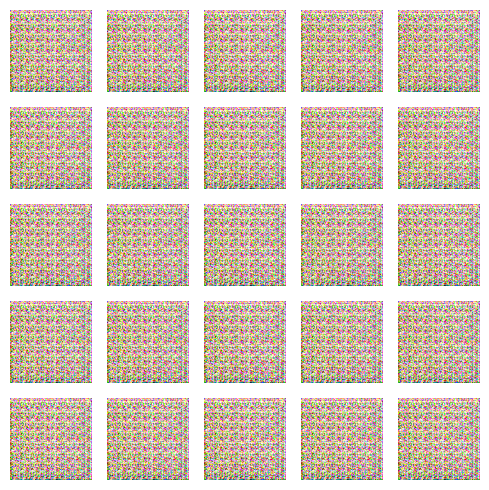

In [ ]:
for epoch in range(epochs):
    for batch in tqdm(range(steps_per_epoch)):
        noise = np.random.normal(0, 1, size=(batch_size, noise_dim))
        fake_x = generator.predict(noise)

        real_x = data[np.random.randint(0, data.shape[0], size=batch_size)]
        #print(real_x.shape)
        #print(fake_x.shape)
        x = np.concatenate((real_x, fake_x))

        disc_y = np.zeros(2*batch_size)
        disc_y[:batch_size] = 0.9

        d_loss = discriminator.train_on_batch(x, disc_y)

        y_gen = np.ones(batch_size)
        g_loss = gan.train_on_batch(noise, y_gen)

    print(f'Epoch: {epoch + 1} \t Discriminator Loss: {d_loss} \t\t Generator Loss: {g_loss}')
    noise = np.random.normal(0, 1, size=(25, noise_dim))
    show_images(noise, (5, 5))

In [ ]:
gan.save('gan.h5')
generator.save('generator.h5')
discriminator.save('discriminator.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


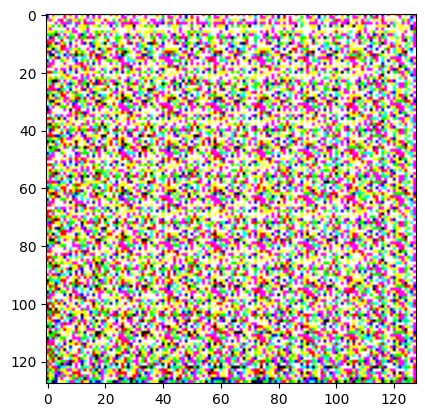

In [ ]:
noise = np.random.normal(0, 1, size=(1, noise_dim))
generated_images = generator.predict(noise)
for i, image in enumerate(generated_images):
    plt.imshow(image.reshape((img_rows, img_cols, channels)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


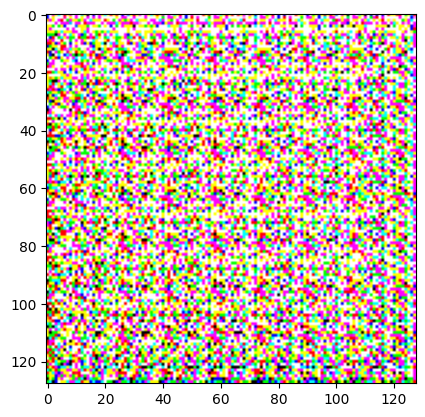

In [ ]:
noise = np.random.normal(0, 1, size=(1, noise_dim))
generated_images = generator.predict(noise)
for i, image in enumerate(generated_images):
    plt.imshow(image.reshape((img_rows, img_cols, channels)))